### Answer 2

We have 2D data sampled i.i.d from mixture of 3 gaussians. There are 1000 samples for training and 10000 for testing. 
- We train and test a single hidden layer MLP function approximator to estimate the value of x2 from the value of x1 by minimizing the mean-squared-error (MSE) on the training set.
- This is a "Regression" problem
- We use 10-fold cross-validation to select between logistic (sigmoid) and softplus (SmoothReLu) nonlinearities for the perceptrons in the hidden layer, as well as the number of perceptrons.
- Output layer is linear 
- The best model architecture is identified using cross- validation, and the selected model is trained with the entire training set.
- This MLP is applied to the test dataset
- Tensorflow and Keras have been used for the problem

ToDo-
- Estimate the test performance
- (1) visual and numerical demonstrations of the cross-validation process indicating how the model selection was carried out; (2) visual and numerical demonstration of the performance of the trained model on the test data set.
- keras graph 

![title](./images/IMG_6589.jpg)
* Gradient Descent Update Rule is - 
![title](./images/1.png)
where L is MSE loss function

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
mean1 = [-18, -8]
mean2 = [0, 0]
mean3 = [18, 8]
cov_eig_val = np.array([[3.2**2, 0], [0, 0.6**2]])
cov_eig_vec1 = np.array([[1, -1], [1, 1]])/math.sqrt(2)
cov_eig_vec2 = np.array([[1, 0], [0, 1]])
cov_eig_vec3 = np.array([[1, -1], [1, 1]])/math.sqrt(2)
cov1 = np.matmul(cov_eig_vec1, np.matmul(cov_eig_val, cov_eig_vec1.T))
cov2 = np.matmul(cov_eig_vec2, np.matmul(cov_eig_val, cov_eig_vec2.T))
cov3 = np.matmul(cov_eig_vec3, np.matmul(cov_eig_val, cov_eig_vec3.T))
priors=[0.33,0.34,0.33]

In [3]:
data_dist = np.random.uniform(0, 1, 1000)
data1 = np.matmul(np.matmul(cov_eig_vec1,(cov_eig_val**0.5)),np.random.randn(2, len(data_dist[np.where(data_dist<=priors[0])]))) + np.array(mean1)[:, None]
data2 = np.matmul(np.matmul(cov_eig_vec2,(cov_eig_val**0.5)),np.random.randn(2, len([x for x in data_dist if x<=(priors[0]+priors[1]) and x>priors[0]]))) + np.array(mean2)[:, None]
data3 = np.matmul(np.matmul(cov_eig_vec3,(cov_eig_val**0.5)),np.random.randn(2, len(data_dist[np.where(data_dist>(priors[0]+priors[1]))]))) + np.array(mean3)[:, None]

In [4]:
data1 = data1.T
data2 = data2.T
data3 = data3.T
train_dataset = np.vstack([data1, data2, data3])

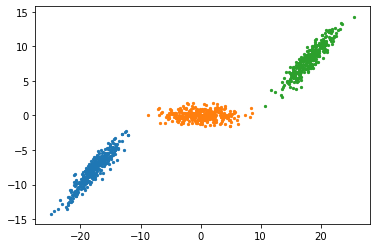

In [5]:
plt.scatter(data1[:, 0], data1[:, 1], label='Class 1', s=5)
plt.scatter(data2[:, 0], data2[:, 1], label='Class 2', s=5)
plt.scatter(data3[:, 0], data3[:, 1], label='Class 3', s=5)

### Test dataset

In [7]:
test_data_dist = np.random.uniform(0, 1, 10000)
test_data1 = np.matmul(np.matmul(cov_eig_vec1,(cov_eig_val**0.5)),np.random.randn(2, len(test_data_dist[np.where(test_data_dist<=priors[0])]))) + np.array(mean1)[:, None]
test_data2 = np.matmul(np.matmul(cov_eig_vec2,(cov_eig_val**0.5)),np.random.randn(2, len([x for x in test_data_dist if x<=(priors[0]+priors[1]) and x>priors[0]]))) + np.array(mean2)[:, None]
test_data3 = np.matmul(np.matmul(cov_eig_vec3,(cov_eig_val**0.5)),np.random.randn(2, len(test_data_dist[np.where(test_data_dist>(priors[0]+priors[1]))]))) + np.array(mean3)[:, None]

In [8]:
test_data1 = test_data1.T
test_data2 = test_data2.T
test_data3 = test_data3.T
test_dataset = np.vstack([test_data1, test_data2, test_data3])

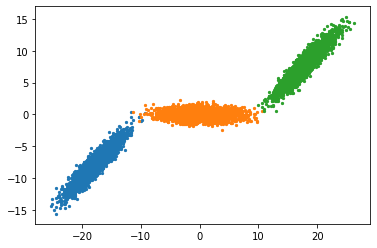

In [9]:
plt.scatter(test_data1[:, 0], test_data1[:, 1], label='Class 1', s=5)
plt.scatter(test_data2[:, 0], test_data2[:, 1], label='Class 2', s=5)
plt.scatter(test_data3[:, 0], test_data3[:, 1], label='Class 3', s=5)

### Neural Network

In [16]:
activations = ['sigmoid', 'softplus']
hidd_layer_param_list = [4, 9, 11, 14]

In [17]:
print(train_dataset.shape)

(1000, 2)


In [18]:
X=train_dataset[:,0]
Y=train_dataset[:,1]

In [19]:
print(X.shape)
print(Y.shape)

(1000,)
(1000,)


In [20]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [21]:
def create_model(nodes,activation):
    model = Sequential()
    model.add(Dense(nodes, input_dim=1,activation=activation))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [26]:
model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model,nodes='nodes',activation='activation')

In [32]:
from sklearn.model_selection import GridSearchCV
parameters = {'nodes':[4,6,10,14],'activation':['softplus','sigmoid']}
model_GridSearchCV = GridSearchCV(model, parameters, cv=10,scoring='neg_mean_squared_error')
model_GridSearchCV

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x1a311787b8>,
             iid='warn', n_jobs=None,
             param_grid={'activation': ['softplus', 'sigmoid'],
                         'nodes': [4, 6, 10, 14]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [34]:
from keras.callbacks import EarlyStopping

In [35]:
es = EarlyStopping(monitor='mse', mode='min', verbose=1, patience=10,min_delta=.1)
grid_result=model_GridSearchCV.fit(X, Y, epochs=1000, batch_size=len(X), verbose=1,callbacks=[es])
#grid_result=model_GridSearchCV.fit(X, Y, epochs=1000, batch_size=len(X), verbose=1)

Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 258us/sample - loss: 222.1022 - mse: 222.1022
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 221.0787 - mse: 221.0787
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 220.0601 - mse: 220.0601
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 219.0465 - mse: 219.0465
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 218.0378 - mse: 218.0378
Epoch 6/1000
900/900 [==============================] - 0s 3us/sample - loss: 217.0341 - mse: 217.0341
Epoch 7/1000
900/900 [==============================] - 0s 3us/sample - loss: 216.0355 - mse: 216.0355
Epoch 8/1000
900/900 [==============================] - 0s 3us/sample - loss: 215.0422 - mse: 215.0422
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 214.0541 - mse: 214.0541
Epoch 10/1000
900/900 [===========================

Epoch 80/1000
900/900 [==============================] - 0s 3us/sample - loss: 157.6256 - mse: 157.6256
Epoch 81/1000
900/900 [==============================] - 0s 3us/sample - loss: 156.9983 - mse: 156.9983
Epoch 82/1000
900/900 [==============================] - 0s 3us/sample - loss: 156.3745 - mse: 156.3745
Epoch 83/1000
900/900 [==============================] - 0s 5us/sample - loss: 155.7545 - mse: 155.7545
Epoch 84/1000
900/900 [==============================] - 0s 3us/sample - loss: 155.1379 - mse: 155.1379
Epoch 85/1000
900/900 [==============================] - 0s 3us/sample - loss: 154.5249 - mse: 154.5249
Epoch 86/1000
900/900 [==============================] - 0s 3us/sample - loss: 153.9154 - mse: 153.9154
Epoch 87/1000
900/900 [==============================] - 0s 3us/sample - loss: 153.3093 - mse: 153.3093
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 152.7066 - mse: 152.7066
Epoch 89/1000
900/900 [==============================] - 0s 4us/

Epoch 159/1000
900/900 [==============================] - 0s 2us/sample - loss: 117.0626 - mse: 117.0626
Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 116.6447 - mse: 116.6447
Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 116.2289 - mse: 116.2289
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 115.8151 - mse: 115.8151
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 115.4031 - mse: 115.4031
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 114.9932 - mse: 114.9932
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample - loss: 114.5852 - mse: 114.5852
Epoch 166/1000
900/900 [==============================] - 0s 3us/sample - loss: 114.1792 - mse: 114.1792
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 113.7750 - mse: 113.7750
Epoch 168/1000
900/900 [==============================]

Epoch 238/1000
900/900 [==============================] - 0s 2us/sample - loss: 89.4045 - mse: 89.4045
Epoch 239/1000
900/900 [==============================] - 0s 2us/sample - loss: 89.1146 - mse: 89.1146
Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.8259 - mse: 88.8259
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.5386 - mse: 88.5386
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.2525 - mse: 88.2525
Epoch 243/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.9677 - mse: 87.9677
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 87.6842 - mse: 87.6842
Epoch 245/1000
900/900 [==============================] - 0s 3us/sample - loss: 87.4019 - mse: 87.4019
Epoch 246/1000
900/900 [==============================] - 0s 3us/sample - loss: 87.1209 - mse: 87.1209
Epoch 247/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 318/1000
900/900 [==============================] - 0s 3us/sample - loss: 69.7977 - mse: 69.7977
Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 69.5927 - mse: 69.5927
Epoch 320/1000
900/900 [==============================] - 0s 4us/sample - loss: 69.3886 - mse: 69.3886
Epoch 321/1000
900/900 [==============================] - 0s 3us/sample - loss: 69.1853 - mse: 69.1853
Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 68.9829 - mse: 68.9829
Epoch 323/1000
900/900 [==============================] - 0s 6us/sample - loss: 68.7813 - mse: 68.7813
Epoch 324/1000
900/900 [==============================] - 0s 4us/sample - loss: 68.5806 - mse: 68.5806
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.3807 - mse: 68.3807
Epoch 326/1000
900/900 [==============================] - 0s 4us/sample - loss: 68.1817 - mse: 68.1817
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 398/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.8021 - mse: 55.8021
Epoch 399/1000
900/900 [==============================] - 0s 3us/sample - loss: 55.6543 - mse: 55.6543
Epoch 400/1000
900/900 [==============================] - 0s 4us/sample - loss: 55.5071 - mse: 55.5071
Epoch 401/1000
900/900 [==============================] - 0s 4us/sample - loss: 55.3605 - mse: 55.3605
Epoch 402/1000
900/900 [==============================] - 0s 3us/sample - loss: 55.2145 - mse: 55.2145
Epoch 403/1000
900/900 [==============================] - 0s 3us/sample - loss: 55.0690 - mse: 55.0690
Epoch 404/1000
900/900 [==============================] - 0s 3us/sample - loss: 54.9241 - mse: 54.9241
Epoch 405/1000
900/900 [==============================] - 0s 5us/sample - loss: 54.7798 - mse: 54.7798
Epoch 406/1000
900/900 [==============================] - 0s 4us/sample - loss: 54.6361 - mse: 54.6361
Epoch 407/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 478/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.6456 - mse: 45.6456
Epoch 479/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.5377 - mse: 45.5377
Epoch 480/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4302 - mse: 45.4302
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.3232 - mse: 45.3232
Epoch 482/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.2166 - mse: 45.2166
Epoch 483/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.1104 - mse: 45.1104
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0046 - mse: 45.0046
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8992 - mse: 44.8992
Epoch 486/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.7942 - mse: 44.7942
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 558/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2171 - mse: 38.2171
Epoch 559/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.1382 - mse: 38.1382
Epoch 560/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.0595 - mse: 38.0595
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9812 - mse: 37.9812
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9032 - mse: 37.9032
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8254 - mse: 37.8254
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7480 - mse: 37.7480
Epoch 565/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.6709 - mse: 37.6709
Epoch 566/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.5941 - mse: 37.5941
Epoch 567/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 638/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7858 - mse: 32.7858
Epoch 639/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7281 - mse: 32.7281
Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6707 - mse: 32.6707
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6134 - mse: 32.6134
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5565 - mse: 32.5565
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4997 - mse: 32.4997
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4431 - mse: 32.4431
Epoch 645/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.3868 - mse: 32.3868
Epoch 646/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.3307 - mse: 32.3307
Epoch 647/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 718/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8120 - mse: 28.8120
Epoch 719/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7696 - mse: 28.7696
Epoch 720/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7274 - mse: 28.7274
Epoch 721/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6853 - mse: 28.6853
Epoch 722/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6434 - mse: 28.6434
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6017 - mse: 28.6017
Epoch 724/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.5601 - mse: 28.5601
Epoch 725/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.5187 - mse: 28.5187
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4774 - mse: 28.4774
Epoch 727/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 798/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.8669 - mse: 25.8669
Epoch 799/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8351 - mse: 25.8351
Epoch 800/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8034 - mse: 25.8034
Epoch 801/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7719 - mse: 25.7719
Epoch 802/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.7404 - mse: 25.7404
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7090 - mse: 25.7090
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6778 - mse: 25.6778
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6467 - mse: 25.6467
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6156 - mse: 25.6156
Epoch 807/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 878/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6303 - mse: 23.6303
Epoch 879/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6058 - mse: 23.6058
Epoch 880/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5814 - mse: 23.5814
Epoch 881/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5571 - mse: 23.5571
Epoch 882/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5328 - mse: 23.5328
Epoch 883/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5086 - mse: 23.5086
Epoch 884/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4845 - mse: 23.4845
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4605 - mse: 23.4605
Epoch 886/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.4365 - mse: 23.4365
Epoch 887/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 958/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8891 - mse: 21.8891
Epoch 959/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8699 - mse: 21.8699
Epoch 960/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8507 - mse: 21.8507
Epoch 961/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8315 - mse: 21.8315
Epoch 962/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8124 - mse: 21.8124
Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7934 - mse: 21.7934
Epoch 964/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7744 - mse: 21.7744
Epoch 965/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7555 - mse: 21.7555
Epoch 966/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7366 - mse: 21.7366
Epoch 967/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 97.9798 - mse: 97.9798
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 97.2719 - mse: 97.2719
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 96.5709 - mse: 96.5709
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 95.8766 - mse: 95.8766
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 95.1889 - mse: 95.1889
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 94.5079 - mse: 94.5079
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 93.8335 - mse: 93.8335
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 93.1656 - mse: 93.1656
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 92.5042 - mse: 92.5042
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 91.

900/900 [==============================] - 0s 3us/sample - loss: 58.4552 - mse: 58.4552
Epoch 119/1000
900/900 [==============================] - 0s 2us/sample - loss: 58.1275 - mse: 58.1275
Epoch 120/1000
900/900 [==============================] - 0s 3us/sample - loss: 57.8028 - mse: 57.8028
Epoch 121/1000
900/900 [==============================] - 0s 3us/sample - loss: 57.4811 - mse: 57.4811
Epoch 122/1000
900/900 [==============================] - 0s 4us/sample - loss: 57.1623 - mse: 57.1623
Epoch 123/1000
900/900 [==============================] - 0s 4us/sample - loss: 56.8464 - mse: 56.8464
Epoch 124/1000
900/900 [==============================] - 0s 5us/sample - loss: 56.5333 - mse: 56.5333
Epoch 125/1000
900/900 [==============================] - 0s 4us/sample - loss: 56.2231 - mse: 56.2231
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.9157 - mse: 55.9157
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.6111 

Epoch 198/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.5950 - mse: 39.5950
Epoch 199/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.4317 - mse: 39.4317
Epoch 200/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.2698 - mse: 39.2698
Epoch 201/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.1092 - mse: 39.1092
Epoch 202/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.9500 - mse: 38.9500
Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.7921 - mse: 38.7921
Epoch 204/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.6355 - mse: 38.6355
Epoch 205/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.4801 - mse: 38.4801
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.3261 - mse: 38.3261
Epoch 207/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 278/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9904 - mse: 29.9904
Epoch 279/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9055 - mse: 29.9055
Epoch 280/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8214 - mse: 29.8214
Epoch 281/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7379 - mse: 29.7379
Epoch 282/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.6552 - mse: 29.6552
Epoch 283/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5730 - mse: 29.5730
Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4916 - mse: 29.4916
Epoch 285/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.4107 - mse: 29.4107
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3306 - mse: 29.3306
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 358/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9580 - mse: 24.9580
Epoch 359/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9131 - mse: 24.9131
Epoch 360/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8685 - mse: 24.8685
Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8243 - mse: 24.8243
Epoch 362/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7804 - mse: 24.7804
Epoch 363/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.7369 - mse: 24.7369
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6937 - mse: 24.6937
Epoch 365/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6509 - mse: 24.6509
Epoch 366/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6084 - mse: 24.6084
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 438/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.2612 - mse: 22.2612
Epoch 439/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.2366 - mse: 22.2366
Epoch 440/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.2122 - mse: 22.2122
Epoch 441/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.1880 - mse: 22.1880
Epoch 442/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1640 - mse: 22.1640
Epoch 443/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1401 - mse: 22.1401
Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1164 - mse: 22.1164
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0929 - mse: 22.0929
Epoch 446/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0695 - mse: 22.0695
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 518/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7446 - mse: 20.7446
Epoch 519/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7302 - mse: 20.7302
Epoch 520/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7159 - mse: 20.7159
Epoch 521/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7017 - mse: 20.7017
Epoch 522/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6875 - mse: 20.6875
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6735 - mse: 20.6735
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6595 - mse: 20.6595
Epoch 525/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6456 - mse: 20.6456
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6318 - mse: 20.6318
Epoch 527/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 80.0974 - mse: 80.0974
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 79.2376 - mse: 79.2376
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 78.3841 - mse: 78.3841
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 77.5370 - mse: 77.5370
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 76.6964 - mse: 76.6964
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 75.8623 - mse: 75.8623
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 75.0348 - mse: 75.0348
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 74.2139 - mse: 74.2139
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 73.3997 - mse: 73.3997
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 72.592

Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.2706 - mse: 31.2706
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8952 - mse: 30.8952
Epoch 90/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.5241 - mse: 30.5241
Epoch 91/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.1573 - mse: 30.1573
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7947 - mse: 29.7947
Epoch 93/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4363 - mse: 29.4363
Epoch 94/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.0821 - mse: 29.0821
Epoch 95/1000
900/900 [==============================] - 0s 5us/sample - loss: 28.7319 - mse: 28.7319
Epoch 96/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.3858 - mse: 28.3858
Epoch 97/1000
900/900 [==============================] - 0s 6us/sample - loss: 28.

Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.8869 - mse: 11.8869
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.7477 - mse: 11.7477
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6103 - mse: 11.6103
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4748 - mse: 11.4748
Epoch 172/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.3411 - mse: 11.3411
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2091 - mse: 11.2091
Epoch 174/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.0789 - mse: 11.0789
Epoch 175/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9504 - mse: 10.9504
Epoch 176/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8236 - mse: 10.8236
Epoch 177/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.0407 - mse: 5.0407
Epoch 250/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.9959 - mse: 4.9959
Epoch 251/1000
900/900 [==============================] - 0s 4us/sample - loss: 4.9519 - mse: 4.9519
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.9085 - mse: 4.9085
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8657 - mse: 4.8657
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8235 - mse: 4.8235
Epoch 255/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7819 - mse: 4.7819
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7410 - mse: 4.7410
Epoch 257/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.7006 - mse: 4.7006
Epoch 258/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6609 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.9188 - mse: 2.9188
Epoch 331/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.9056 - mse: 2.9056
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8925 - mse: 2.8925
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8797 - mse: 2.8797
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8671 - mse: 2.8671
Epoch 335/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8546 - mse: 2.8546
Epoch 336/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8424 - mse: 2.8424
Epoch 337/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.8303 - mse: 2.8303
Epoch 338/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.8185 - mse: 2.8185
Epoch 339/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.8068 - mse: 2.8068
Epoch

Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.3953 - mse: 46.3953
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.0850 - mse: 46.0850
Epoch 57/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.7776 - mse: 45.7776
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4734 - mse: 45.4734
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.1721 - mse: 45.1721
Epoch 60/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8739 - mse: 44.8739
Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.5787 - mse: 44.5787
Epoch 62/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.2865 - mse: 44.2865
Epoch 63/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.9973 - mse: 43.9973
Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.

Epoch 135/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.1604 - mse: 30.1604
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0499 - mse: 30.0499
Epoch 137/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.9412 - mse: 29.9412
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8343 - mse: 29.8343
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7291 - mse: 29.7291
Epoch 140/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.6255 - mse: 29.6255
Epoch 141/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5237 - mse: 29.5237
Epoch 142/1000
900/900 [==============================] - 0s 6us/sample - loss: 29.4235 - mse: 29.4235
Epoch 143/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.3250 - mse: 29.3250
Epoch 144/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 215/1000
900/900 [==============================] - 0s 4us/sample - loss: 25.3272 - mse: 25.3272
Epoch 216/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2998 - mse: 25.2998
Epoch 217/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2727 - mse: 25.2727
Epoch 218/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2462 - mse: 25.2462
Epoch 219/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2200 - mse: 25.2200
Epoch 220/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.1942 - mse: 25.1942
Epoch 221/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.1688 - mse: 25.1688
Epoch 222/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.1438 - mse: 25.1438
Epoch 223/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.1192 - mse: 25.1192
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 295/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.9091 - mse: 23.9091
Epoch 296/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8963 - mse: 23.8963
Epoch 297/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8835 - mse: 23.8835
Epoch 298/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8707 - mse: 23.8707
Epoch 299/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8580 - mse: 23.8580
Epoch 300/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8453 - mse: 23.8453
Epoch 301/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8327 - mse: 23.8327
Epoch 302/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8201 - mse: 23.8201
Epoch 303/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8076 - mse: 23.8076
Epoch 304/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 375/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9452 - mse: 22.9452
Epoch 376/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9333 - mse: 22.9333
Epoch 377/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9213 - mse: 22.9213
Epoch 378/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9092 - mse: 22.9092
Epoch 379/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8972 - mse: 22.8972
Epoch 380/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8852 - mse: 22.8852
Epoch 381/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8731 - mse: 22.8731
Epoch 382/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8611 - mse: 22.8611
Epoch 383/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8490 - mse: 22.8490
Epoch 384/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 455/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8856 - mse: 21.8856
Epoch 456/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8700 - mse: 21.8700
Epoch 457/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8543 - mse: 21.8543
Epoch 458/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8386 - mse: 21.8386
Epoch 459/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8227 - mse: 21.8227
Epoch 460/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8067 - mse: 21.8067
Epoch 461/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7906 - mse: 21.7906
Epoch 462/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7745 - mse: 21.7745
Epoch 463/1000
900/900 [==============================] - 0s 4us/sample - loss: 21.7582 - mse: 21.7582
Epoch 464/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 535/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0909 - mse: 20.0909
Epoch 536/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0564 - mse: 20.0564
Epoch 537/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0214 - mse: 20.0214
Epoch 538/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9859 - mse: 19.9859
Epoch 539/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9498 - mse: 19.9498
Epoch 540/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.9133 - mse: 19.9133
Epoch 541/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8762 - mse: 19.8762
Epoch 542/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8386 - mse: 19.8386
Epoch 543/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8005 - mse: 19.8005
Epoch 544/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 615/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0244 - mse: 15.0244
Epoch 616/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9277 - mse: 14.9277
Epoch 617/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8304 - mse: 14.8304
Epoch 618/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7325 - mse: 14.7325
Epoch 619/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.6341 - mse: 14.6341
Epoch 620/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.5351 - mse: 14.5351
Epoch 621/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.4356 - mse: 14.4356
Epoch 622/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3356 - mse: 14.3356
Epoch 623/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2352 - mse: 14.2352
Epoch 624/1000
900/900 [==============================] - 0s 2us/sample -

900/900 [==============================] - 0s 3us/sample - loss: 7.3359 - mse: 7.3359
Epoch 696/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.2598 - mse: 7.2598
Epoch 697/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.1843 - mse: 7.1843
Epoch 698/1000
900/900 [==============================] - 0s 3us/sample - loss: 7.1096 - mse: 7.1096
Epoch 699/1000
900/900 [==============================] - 0s 3us/sample - loss: 7.0357 - mse: 7.0357
Epoch 700/1000
900/900 [==============================] - 0s 3us/sample - loss: 6.9625 - mse: 6.9625
Epoch 701/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.8901 - mse: 6.8901
Epoch 702/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.8185 - mse: 6.8185
Epoch 703/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.7476 - mse: 6.7476
Epoch 704/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.6774 - mse: 6.6774
Epoch

Epoch 777/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.4043 - mse: 3.4043
Epoch 778/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3804 - mse: 3.3804
Epoch 779/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3570 - mse: 3.3570
Epoch 780/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3340 - mse: 3.3340
Epoch 781/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3114 - mse: 3.3114
Epoch 782/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.2893 - mse: 3.2893
Epoch 783/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2675 - mse: 3.2675
Epoch 784/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2462 - mse: 3.2462
Epoch 785/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.2252 - mse: 3.2252
Epoch 786/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.2046 - ms

Epoch 25/1000
900/900 [==============================] - 0s 2us/sample - loss: 241.4026 - mse: 241.4026
Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 240.0143 - mse: 240.0143
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 238.6339 - mse: 238.6339
Epoch 28/1000
900/900 [==============================] - 0s 2us/sample - loss: 237.2614 - mse: 237.2614
Epoch 29/1000
900/900 [==============================] - 0s 2us/sample - loss: 235.8967 - mse: 235.8967
Epoch 30/1000
900/900 [==============================] - 0s 2us/sample - loss: 234.5399 - mse: 234.5399
Epoch 31/1000
900/900 [==============================] - 0s 2us/sample - loss: 233.1912 - mse: 233.1912
Epoch 32/1000
900/900 [==============================] - 0s 2us/sample - loss: 231.8502 - mse: 231.8502
Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 230.5172 - mse: 230.5172
Epoch 34/1000
900/900 [==============================] - 0s 2us/

Epoch 104/1000
900/900 [==============================] - 0s 3us/sample - loss: 154.4024 - mse: 154.4024
Epoch 105/1000
900/900 [==============================] - 0s 3us/sample - loss: 153.5616 - mse: 153.5616
Epoch 106/1000
900/900 [==============================] - 0s 2us/sample - loss: 152.7264 - mse: 152.7264
Epoch 107/1000
900/900 [==============================] - 0s 2us/sample - loss: 151.8968 - mse: 151.8968
Epoch 108/1000
900/900 [==============================] - 0s 2us/sample - loss: 151.0727 - mse: 151.0727
Epoch 109/1000
900/900 [==============================] - 0s 2us/sample - loss: 150.2542 - mse: 150.2542
Epoch 110/1000
900/900 [==============================] - 0s 2us/sample - loss: 149.4410 - mse: 149.4410
Epoch 111/1000
900/900 [==============================] - 0s 2us/sample - loss: 148.6333 - mse: 148.6333
Epoch 112/1000
900/900 [==============================] - 0s 2us/sample - loss: 147.8310 - mse: 147.8310
Epoch 113/1000
900/900 [==============================]

900/900 [==============================] - 0s 2us/sample - loss: 103.4156 - mse: 103.4156
Epoch 183/1000
900/900 [==============================] - 0s 2us/sample - loss: 102.9266 - mse: 102.9266
Epoch 184/1000
900/900 [==============================] - 0s 2us/sample - loss: 102.4412 - mse: 102.4412
Epoch 185/1000
900/900 [==============================] - 0s 2us/sample - loss: 101.9592 - mse: 101.9592
Epoch 186/1000
900/900 [==============================] - 0s 2us/sample - loss: 101.4808 - mse: 101.4808
Epoch 187/1000
900/900 [==============================] - 0s 2us/sample - loss: 101.0058 - mse: 101.0058
Epoch 188/1000
900/900 [==============================] - 0s 2us/sample - loss: 100.5342 - mse: 100.5342
Epoch 189/1000
900/900 [==============================] - 0s 3us/sample - loss: 100.0660 - mse: 100.0660
Epoch 190/1000
900/900 [==============================] - 0s 2us/sample - loss: 99.6012 - mse: 99.6012
Epoch 191/1000
900/900 [==============================] - 0s 2us/sample 

Epoch 262/1000
900/900 [==============================] - 0s 2us/sample - loss: 73.7486 - mse: 73.7486
Epoch 263/1000
900/900 [==============================] - 0s 3us/sample - loss: 73.4786 - mse: 73.4786
Epoch 264/1000
900/900 [==============================] - 0s 2us/sample - loss: 73.2106 - mse: 73.2106
Epoch 265/1000
900/900 [==============================] - 0s 2us/sample - loss: 72.9446 - mse: 72.9446
Epoch 266/1000
900/900 [==============================] - 0s 2us/sample - loss: 72.6807 - mse: 72.6807
Epoch 267/1000
900/900 [==============================] - 0s 3us/sample - loss: 72.4187 - mse: 72.4187
Epoch 268/1000
900/900 [==============================] - 0s 3us/sample - loss: 72.1587 - mse: 72.1587
Epoch 269/1000
900/900 [==============================] - 0s 3us/sample - loss: 71.9006 - mse: 71.9006
Epoch 270/1000
900/900 [==============================] - 0s 2us/sample - loss: 71.6444 - mse: 71.6444
Epoch 271/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 342/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.3926 - mse: 57.3926
Epoch 343/1000
900/900 [==============================] - 0s 3us/sample - loss: 57.2419 - mse: 57.2419
Epoch 344/1000
900/900 [==============================] - 0s 4us/sample - loss: 57.0922 - mse: 57.0922
Epoch 345/1000
900/900 [==============================] - 0s 4us/sample - loss: 56.9435 - mse: 56.9435
Epoch 346/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.7959 - mse: 56.7959
Epoch 347/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.6492 - mse: 56.6492
Epoch 348/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.5035 - mse: 56.5035
Epoch 349/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.3589 - mse: 56.3589
Epoch 350/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.2152 - mse: 56.2152
Epoch 351/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 422/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.9196 - mse: 47.9196
Epoch 423/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.8269 - mse: 47.8269
Epoch 424/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.7347 - mse: 47.7347
Epoch 425/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.6430 - mse: 47.6430
Epoch 426/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.5518 - mse: 47.5518
Epoch 427/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4610 - mse: 47.4610
Epoch 428/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3707 - mse: 47.3707
Epoch 429/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2809 - mse: 47.2809
Epoch 430/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.1915 - mse: 47.1915
Epoch 431/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 502/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.7274 - mse: 41.7274
Epoch 503/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.6625 - mse: 41.6625
Epoch 504/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.5978 - mse: 41.5978
Epoch 505/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.5333 - mse: 41.5333
Epoch 506/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.4691 - mse: 41.4691
Epoch 507/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.4051 - mse: 41.4051
Epoch 508/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.3414 - mse: 41.3414
Epoch 509/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.2779 - mse: 41.2779
Epoch 510/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.2146 - mse: 41.2146
Epoch 511/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 582/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1827 - mse: 37.1827
Epoch 583/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1330 - mse: 37.1330
Epoch 584/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.0834 - mse: 37.0834
Epoch 585/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.0339 - mse: 37.0339
Epoch 586/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9846 - mse: 36.9846
Epoch 587/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9355 - mse: 36.9355
Epoch 588/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.8865 - mse: 36.8865
Epoch 589/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.8376 - mse: 36.8376
Epoch 590/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.7889 - mse: 36.7889
Epoch 591/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 662/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.6194 - mse: 33.6194
Epoch 663/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.5795 - mse: 33.5795
Epoch 664/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.5398 - mse: 33.5398
Epoch 665/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.5002 - mse: 33.5002
Epoch 666/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4607 - mse: 33.4607
Epoch 667/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4212 - mse: 33.4212
Epoch 668/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3819 - mse: 33.3819
Epoch 669/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3427 - mse: 33.3427
Epoch 670/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.3036 - mse: 33.3036
Epoch 671/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 742/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7242 - mse: 30.7242
Epoch 743/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.6913 - mse: 30.6913
Epoch 744/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6585 - mse: 30.6585
Epoch 745/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.6258 - mse: 30.6258
Epoch 746/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.5932 - mse: 30.5932
Epoch 747/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.5606 - mse: 30.5606
Epoch 748/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.5281 - mse: 30.5281
Epoch 749/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4957 - mse: 30.4957
Epoch 750/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4634 - mse: 30.4634
Epoch 751/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 822/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3022 - mse: 28.3022
Epoch 823/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2743 - mse: 28.2743
Epoch 824/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2464 - mse: 28.2464
Epoch 825/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2186 - mse: 28.2186
Epoch 826/1000
900/900 [==============================] - 0s 5us/sample - loss: 28.1908 - mse: 28.1908
Epoch 827/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1631 - mse: 28.1631
Epoch 828/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.1354 - mse: 28.1354
Epoch 829/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1078 - mse: 28.1078
Epoch 830/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0802 - mse: 28.0802
Epoch 831/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 902/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2083 - mse: 26.2083
Epoch 903/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.1836 - mse: 26.1836
Epoch 904/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.1591 - mse: 26.1591
Epoch 905/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1345 - mse: 26.1345
Epoch 906/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.1100 - mse: 26.1100
Epoch 907/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0855 - mse: 26.0855
Epoch 908/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0610 - mse: 26.0610
Epoch 909/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0366 - mse: 26.0366
Epoch 910/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0122 - mse: 26.0122
Epoch 911/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 982/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3246 - mse: 24.3246
Epoch 983/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3020 - mse: 24.3020
Epoch 984/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2793 - mse: 24.2793
Epoch 985/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.2567 - mse: 24.2567
Epoch 986/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.2341 - mse: 24.2341
Epoch 987/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2115 - mse: 24.2115
Epoch 988/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.1889 - mse: 24.1889
Epoch 989/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.1664 - mse: 24.1664
Epoch 990/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1438 - mse: 24.1438
Epoch 991/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 169.6787 - mse: 169.6787
Epoch 62/1000
900/900 [==============================] - 0s 3us/sample - loss: 168.7139 - mse: 168.7139
Epoch 63/1000
900/900 [==============================] - 0s 2us/sample - loss: 167.7539 - mse: 167.7539
Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 166.7987 - mse: 166.7987
Epoch 65/1000
900/900 [==============================] - 0s 2us/sample - loss: 165.8482 - mse: 165.8482
Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 164.9024 - mse: 164.9024
Epoch 67/1000
900/900 [==============================] - 0s 2us/sample - loss: 163.9613 - mse: 163.9613
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 163.0248 - mse: 163.0248
Epoch 69/1000
900/900 [==============================] - 0s 2us/sample - loss: 162.0930 - mse: 162.0930
Epoch 70/1000
900/900 [==============================] - 0s 2us/

Epoch 140/1000
900/900 [==============================] - 0s 2us/sample - loss: 106.6310 - mse: 106.6310
Epoch 141/1000
900/900 [==============================] - 0s 3us/sample - loss: 105.9841 - mse: 105.9841
Epoch 142/1000
900/900 [==============================] - 0s 2us/sample - loss: 105.3405 - mse: 105.3405
Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 104.7002 - mse: 104.7002
Epoch 144/1000
900/900 [==============================] - 0s 3us/sample - loss: 104.0631 - mse: 104.0631
Epoch 145/1000
900/900 [==============================] - 0s 2us/sample - loss: 103.4293 - mse: 103.4293
Epoch 146/1000
900/900 [==============================] - 0s 2us/sample - loss: 102.7988 - mse: 102.7988
Epoch 147/1000
900/900 [==============================] - 0s 2us/sample - loss: 102.1714 - mse: 102.1714
Epoch 148/1000
900/900 [==============================] - 0s 3us/sample - loss: 101.5473 - mse: 101.5473
Epoch 149/1000
900/900 [==============================]

Epoch 220/1000
900/900 [==============================] - 0s 3us/sample - loss: 64.0951 - mse: 64.0951
Epoch 221/1000
900/900 [==============================] - 0s 3us/sample - loss: 63.6675 - mse: 63.6675
Epoch 222/1000
900/900 [==============================] - 0s 5us/sample - loss: 63.2422 - mse: 63.2422
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample - loss: 62.8191 - mse: 62.8191
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample - loss: 62.3983 - mse: 62.3983
Epoch 225/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.9798 - mse: 61.9798
Epoch 226/1000
900/900 [==============================] - 0s 3us/sample - loss: 61.5634 - mse: 61.5634
Epoch 227/1000
900/900 [==============================] - 0s 3us/sample - loss: 61.1493 - mse: 61.1493
Epoch 228/1000
900/900 [==============================] - 0s 3us/sample - loss: 60.7374 - mse: 60.7374
Epoch 229/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 300/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.3512 - mse: 36.3512
Epoch 301/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0791 - mse: 36.0791
Epoch 302/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8087 - mse: 35.8087
Epoch 303/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.5399 - mse: 35.5399
Epoch 304/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2727 - mse: 35.2727
Epoch 305/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.0072 - mse: 35.0072
Epoch 306/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7434 - mse: 34.7434
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4811 - mse: 34.4811
Epoch 308/1000
900/900 [==============================] - 0s 4us/sample - loss: 34.2205 - mse: 34.2205
Epoch 309/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 380/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3233 - mse: 19.3233
Epoch 381/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.1648 - mse: 19.1648
Epoch 382/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.0075 - mse: 19.0075
Epoch 383/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.8513 - mse: 18.8513
Epoch 384/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6963 - mse: 18.6963
Epoch 385/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5425 - mse: 18.5425
Epoch 386/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.3899 - mse: 18.3899
Epoch 387/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.2384 - mse: 18.2384
Epoch 388/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.0880 - mse: 18.0880
Epoch 389/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 460/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.9180 - mse: 9.9180
Epoch 461/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8366 - mse: 9.8366
Epoch 462/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.7558 - mse: 9.7558
Epoch 463/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.6758 - mse: 9.6758
Epoch 464/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.5966 - mse: 9.5966
Epoch 465/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.5181 - mse: 9.5181
Epoch 466/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4403 - mse: 9.4403
Epoch 467/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3632 - mse: 9.3632
Epoch 468/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2868 - mse: 9.2868
Epoch 469/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2112 - ms

900/900 [==============================] - 0s 3us/sample - loss: 5.3388 - mse: 5.3388
Epoch 542/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.3030 - mse: 5.3030
Epoch 543/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.2676 - mse: 5.2676
Epoch 544/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.2326 - mse: 5.2326
Epoch 545/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1980 - mse: 5.1980
Epoch 546/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1638 - mse: 5.1638
Epoch 547/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1300 - mse: 5.1300
Epoch 548/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.0965 - mse: 5.0965
Epoch 549/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.0635 - mse: 5.0635
Epoch 550/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.0308 - mse: 5.0308
Epoch

Epoch 623/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.4438 - mse: 3.4438
Epoch 624/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.4306 - mse: 3.4306
Epoch 625/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.4175 - mse: 3.4175
Epoch 626/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.4046 - mse: 3.4046
Epoch 627/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3919 - mse: 3.3919
Epoch 628/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3794 - mse: 3.3794
Epoch 629/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3670 - mse: 3.3670
Epoch 630/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3547 - mse: 3.3547
Epoch 631/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3427 - mse: 3.3427
Epoch 632/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.3308 - ms

Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0713 - mse: 21.0713
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9631 - mse: 20.9631
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8567 - mse: 20.8567
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7519 - mse: 20.7519
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6485 - mse: 20.6485
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5467 - mse: 20.5467
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4463 - mse: 20.4463
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.3471 - mse: 20.3471
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.2493 - mse: 20.2493
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.

900/900 [==============================] - 0s 2us/sample - loss: 14.3277 - mse: 14.3277
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2497 - mse: 14.2497
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1717 - mse: 14.1717
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0938 - mse: 14.0938
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0160 - mse: 14.0160
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9383 - mse: 13.9383
Epoch 134/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.8606 - mse: 13.8606
Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7831 - mse: 13.7831
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7058 - mse: 13.7058
Epoch 137/1000
900/900 [==============================] - 0s 4us/sample - loss: 13.6285 

900/900 [==============================] - 0s 3us/sample - loss: 8.6080 - mse: 8.6080
Epoch 209/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.5461 - mse: 8.5461
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4845 - mse: 8.4845
Epoch 211/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.4232 - mse: 8.4232
Epoch 212/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.3622 - mse: 8.3622
Epoch 213/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.3014 - mse: 8.3014
Epoch 214/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.2410 - mse: 8.2410
Epoch 215/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.1809 - mse: 8.1809
Epoch 216/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.1212 - mse: 8.1212
Epoch 217/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.0617 - mse: 8.0617
Epoch

Epoch 290/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.6098 - mse: 4.6098
Epoch 291/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.5749 - mse: 4.5749
Epoch 292/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.5404 - mse: 4.5404
Epoch 293/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.5062 - mse: 4.5062
Epoch 294/1000
900/900 [==============================] - 0s 4us/sample - loss: 4.4723 - mse: 4.4723
Epoch 295/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.4388 - mse: 4.4388
Epoch 296/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.4055 - mse: 4.4055
Epoch 297/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3726 - mse: 4.3726
Epoch 298/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.3400 - mse: 4.3400
Epoch 299/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3078 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.7293 - mse: 2.7293
Epoch 372/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.7161 - mse: 2.7161
Epoch 373/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7032 - mse: 2.7032
Epoch 374/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6904 - mse: 2.6904
Epoch 375/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.6779 - mse: 2.6779
Epoch 376/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.6655 - mse: 2.6655
Epoch 377/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.6533 - mse: 2.6533
Epoch 378/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6413 - mse: 2.6413
Epoch 379/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6294 - mse: 2.6294
Epoch 380/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6178 - mse: 2.6178
Epoch

Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 170.8589 - mse: 170.8589
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 170.1244 - mse: 170.1244
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 169.3941 - mse: 169.3941
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 168.6682 - mse: 168.6682
Epoch 60/1000
900/900 [==============================] - 0s 2us/sample - loss: 167.9465 - mse: 167.9465
Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 167.2290 - mse: 167.2290
Epoch 62/1000
900/900 [==============================] - 0s 2us/sample - loss: 166.5157 - mse: 166.5157
Epoch 63/1000
900/900 [==============================] - 0s 2us/sample - loss: 165.8066 - mse: 165.8066
Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 165.1015 - mse: 165.1015
Epoch 65/1000
900/900 [==============================] - 0s 2us/

Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 123.5689 - mse: 123.5689
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 123.0775 - mse: 123.0775
Epoch 137/1000
900/900 [==============================] - 0s 2us/sample - loss: 122.5880 - mse: 122.5880
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 122.1004 - mse: 122.1004
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 121.6147 - mse: 121.6147
Epoch 140/1000
900/900 [==============================] - 0s 2us/sample - loss: 121.1309 - mse: 121.1309
Epoch 141/1000
900/900 [==============================] - 0s 2us/sample - loss: 120.6489 - mse: 120.6489
Epoch 142/1000
900/900 [==============================] - 0s 4us/sample - loss: 120.1687 - mse: 120.1687
Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 119.6903 - mse: 119.6903
Epoch 144/1000
900/900 [==============================]

Epoch 214/1000
900/900 [==============================] - 0s 2us/sample - loss: 89.2752 - mse: 89.2752
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.8888 - mse: 88.8888
Epoch 216/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.5035 - mse: 88.5035
Epoch 217/1000
900/900 [==============================] - 0s 3us/sample - loss: 88.1193 - mse: 88.1193
Epoch 218/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.7362 - mse: 87.7362
Epoch 219/1000
900/900 [==============================] - 0s 3us/sample - loss: 87.3542 - mse: 87.3542
Epoch 220/1000
900/900 [==============================] - 0s 3us/sample - loss: 86.9732 - mse: 86.9732
Epoch 221/1000
900/900 [==============================] - 0s 3us/sample - loss: 86.5934 - mse: 86.5934
Epoch 222/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.2147 - mse: 86.2147
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 294/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.9985 - mse: 61.9985
Epoch 295/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.7068 - mse: 61.7068
Epoch 296/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.4164 - mse: 61.4164
Epoch 297/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.1273 - mse: 61.1273
Epoch 298/1000
900/900 [==============================] - 0s 2us/sample - loss: 60.8394 - mse: 60.8394
Epoch 299/1000
900/900 [==============================] - 0s 3us/sample - loss: 60.5529 - mse: 60.5529
Epoch 300/1000
900/900 [==============================] - 0s 2us/sample - loss: 60.2675 - mse: 60.2675
Epoch 301/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.9835 - mse: 59.9835
Epoch 302/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.7008 - mse: 59.7008
Epoch 303/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 374/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6669 - mse: 42.6669
Epoch 375/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.4752 - mse: 42.4752
Epoch 376/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.2847 - mse: 42.2847
Epoch 377/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.0954 - mse: 42.0954
Epoch 378/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.9072 - mse: 41.9072
Epoch 379/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7202 - mse: 41.7202
Epoch 380/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.5343 - mse: 41.5343
Epoch 381/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.3496 - mse: 41.3496
Epoch 382/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.1660 - mse: 41.1660
Epoch 383/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 454/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.7021 - mse: 30.7021
Epoch 455/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.5907 - mse: 30.5907
Epoch 456/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.4801 - mse: 30.4801
Epoch 457/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3704 - mse: 30.3704
Epoch 458/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2614 - mse: 30.2614
Epoch 459/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1532 - mse: 30.1532
Epoch 460/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0458 - mse: 30.0458
Epoch 461/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9392 - mse: 29.9392
Epoch 462/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.8333 - mse: 29.8333
Epoch 463/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 534/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8987 - mse: 23.8987
Epoch 535/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8352 - mse: 23.8352
Epoch 536/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7721 - mse: 23.7721
Epoch 537/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7094 - mse: 23.7094
Epoch 538/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6471 - mse: 23.6471
Epoch 539/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5852 - mse: 23.5852
Epoch 540/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5237 - mse: 23.5237
Epoch 541/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4626 - mse: 23.4626
Epoch 542/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4018 - mse: 23.4018
Epoch 543/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 614/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8005 - mse: 19.8005
Epoch 615/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.7586 - mse: 19.7586
Epoch 616/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.7168 - mse: 19.7168
Epoch 617/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6752 - mse: 19.6752
Epoch 618/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6337 - mse: 19.6337
Epoch 619/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5924 - mse: 19.5924
Epoch 620/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5513 - mse: 19.5513
Epoch 621/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5103 - mse: 19.5103
Epoch 622/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4694 - mse: 19.4694
Epoch 623/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 694/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8298 - mse: 16.8298
Epoch 695/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.7963 - mse: 16.7963
Epoch 696/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.7629 - mse: 16.7629
Epoch 697/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.7295 - mse: 16.7295
Epoch 698/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.6962 - mse: 16.6962
Epoch 699/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.6629 - mse: 16.6629
Epoch 700/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.6297 - mse: 16.6297
Epoch 701/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5966 - mse: 16.5966
Epoch 702/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.5635 - mse: 16.5635
Epoch 703/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 774/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3117 - mse: 14.3117
Epoch 775/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2819 - mse: 14.2819
Epoch 776/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2521 - mse: 14.2521
Epoch 777/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2224 - mse: 14.2224
Epoch 778/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1927 - mse: 14.1927
Epoch 779/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1630 - mse: 14.1630
Epoch 780/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.1333 - mse: 14.1333
Epoch 781/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.1037 - mse: 14.1037
Epoch 782/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.0741 - mse: 14.0741
Epoch 783/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 854/1000
900/900 [==============================] - 0s 4us/sample - loss: 12.0193 - mse: 12.0193
Epoch 855/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9917 - mse: 11.9917
Epoch 856/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9642 - mse: 11.9642
Epoch 857/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9366 - mse: 11.9366
Epoch 858/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9091 - mse: 11.9091
Epoch 859/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.8817 - mse: 11.8817
Epoch 860/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.8542 - mse: 11.8542
Epoch 861/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.8268 - mse: 11.8268
Epoch 862/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.7994 - mse: 11.7994
Epoch 863/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 934/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8932 - mse: 9.8932
Epoch 935/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8677 - mse: 9.8677
Epoch 936/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8423 - mse: 9.8423
Epoch 937/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8168 - mse: 9.8168
Epoch 938/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.7914 - mse: 9.7914
Epoch 939/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.7660 - mse: 9.7660
Epoch 940/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.7406 - mse: 9.7406
Epoch 941/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.7153 - mse: 9.7153
Epoch 942/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.6900 - mse: 9.6900
Epoch 943/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.6647 - ms

Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3867 - mse: 27.3867
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3789 - mse: 27.3789
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3717 - mse: 27.3717
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3652 - mse: 27.3652
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3591 - mse: 27.3591
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3533 - mse: 27.3533
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3476 - mse: 27.3476
Epoch 00021: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 277us/sample - loss: 115.3681 - mse: 115.3681
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 114.6033 - mse: 114.6033
Epoch 3/1000
900/900 [=======

Epoch 74/1000
900/900 [==============================] - 0s 2us/sample - loss: 71.2251 - mse: 71.2251
Epoch 75/1000
900/900 [==============================] - 0s 2us/sample - loss: 70.7640 - mse: 70.7640
Epoch 76/1000
900/900 [==============================] - 0s 2us/sample - loss: 70.3057 - mse: 70.3057
Epoch 77/1000
900/900 [==============================] - 0s 2us/sample - loss: 69.8503 - mse: 69.8503
Epoch 78/1000
900/900 [==============================] - 0s 2us/sample - loss: 69.3978 - mse: 69.3978
Epoch 79/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.9479 - mse: 68.9479
Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.5008 - mse: 68.5008
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.0564 - mse: 68.0564
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.6147 - mse: 67.6147
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.

Epoch 154/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.4796 - mse: 41.4796
Epoch 155/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.1839 - mse: 41.1839
Epoch 156/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.8899 - mse: 40.8899
Epoch 157/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.5974 - mse: 40.5974
Epoch 158/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.3066 - mse: 40.3066
Epoch 159/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0174 - mse: 40.0174
Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7298 - mse: 39.7298
Epoch 161/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.4438 - mse: 39.4438
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.1594 - mse: 39.1594
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 234/1000
900/900 [==============================] - 0s 5us/sample - loss: 22.4700 - mse: 22.4700
Epoch 235/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.2861 - mse: 22.2861
Epoch 236/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.1034 - mse: 22.1034
Epoch 237/1000
900/900 [==============================] - 0s 4us/sample - loss: 21.9219 - mse: 21.9219
Epoch 238/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7416 - mse: 21.7416
Epoch 239/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5625 - mse: 21.5625
Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3846 - mse: 21.3846
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2078 - mse: 21.2078
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0322 - mse: 21.0322
Epoch 243/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 314/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.1977 - mse: 11.1977
Epoch 315/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.0964 - mse: 11.0964
Epoch 316/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.9960 - mse: 10.9960
Epoch 317/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.8964 - mse: 10.8964
Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.7977 - mse: 10.7977
Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6998 - mse: 10.6998
Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6027 - mse: 10.6027
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5065 - mse: 10.5065
Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.4112 - mse: 10.4112
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 395/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.4226 - mse: 5.4226
Epoch 396/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.3773 - mse: 5.3773
Epoch 397/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.3325 - mse: 5.3325
Epoch 398/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.2883 - mse: 5.2883
Epoch 399/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.2445 - mse: 5.2445
Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.2012 - mse: 5.2012
Epoch 401/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.1585 - mse: 5.1585
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1162 - mse: 5.1162
Epoch 403/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.0744 - mse: 5.0744
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.0332 - ms

900/900 [==============================] - 0s 2us/sample - loss: 3.0957 - mse: 3.0957
Epoch 477/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0800 - mse: 3.0800
Epoch 478/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0645 - mse: 3.0645
Epoch 479/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0493 - mse: 3.0493
Epoch 480/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0343 - mse: 3.0343
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0195 - mse: 3.0195
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0050 - mse: 3.0050
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9906 - mse: 2.9906
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9765 - mse: 2.9765
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9626 - mse: 2.9626
Epoch

Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4119 - mse: 12.4119
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1827 - mse: 12.1827
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9570 - mse: 11.9570
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.7350 - mse: 11.7350
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5165 - mse: 11.5165
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3015 - mse: 11.3015
Epoch 45/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.0899 - mse: 11.0899
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8819 - mse: 10.8819
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6772 - mse: 10.6772
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.

Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0159 - mse: 3.0159
Epoch 122/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.9817 - mse: 2.9817
Epoch 123/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.9485 - mse: 2.9485
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9164 - mse: 2.9164
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8853 - mse: 2.8853
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8552 - mse: 2.8552
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8260 - mse: 2.8260
Epoch 128/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.7978 - mse: 2.7978
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7705 - mse: 2.7705
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7441 - ms

Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.3723 - mse: 88.3723
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.0684 - mse: 88.0684
Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.7666 - mse: 87.7666
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.4671 - mse: 87.4671
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.1697 - mse: 87.1697
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.8744 - mse: 86.8744
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.5811 - mse: 86.5811
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.2898 - mse: 86.2898
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.0004 - mse: 86.0004
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 85.

Epoch 115/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.7572 - mse: 68.7572
Epoch 116/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.5619 - mse: 68.5619
Epoch 117/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.3675 - mse: 68.3675
Epoch 118/1000
900/900 [==============================] - 0s 2us/sample - loss: 68.1740 - mse: 68.1740
Epoch 119/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.9814 - mse: 67.9814
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.7896 - mse: 67.7896
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.5987 - mse: 67.5987
Epoch 122/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.4087 - mse: 67.4087
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 67.2195 - mse: 67.2195
Epoch 124/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 195/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.5461 - mse: 55.5461
Epoch 196/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.4075 - mse: 55.4075
Epoch 197/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.2695 - mse: 55.2695
Epoch 198/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.1320 - mse: 55.1320
Epoch 199/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.9951 - mse: 54.9951
Epoch 200/1000
900/900 [==============================] - 0s 3us/sample - loss: 54.8587 - mse: 54.8587
Epoch 201/1000
900/900 [==============================] - 0s 3us/sample - loss: 54.7229 - mse: 54.7229
Epoch 202/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.5876 - mse: 54.5876
Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.4529 - mse: 54.4529
Epoch 204/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 275/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.0287 - mse: 46.0287
Epoch 276/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.9274 - mse: 45.9274
Epoch 277/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.8265 - mse: 45.8265
Epoch 278/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.7260 - mse: 45.7260
Epoch 279/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.6259 - mse: 45.6259
Epoch 280/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.5261 - mse: 45.5261
Epoch 281/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4268 - mse: 45.4268
Epoch 282/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.3278 - mse: 45.3278
Epoch 283/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.2291 - mse: 45.2291
Epoch 284/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 355/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.0058 - mse: 39.0058
Epoch 356/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.9303 - mse: 38.9303
Epoch 357/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.8551 - mse: 38.8551
Epoch 358/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.7801 - mse: 38.7801
Epoch 359/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.7054 - mse: 38.7054
Epoch 360/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.6310 - mse: 38.6310
Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.5568 - mse: 38.5568
Epoch 362/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4829 - mse: 38.4829
Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4092 - mse: 38.4092
Epoch 364/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 435/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.7264 - mse: 33.7264
Epoch 436/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.6691 - mse: 33.6691
Epoch 437/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.6120 - mse: 33.6120
Epoch 438/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.5551 - mse: 33.5551
Epoch 439/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4984 - mse: 33.4984
Epoch 440/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4419 - mse: 33.4419
Epoch 441/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3856 - mse: 33.3856
Epoch 442/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.3295 - mse: 33.3295
Epoch 443/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.2736 - mse: 33.2736
Epoch 444/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 515/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6929 - mse: 29.6929
Epoch 516/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6488 - mse: 29.6488
Epoch 517/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.6048 - mse: 29.6048
Epoch 518/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.5610 - mse: 29.5610
Epoch 519/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.5173 - mse: 29.5173
Epoch 520/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.4738 - mse: 29.4738
Epoch 521/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4304 - mse: 29.4304
Epoch 522/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3871 - mse: 29.3871
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3440 - mse: 29.3440
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 595/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5672 - mse: 26.5672
Epoch 596/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5327 - mse: 26.5327
Epoch 597/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.4984 - mse: 26.4984
Epoch 598/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4642 - mse: 26.4642
Epoch 599/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4301 - mse: 26.4301
Epoch 600/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.3962 - mse: 26.3962
Epoch 601/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.3623 - mse: 26.3623
Epoch 602/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.3285 - mse: 26.3285
Epoch 603/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.2948 - mse: 26.2948
Epoch 604/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 675/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1151 - mse: 24.1151
Epoch 676/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0879 - mse: 24.0879
Epoch 677/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0609 - mse: 24.0609
Epoch 678/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0339 - mse: 24.0339
Epoch 679/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0070 - mse: 24.0070
Epoch 680/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9801 - mse: 23.9801
Epoch 681/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.9534 - mse: 23.9534
Epoch 682/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9267 - mse: 23.9267
Epoch 683/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9001 - mse: 23.9001
Epoch 684/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 755/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1716 - mse: 22.1716
Epoch 756/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1499 - mse: 22.1499
Epoch 757/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1284 - mse: 22.1284
Epoch 758/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1068 - mse: 22.1068
Epoch 759/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0854 - mse: 22.0854
Epoch 760/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0640 - mse: 22.0640
Epoch 761/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.0427 - mse: 22.0427
Epoch 762/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0214 - mse: 22.0214
Epoch 763/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.0002 - mse: 22.0002
Epoch 764/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 835/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6063 - mse: 20.6063
Epoch 836/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.5884 - mse: 20.5884
Epoch 837/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5706 - mse: 20.5706
Epoch 838/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5528 - mse: 20.5528
Epoch 839/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5350 - mse: 20.5350
Epoch 840/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5173 - mse: 20.5173
Epoch 841/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4995 - mse: 20.4995
Epoch 842/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.4818 - mse: 20.4818
Epoch 843/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4641 - mse: 20.4641
Epoch 844/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 915/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7063 - mse: 18.7063
Epoch 916/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6387 - mse: 18.6387
Epoch 917/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5659 - mse: 18.5659
Epoch 918/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.4875 - mse: 18.4875
Epoch 919/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4029 - mse: 18.4029
Epoch 920/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3117 - mse: 18.3117
Epoch 921/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.2132 - mse: 18.2132
Epoch 922/1000
900/900 [==============================] - 0s 5us/sample - loss: 18.1069 - mse: 18.1069
Epoch 923/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.9922 - mse: 17.9922
Epoch 924/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 996/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3578 - mse: 3.3578
Epoch 997/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.3090 - mse: 3.3090
Epoch 998/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2632 - mse: 3.2632
Epoch 999/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2204 - mse: 3.2204
Epoch 1000/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1803 - mse: 3.1803
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 270us/sample - loss: 193.7780 - mse: 193.7780
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 192.5767 - mse: 192.5767
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 191.3815 - mse: 191.3815
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 190.1926 - mse: 190.1926
Epoch 5/1000
900/900 [==============================] - 0s 

Epoch 75/1000
900/900 [==============================] - 0s 3us/sample - loss: 119.8957 - mse: 119.8957
Epoch 76/1000
900/900 [==============================] - 0s 2us/sample - loss: 119.0914 - mse: 119.0914
Epoch 77/1000
900/900 [==============================] - 0s 3us/sample - loss: 118.2917 - mse: 118.2917
Epoch 78/1000
900/900 [==============================] - 0s 4us/sample - loss: 117.4967 - mse: 117.4967
Epoch 79/1000
900/900 [==============================] - 0s 3us/sample - loss: 116.7063 - mse: 116.7063
Epoch 80/1000
900/900 [==============================] - 0s 3us/sample - loss: 115.9205 - mse: 115.9205
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 115.1393 - mse: 115.1393
Epoch 82/1000
900/900 [==============================] - 0s 4us/sample - loss: 114.3626 - mse: 114.3626
Epoch 83/1000
900/900 [==============================] - 0s 5us/sample - loss: 113.5904 - mse: 113.5904
Epoch 84/1000
900/900 [==============================] - 0s 3us/

Epoch 155/1000
900/900 [==============================] - 0s 3us/sample - loss: 68.4862 - mse: 68.4862
Epoch 156/1000
900/900 [==============================] - 0s 5us/sample - loss: 67.9878 - mse: 67.9878
Epoch 157/1000
900/900 [==============================] - 0s 4us/sample - loss: 67.4926 - mse: 67.4926
Epoch 158/1000
900/900 [==============================] - 0s 5us/sample - loss: 67.0004 - mse: 67.0004
Epoch 159/1000
900/900 [==============================] - 0s 3us/sample - loss: 66.5112 - mse: 66.5112
Epoch 160/1000
900/900 [==============================] - 0s 3us/sample - loss: 66.0251 - mse: 66.0251
Epoch 161/1000
900/900 [==============================] - 0s 4us/sample - loss: 65.5420 - mse: 65.5420
Epoch 162/1000
900/900 [==============================] - 0s 4us/sample - loss: 65.0619 - mse: 65.0619
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 64.5848 - mse: 64.5848
Epoch 164/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 235/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.1655 - mse: 37.1655
Epoch 236/1000
900/900 [==============================] - 0s 4us/sample - loss: 36.8695 - mse: 36.8695
Epoch 237/1000
900/900 [==============================] - 0s 7us/sample - loss: 36.5755 - mse: 36.5755
Epoch 238/1000
900/900 [==============================] - 0s 5us/sample - loss: 36.2835 - mse: 36.2835
Epoch 239/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.9936 - mse: 35.9936
Epoch 240/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.7056 - mse: 35.7056
Epoch 241/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.4197 - mse: 35.4197
Epoch 242/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.1357 - mse: 35.1357
Epoch 243/1000
900/900 [==============================] - 0s 5us/sample - loss: 34.8537 - mse: 34.8537
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 315/1000
900/900 [==============================] - 0s 4us/sample - loss: 19.0995 - mse: 19.0995
Epoch 316/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9358 - mse: 18.9358
Epoch 317/1000
900/900 [==============================] - 0s 4us/sample - loss: 18.7734 - mse: 18.7734
Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6122 - mse: 18.6122
Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4524 - mse: 18.4524
Epoch 320/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.2938 - mse: 18.2938
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1365 - mse: 18.1365
Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.9805 - mse: 17.9805
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8257 - mse: 17.8257
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 395/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.5211 - mse: 9.5211
Epoch 396/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4393 - mse: 9.4393
Epoch 397/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.3582 - mse: 9.3582
Epoch 398/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2779 - mse: 9.2779
Epoch 399/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.1983 - mse: 9.1983
Epoch 400/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.1195 - mse: 9.1195
Epoch 401/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0414 - mse: 9.0414
Epoch 402/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.9641 - mse: 8.9641
Epoch 403/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.8875 - mse: 8.8875
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8117 - ms

900/900 [==============================] - 0s 4us/sample - loss: 4.9414 - mse: 4.9414
Epoch 477/1000
900/900 [==============================] - 0s 5us/sample - loss: 4.9057 - mse: 4.9057
Epoch 478/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.8704 - mse: 4.8704
Epoch 479/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8355 - mse: 4.8355
Epoch 480/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.8009 - mse: 4.8009
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7668 - mse: 4.7668
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7330 - mse: 4.7330
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6996 - mse: 4.6996
Epoch 484/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.6665 - mse: 4.6665
Epoch 485/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.6339 - mse: 4.6339
Epoch

Epoch 558/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0403 - mse: 3.0403
Epoch 559/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0269 - mse: 3.0269
Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0136 - mse: 3.0136
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0005 - mse: 3.0005
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9876 - mse: 2.9876
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9748 - mse: 2.9748
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9622 - mse: 2.9622
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9497 - mse: 2.9497
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9374 - mse: 2.9374
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9253 - ms

Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.0137 - mse: 6.0137
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.9383 - mse: 5.9383
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.8639 - mse: 5.8639
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7905 - mse: 5.7905
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7181 - mse: 5.7181
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6467 - mse: 5.6467
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.5762 - mse: 5.5762
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.5067 - mse: 5.5067
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.4381 - mse: 5.4381
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.3705 - mse: 5.3705


Epoch 126/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.5104 - mse: 2.5104
Epoch 127/1000
900/900 [==============================] - 0s 5us/sample - loss: 2.4936 - mse: 2.4936
Epoch 128/1000
900/900 [==============================] - 0s 6us/sample - loss: 2.4774 - mse: 2.4774
Epoch 129/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.4616 - mse: 2.4616
Epoch 130/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.4462 - mse: 2.4462
Epoch 131/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.4312 - mse: 2.4312
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.4166 - mse: 2.4166
Epoch 133/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.4025 - mse: 2.4025
Epoch 134/1000
900/900 [==============================] - 0s 6us/sample - loss: 2.3888 - mse: 2.3888
Epoch 135/1000
900/900 [==============================] - 0s 5us/sample - loss: 2.3755 - ms

Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 62.9156 - mse: 62.9156
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 62.0398 - mse: 62.0398
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.1740 - mse: 61.1740
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 60.3180 - mse: 60.3180
Epoch 60/1000
900/900 [==============================] - 0s 2us/sample - loss: 59.4719 - mse: 59.4719
Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 58.6356 - mse: 58.6356
Epoch 62/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.8089 - mse: 57.8089
Epoch 63/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.9918 - mse: 56.9918
Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.1843 - mse: 56.1843
Epoch 65/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.

Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3893 - mse: 18.3893
Epoch 137/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.0873 - mse: 18.0873
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7899 - mse: 17.7899
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.4970 - mse: 17.4970
Epoch 140/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.2087 - mse: 17.2087
Epoch 141/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9249 - mse: 16.9249
Epoch 142/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.6454 - mse: 16.6454
Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3704 - mse: 16.3704
Epoch 144/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0996 - mse: 16.0996
Epoch 145/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 217/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.9586 - mse: 4.9586
Epoch 218/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.8888 - mse: 4.8888
Epoch 219/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.8205 - mse: 4.8205
Epoch 220/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7537 - mse: 4.7537
Epoch 221/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6882 - mse: 4.6882
Epoch 222/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6241 - mse: 4.6241
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5614 - mse: 4.5614
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5000 - mse: 4.5000
Epoch 225/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.4399 - mse: 4.4399
Epoch 226/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3811 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.3443 - mse: 2.3443
Epoch 299/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.3344 - mse: 2.3344
Epoch 300/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.3248 - mse: 2.3248
Epoch 301/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.3153 - mse: 2.3153
Epoch 302/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.3062 - mse: 2.3062
Epoch 303/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2973 - mse: 2.2973
Epoch 304/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2886 - mse: 2.2886
Epoch 305/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2802 - mse: 2.2802
Epoch 306/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.2720 - mse: 2.2720
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2640 - mse: 2.2640
Epoch

Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 319.5886 - mse: 319.5886
Epoch 65/1000
900/900 [==============================] - 0s 2us/sample - loss: 317.9518 - mse: 317.9518
Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 316.3260 - mse: 316.3260
Epoch 67/1000
900/900 [==============================] - 0s 1us/sample - loss: 314.7114 - mse: 314.7114
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 313.1076 - mse: 313.1076
Epoch 69/1000
900/900 [==============================] - 0s 2us/sample - loss: 311.5146 - mse: 311.5146
Epoch 70/1000
900/900 [==============================] - 0s 2us/sample - loss: 309.9324 - mse: 309.9324
Epoch 71/1000
900/900 [==============================] - 0s 2us/sample - loss: 308.3608 - mse: 308.3608
Epoch 72/1000
900/900 [==============================] - 0s 2us/sample - loss: 306.7997 - mse: 306.7997
Epoch 73/1000
900/900 [==============================] - 0s 2us/

Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 217.9090 - mse: 217.9090
Epoch 144/1000
900/900 [==============================] - 0s 2us/sample - loss: 216.9070 - mse: 216.9070
Epoch 145/1000
900/900 [==============================] - 0s 2us/sample - loss: 215.9107 - mse: 215.9107
Epoch 146/1000
900/900 [==============================] - 0s 3us/sample - loss: 214.9199 - mse: 214.9199
Epoch 147/1000
900/900 [==============================] - 0s 3us/sample - loss: 213.9345 - mse: 213.9345
Epoch 148/1000
900/900 [==============================] - 0s 2us/sample - loss: 212.9546 - mse: 212.9546
Epoch 149/1000
900/900 [==============================] - 0s 2us/sample - loss: 211.9801 - mse: 211.9801
Epoch 150/1000
900/900 [==============================] - 0s 2us/sample - loss: 211.0109 - mse: 211.0109
Epoch 151/1000
900/900 [==============================] - 0s 2us/sample - loss: 210.0471 - mse: 210.0471
Epoch 152/1000
900/900 [==============================]

900/900 [==============================] - 0s 2us/sample - loss: 153.5179 - mse: 153.5179
Epoch 222/1000
900/900 [==============================] - 0s 2us/sample - loss: 152.8395 - mse: 152.8395
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample - loss: 152.1640 - mse: 152.1640
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample - loss: 151.4916 - mse: 151.4916
Epoch 225/1000
900/900 [==============================] - 0s 2us/sample - loss: 150.8221 - mse: 150.8221
Epoch 226/1000
900/900 [==============================] - 0s 2us/sample - loss: 150.1555 - mse: 150.1555
Epoch 227/1000
900/900 [==============================] - 0s 2us/sample - loss: 149.4919 - mse: 149.4919
Epoch 228/1000
900/900 [==============================] - 0s 2us/sample - loss: 148.8311 - mse: 148.8311
Epoch 229/1000
900/900 [==============================] - 0s 2us/sample - loss: 148.1732 - mse: 148.1732
Epoch 230/1000
900/900 [==============================] - 0s 2us/sampl

Epoch 300/1000
900/900 [==============================] - 0s 2us/sample - loss: 107.6932 - mse: 107.6932
Epoch 301/1000
900/900 [==============================] - 0s 1us/sample - loss: 107.1982 - mse: 107.1982
Epoch 302/1000
900/900 [==============================] - 0s 2us/sample - loss: 106.7051 - mse: 106.7051
Epoch 303/1000
900/900 [==============================] - 0s 2us/sample - loss: 106.2137 - mse: 106.2137
Epoch 304/1000
900/900 [==============================] - 0s 2us/sample - loss: 105.7241 - mse: 105.7241
Epoch 305/1000
900/900 [==============================] - 0s 2us/sample - loss: 105.2362 - mse: 105.2362
Epoch 306/1000
900/900 [==============================] - 0s 2us/sample - loss: 104.7502 - mse: 104.7502
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 104.2659 - mse: 104.2659
Epoch 308/1000
900/900 [==============================] - 0s 2us/sample - loss: 103.7833 - mse: 103.7833
Epoch 309/1000
900/900 [==============================]

Epoch 380/1000
900/900 [==============================] - 0s 2us/sample - loss: 73.1902 - mse: 73.1902
Epoch 381/1000
900/900 [==============================] - 0s 2us/sample - loss: 72.8179 - mse: 72.8179
Epoch 382/1000
900/900 [==============================] - 0s 2us/sample - loss: 72.4470 - mse: 72.4470
Epoch 383/1000
900/900 [==============================] - 0s 2us/sample - loss: 72.0773 - mse: 72.0773
Epoch 384/1000
900/900 [==============================] - 0s 2us/sample - loss: 71.7091 - mse: 71.7091
Epoch 385/1000
900/900 [==============================] - 0s 2us/sample - loss: 71.3421 - mse: 71.3421
Epoch 386/1000
900/900 [==============================] - 0s 2us/sample - loss: 70.9764 - mse: 70.9764
Epoch 387/1000
900/900 [==============================] - 0s 2us/sample - loss: 70.6121 - mse: 70.6121
Epoch 388/1000
900/900 [==============================] - 0s 2us/sample - loss: 70.2491 - mse: 70.2491
Epoch 389/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 460/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3757 - mse: 47.3757
Epoch 461/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1011 - mse: 47.1011
Epoch 462/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.8277 - mse: 46.8277
Epoch 463/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5554 - mse: 46.5554
Epoch 464/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.2842 - mse: 46.2842
Epoch 465/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.0142 - mse: 46.0142
Epoch 466/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.7453 - mse: 45.7453
Epoch 467/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4775 - mse: 45.4775
Epoch 468/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.2108 - mse: 45.2108
Epoch 469/1000
900/900 [==============================] - 0s 1us/sample -

Epoch 540/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8163 - mse: 28.8163
Epoch 541/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6258 - mse: 28.6258
Epoch 542/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.4363 - mse: 28.4363
Epoch 543/1000
900/900 [==============================] - 0s 5us/sample - loss: 28.2477 - mse: 28.2477
Epoch 544/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.0601 - mse: 28.0601
Epoch 545/1000
900/900 [==============================] - 0s 5us/sample - loss: 27.8735 - mse: 27.8735
Epoch 546/1000
900/900 [==============================] - 0s 5us/sample - loss: 27.6878 - mse: 27.6878
Epoch 547/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.5031 - mse: 27.5031
Epoch 548/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3193 - mse: 27.3193
Epoch 549/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 620/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.4469 - mse: 16.4469
Epoch 621/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3265 - mse: 16.3265
Epoch 622/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.2068 - mse: 16.2068
Epoch 623/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.0878 - mse: 16.0878
Epoch 624/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9697 - mse: 15.9697
Epoch 625/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.8522 - mse: 15.8522
Epoch 626/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.7356 - mse: 15.7356
Epoch 627/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6197 - mse: 15.6197
Epoch 628/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5046 - mse: 15.5046
Epoch 629/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 700/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0143 - mse: 9.0143
Epoch 701/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9466 - mse: 8.9466
Epoch 702/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8793 - mse: 8.8793
Epoch 703/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8127 - mse: 8.8127
Epoch 704/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.7465 - mse: 8.7465
Epoch 705/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.6809 - mse: 8.6809
Epoch 706/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.6158 - mse: 8.6158
Epoch 707/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.5512 - mse: 8.5512
Epoch 708/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4872 - mse: 8.4872
Epoch 709/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4237 - ms

900/900 [==============================] - 0s 3us/sample - loss: 5.0357 - mse: 5.0357
Epoch 782/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.0027 - mse: 5.0027
Epoch 783/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.9700 - mse: 4.9700
Epoch 784/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.9376 - mse: 4.9376
Epoch 785/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.9056 - mse: 4.9056
Epoch 786/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8738 - mse: 4.8738
Epoch 787/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8424 - mse: 4.8424
Epoch 788/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8112 - mse: 4.8112
Epoch 789/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7804 - mse: 4.7804
Epoch 790/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7499 - mse: 4.7499
Epoch

Epoch 863/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1978 - mse: 3.1978
Epoch 864/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1840 - mse: 3.1840
Epoch 865/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1703 - mse: 3.1703
Epoch 866/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.1569 - mse: 3.1569
Epoch 867/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1435 - mse: 3.1435
Epoch 868/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1304 - mse: 3.1304
Epoch 869/1000
900/900 [==============================] - 0s 1us/sample - loss: 3.1173 - mse: 3.1173
Epoch 870/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1045 - mse: 3.1045
Epoch 871/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0917 - mse: 3.0917
Epoch 872/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0792 - ms

Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6671 - mse: 13.6671
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4544 - mse: 13.4544
Epoch 48/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.2446 - mse: 13.2446
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0377 - mse: 13.0377
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8336 - mse: 12.8336
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6323 - mse: 12.6323
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4339 - mse: 12.4339
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2383 - mse: 12.2383
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0456 - mse: 12.0456
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.

Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.9958 - mse: 3.9958
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.9467 - mse: 3.9467
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.8986 - mse: 3.8986
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.8514 - mse: 3.8514
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.8053 - mse: 3.8053
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7601 - mse: 3.7601
Epoch 134/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7158 - mse: 3.7158
Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6725 - mse: 3.6725
Epoch 136/1000
900/900 [==============================] - 0s 1us/sample - loss: 3.6302 - mse: 3.6302
Epoch 137/1000
900/900 [==============================] - 0s 1us/sample - loss: 3.5887 - ms

Epoch 9/1000
900/900 [==============================] - 0s 1us/sample - loss: 89.9855 - mse: 89.9855
Epoch 10/1000
900/900 [==============================] - 0s 1us/sample - loss: 89.2292 - mse: 89.2292
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.4768 - mse: 88.4768
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.7282 - mse: 87.7282
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.9836 - mse: 86.9836
Epoch 14/1000
900/900 [==============================] - 0s 1us/sample - loss: 86.2429 - mse: 86.2429
Epoch 15/1000
900/900 [==============================] - 0s 1us/sample - loss: 85.5061 - mse: 85.5061
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 84.7733 - mse: 84.7733
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 84.0446 - mse: 84.0446
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 83.3

Epoch 90/1000
900/900 [==============================] - 0s 1us/sample - loss: 41.5132 - mse: 41.5132
Epoch 91/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0638 - mse: 41.0638
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.6176 - mse: 40.6176
Epoch 93/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.1747 - mse: 40.1747
Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7350 - mse: 39.7350
Epoch 95/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2985 - mse: 39.2985
Epoch 96/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.8653 - mse: 38.8653
Epoch 97/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4353 - mse: 38.4353
Epoch 98/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0084 - mse: 38.0084
Epoch 99/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.

Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2348 - mse: 15.2348
Epoch 171/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.0215 - mse: 15.0215
Epoch 172/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.8108 - mse: 14.8108
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6027 - mse: 14.6027
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3970 - mse: 14.3970
Epoch 175/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1939 - mse: 14.1939
Epoch 176/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9932 - mse: 13.9932
Epoch 177/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7951 - mse: 13.7951
Epoch 178/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5994 - mse: 13.5994
Epoch 179/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.8385 - mse: 4.8385
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7779 - mse: 4.7779
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7185 - mse: 4.7185
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6602 - mse: 4.6602
Epoch 255/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6031 - mse: 4.6031
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5471 - mse: 4.5471
Epoch 257/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.4922 - mse: 4.4922
Epoch 258/1000
900/900 [==============================] - 0s 1us/sample - loss: 4.4384 - mse: 4.4384
Epoch 259/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3856 - mse: 4.3856
Epoch 260/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3339 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.5131 - mse: 2.5131
Epoch 333/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.5044 - mse: 2.5044
Epoch 00333: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 248us/sample - loss: 31.9315 - mse: 31.9315
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8145 - mse: 31.8145
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.6999 - mse: 31.6999
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5880 - mse: 31.5880
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4786 - mse: 31.4786
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.3718 - mse: 31.3718
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.2675 - mse: 31.2675
Epoch 8/1000
900/900 [==============================] -

Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9195 - mse: 25.9195
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8610 - mse: 25.8610
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8029 - mse: 25.8029
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7451 - mse: 25.7451
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6877 - mse: 25.6877
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6305 - mse: 25.6305
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5737 - mse: 25.5737
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5171 - mse: 25.5171
Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4609 - mse: 25.4609
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.

Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9886 - mse: 21.9886
Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9429 - mse: 21.9429
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8971 - mse: 21.8971
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8510 - mse: 21.8510
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8046 - mse: 21.8046
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7579 - mse: 21.7579
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7109 - mse: 21.7109
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.6636 - mse: 21.6636
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.6159 - mse: 21.6159
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9450 - mse: 15.9450
Epoch 241/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.8387 - mse: 15.8387
Epoch 242/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7322 - mse: 15.7322
Epoch 243/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6256 - mse: 15.6256
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.5188 - mse: 15.5188
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4119 - mse: 15.4119
Epoch 246/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3049 - mse: 15.3049
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1978 - mse: 15.1978
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0907 - mse: 15.0907
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5585 - mse: 7.5585
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.4545 - mse: 7.4545
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.3508 - mse: 7.3508
Epoch 323/1000
900/900 [==============================] - 0s 3us/sample - loss: 7.2475 - mse: 7.2475
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.1447 - mse: 7.1447
Epoch 325/1000
900/900 [==============================] - 0s 3us/sample - loss: 7.0424 - mse: 7.0424
Epoch 326/1000
900/900 [==============================] - 0s 3us/sample - loss: 6.9407 - mse: 6.9407
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.8395 - mse: 6.8395
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.7391 - mse: 6.7391
Epoch 329/1000
900/900 [==============================] - 0s 3us/sample - loss: 6.6393 - ms

Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6258 - mse: 2.6258
Epoch 402/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.6111 - mse: 2.6111
Epoch 403/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.5970 - mse: 2.5970
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5836 - mse: 2.5836
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5708 - mse: 2.5708
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5586 - mse: 2.5586
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5470 - mse: 2.5470
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5360 - mse: 2.5360
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5254 - mse: 2.5254
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5154 - ms

Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9068 - mse: 2.9068
Epoch 67/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8895 - mse: 2.8895
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8724 - mse: 2.8724
Epoch 69/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8555 - mse: 2.8555
Epoch 70/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8388 - mse: 2.8388
Epoch 71/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8223 - mse: 2.8223
Epoch 72/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8061 - mse: 2.8061
Epoch 73/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7902 - mse: 2.7902
Epoch 74/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7745 - mse: 2.7745
Epoch 75/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7590 - mse: 2.7590


Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.6755 - mse: 54.6755
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.7952 - mse: 53.7952
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.9261 - mse: 52.9261
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.0681 - mse: 52.0681
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.2213 - mse: 51.2213
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.3854 - mse: 50.3854
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.5605 - mse: 49.5605
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.7463 - mse: 48.7463
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.9430 - mse: 47.9430
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.

900/900 [==============================] - 0s 2us/sample - loss: 12.7196 - mse: 12.7196
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4708 - mse: 12.4708
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2267 - mse: 12.2267
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9874 - mse: 11.9874
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.7526 - mse: 11.7526
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5225 - mse: 11.5225
Epoch 129/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.2969 - mse: 11.2969
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.0757 - mse: 11.0757
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8589 - mse: 10.8589
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6464 

900/900 [==============================] - 0s 3us/sample - loss: 3.2384 - mse: 3.2384
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2051 - mse: 3.2051
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1728 - mse: 3.1728
Epoch 207/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.1415 - mse: 3.1415
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1112 - mse: 3.1112
Epoch 209/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.0818 - mse: 3.0818
Epoch 210/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.0534 - mse: 3.0534
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0259 - mse: 3.0259
Epoch 212/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9992 - mse: 2.9992
Epoch 213/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9735 - mse: 2.9735
Epoch

Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 107.8853 - mse: 107.8853
Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 106.8726 - mse: 106.8726
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 105.8670 - mse: 105.8670
Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 104.8684 - mse: 104.8684
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 103.8768 - mse: 103.8768
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 102.8923 - mse: 102.8923
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 101.9146 - mse: 101.9146
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 100.9438 - mse: 100.9438
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 99.9799 - mse: 99.9799
Epoch 42/1000
900/900 [==============================] - 0s 2us/sa

900/900 [==============================] - 0s 1us/sample - loss: 46.5120 - mse: 46.5120
Epoch 114/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.9672 - mse: 45.9672
Epoch 115/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4272 - mse: 45.4272
Epoch 116/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8921 - mse: 44.8921
Epoch 117/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.3618 - mse: 44.3618
Epoch 118/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.8363 - mse: 43.8363
Epoch 119/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.3156 - mse: 43.3156
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7997 - mse: 42.7997
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.2885 - mse: 42.2885
Epoch 122/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.7821 

Epoch 193/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5343 - mse: 16.5343
Epoch 194/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3084 - mse: 16.3084
Epoch 195/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0855 - mse: 16.0855
Epoch 196/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.8655 - mse: 15.8655
Epoch 197/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6485 - mse: 15.6485
Epoch 198/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4343 - mse: 15.4343
Epoch 199/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2230 - mse: 15.2230
Epoch 200/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.0146 - mse: 15.0146
Epoch 201/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8089 - mse: 14.8089
Epoch 202/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 274/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6735 - mse: 5.6735
Epoch 275/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6077 - mse: 5.6077
Epoch 276/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.5430 - mse: 5.5430
Epoch 277/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.4794 - mse: 5.4794
Epoch 278/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.4169 - mse: 5.4169
Epoch 279/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.3554 - mse: 5.3554
Epoch 280/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.2950 - mse: 5.2950
Epoch 281/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.2357 - mse: 5.2357
Epoch 282/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1773 - mse: 5.1773
Epoch 283/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1199 - ms

900/900 [==============================] - 0s 4us/sample - loss: 2.8495 - mse: 2.8495
Epoch 356/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8353 - mse: 2.8353
Epoch 357/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.8214 - mse: 2.8214
Epoch 358/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8078 - mse: 2.8078
Epoch 359/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7945 - mse: 2.7945
Epoch 360/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7814 - mse: 2.7814
Epoch 361/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.7687 - mse: 2.7687
Epoch 362/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7562 - mse: 2.7562
Epoch 363/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.7440 - mse: 2.7440
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7320 - mse: 2.7320
Epoch

Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 58.2389 - mse: 58.2389
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.3320 - mse: 57.3320
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.4374 - mse: 56.4374
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.5550 - mse: 55.5550
Epoch 55/1000
900/900 [==============================] - 0s 1us/sample - loss: 54.6847 - mse: 54.6847
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.8263 - mse: 53.8263
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.9797 - mse: 52.9797
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.1448 - mse: 52.1448
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.3215 - mse: 51.3215
Epoch 60/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.

900/900 [==============================] - 0s 2us/sample - loss: 15.1177 - mse: 15.1177
Epoch 132/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.8509 - mse: 14.8509
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.5888 - mse: 14.5888
Epoch 134/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3311 - mse: 14.3311
Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0779 - mse: 14.0779
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8291 - mse: 13.8291
Epoch 137/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5846 - mse: 13.5846
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3444 - mse: 13.3444
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1085 - mse: 13.1085
Epoch 140/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.8767 

Epoch 212/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.0215 - mse: 4.0215
Epoch 213/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.9720 - mse: 3.9720
Epoch 214/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.9236 - mse: 3.9236
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.8765 - mse: 3.8765
Epoch 216/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.8305 - mse: 3.8305
Epoch 217/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.7857 - mse: 3.7857
Epoch 218/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7421 - mse: 3.7421
Epoch 219/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6995 - mse: 3.6995
Epoch 220/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6580 - mse: 3.6580
Epoch 221/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6176 - ms

Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.1545 - mse: 34.1545
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.6342 - mse: 33.6342
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1186 - mse: 33.1186
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6075 - mse: 32.6075
Epoch 22/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.1010 - mse: 32.1010
Epoch 23/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5991 - mse: 31.5991
Epoch 24/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1018 - mse: 31.1018
Epoch 25/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6092 - mse: 30.6092
Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1212 - mse: 30.1212
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.

Epoch 99/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.9844 - mse: 6.9844
Epoch 100/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.8298 - mse: 6.8298
Epoch 101/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.6791 - mse: 6.6791
Epoch 102/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.5322 - mse: 6.5322
Epoch 103/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.3892 - mse: 6.3892
Epoch 104/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.2499 - mse: 6.2499
Epoch 105/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.1144 - mse: 6.1144
Epoch 106/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.9825 - mse: 5.9825
Epoch 107/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.8543 - mse: 5.8543
Epoch 108/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7297 - mse

Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 307.0904 - mse: 307.0904
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 305.0204 - mse: 305.0204
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 302.9654 - mse: 302.9654
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 300.9256 - mse: 300.9256
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 298.9007 - mse: 298.9007
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 296.8909 - mse: 296.8909
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 294.8963 - mse: 294.8963
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 292.9169 - mse: 292.9169
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 290.9528 - mse: 290.9528
Epoch 17/1000
900/900 [==============================] - 0s 2us/sa

Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 186.8767 - mse: 186.8767
Epoch 88/1000
900/900 [==============================] - 0s 1us/sample - loss: 185.8198 - mse: 185.8198
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 184.7719 - mse: 184.7719
Epoch 90/1000
900/900 [==============================] - 0s 1us/sample - loss: 183.7326 - mse: 183.7326
Epoch 91/1000
900/900 [==============================] - 0s 2us/sample - loss: 182.7021 - mse: 182.7021
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 181.6801 - mse: 181.6801
Epoch 93/1000
900/900 [==============================] - 0s 1us/sample - loss: 180.6667 - mse: 180.6667
Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 179.6617 - mse: 179.6617
Epoch 95/1000
900/900 [==============================] - 0s 1us/sample - loss: 178.6650 - mse: 178.6650
Epoch 96/1000
900/900 [==============================] - 0s 2us/

Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 124.9961 - mse: 124.9961
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 124.4291 - mse: 124.4291
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 123.8661 - mse: 123.8661
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 123.3069 - mse: 123.3069
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 122.7516 - mse: 122.7516
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 122.2001 - mse: 122.2001
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 121.6524 - mse: 121.6524
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 121.1083 - mse: 121.1083
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 120.5679 - mse: 120.5679
Epoch 175/1000
900/900 [==============================]

Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 88.1825 - mse: 88.1825
Epoch 246/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.7649 - mse: 87.7649
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 87.3475 - mse: 87.3475
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.9301 - mse: 86.9301
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.5127 - mse: 86.5127
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 86.0954 - mse: 86.0954
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 85.6781 - mse: 85.6781
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 85.2609 - mse: 85.2609
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample - loss: 84.8436 - mse: 84.8436
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.6108 - mse: 55.6108
Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.2327 - mse: 55.2327
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.8558 - mse: 54.8558
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.4801 - mse: 54.4801
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.1056 - mse: 54.1056
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.7323 - mse: 53.7323
Epoch 331/1000
900/900 [==============================] - 0s 3us/sample - loss: 53.3603 - mse: 53.3603
Epoch 332/1000
900/900 [==============================] - 0s 3us/sample - loss: 52.9895 - mse: 52.9895
Epoch 333/1000
900/900 [==============================] - 0s 3us/sample - loss: 52.6199 - mse: 52.6199
Epoch 334/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 405/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7716 - mse: 29.7716
Epoch 406/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.5102 - mse: 29.5102
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2503 - mse: 29.2503
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9919 - mse: 28.9919
Epoch 409/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.7352 - mse: 28.7352
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4800 - mse: 28.4800
Epoch 411/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2264 - mse: 28.2264
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9743 - mse: 27.9743
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.7238 - mse: 27.7238
Epoch 414/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6664 - mse: 13.6664
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5232 - mse: 13.5232
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3814 - mse: 13.3814
Epoch 488/1000
900/900 [==============================] - 0s 1us/sample - loss: 13.2408 - mse: 13.2408
Epoch 489/1000
900/900 [==============================] - 0s 1us/sample - loss: 13.1016 - mse: 13.1016
Epoch 490/1000
900/900 [==============================] - 0s 1us/sample - loss: 12.9636 - mse: 12.9636
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8269 - mse: 12.8269
Epoch 492/1000
900/900 [==============================] - 0s 1us/sample - loss: 12.6916 - mse: 12.6916
Epoch 493/1000
900/900 [==============================] - 0s 1us/sample - loss: 12.5574 - mse: 12.5574
Epoch 494/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7732 - mse: 5.7732
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7151 - mse: 5.7151
Epoch 568/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6577 - mse: 5.6577
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6010 - mse: 5.6010
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.5451 - mse: 5.5451
Epoch 571/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.4900 - mse: 5.4900
Epoch 572/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.4355 - mse: 5.4355
Epoch 573/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.3819 - mse: 5.3819
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.3289 - mse: 5.3289
Epoch 575/1000
900/900 [==============================] - 0s 1us/sample - loss: 5.2766 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.9763 - mse: 2.9763
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9595 - mse: 2.9595
Epoch 649/1000
900/900 [==============================] - 0s 4us/sample - loss: 2.9430 - mse: 2.9430
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9267 - mse: 2.9267
Epoch 651/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.9108 - mse: 2.9108
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8951 - mse: 2.8951
Epoch 653/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8797 - mse: 2.8797
Epoch 654/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.8646 - mse: 2.8646
Epoch 655/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.8497 - mse: 2.8497
Epoch 656/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8351 - mse: 2.8351
Epoch

Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7519 - mse: 41.7519
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0366 - mse: 41.0366
Epoch 46/1000
900/900 [==============================] - 0s 1us/sample - loss: 40.3312 - mse: 40.3312
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6358 - mse: 39.6358
Epoch 48/1000
900/900 [==============================] - 0s 1us/sample - loss: 38.9502 - mse: 38.9502
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2745 - mse: 38.2745
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.6085 - mse: 37.6085
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9522 - mse: 36.9522
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3056 - mse: 36.3056
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.

900/900 [==============================] - 0s 2us/sample - loss: 9.7299 - mse: 9.7299
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.5623 - mse: 9.5623
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3982 - mse: 9.3982
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2376 - mse: 9.2376
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0804 - mse: 9.0804
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9265 - mse: 8.9265
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.7758 - mse: 8.7758
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.6284 - mse: 8.6284
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4842 - mse: 8.4842
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.3429 - mse: 8.3429
Epoch

Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2199 - mse: 3.2199
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1918 - mse: 3.1918
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1644 - mse: 3.1644
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1375 - mse: 3.1375
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1113 - mse: 3.1113
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0857 - mse: 3.0857
Epoch 212/1000
900/900 [==============================] - 0s 1us/sample - loss: 3.0607 - mse: 3.0607
Epoch 213/1000
900/900 [==============================] - 0s 1us/sample - loss: 3.0363 - mse: 3.0363
Epoch 214/1000
900/900 [==============================] - 0s 1us/sample - loss: 3.0124 - mse: 3.0124
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9890 - ms

Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.3156 - mse: 8.3156
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.0267 - mse: 8.0267
Epoch 28/1000
900/900 [==============================] - 0s 1us/sample - loss: 7.7472 - mse: 7.7472
Epoch 29/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.4768 - mse: 7.4768
Epoch 30/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.2156 - mse: 7.2156
Epoch 31/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.9634 - mse: 6.9634
Epoch 32/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.7200 - mse: 6.7200
Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.4854 - mse: 6.4854
Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.2595 - mse: 6.2595
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.0421 - mse: 6.0421


Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 82.6818 - mse: 82.6818
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 81.6897 - mse: 81.6897
Epoch 21/1000
900/900 [==============================] - 0s 1us/sample - loss: 80.7055 - mse: 80.7055
Epoch 22/1000
900/900 [==============================] - 0s 2us/sample - loss: 79.7293 - mse: 79.7293
Epoch 23/1000
900/900 [==============================] - 0s 2us/sample - loss: 78.7610 - mse: 78.7610
Epoch 24/1000
900/900 [==============================] - 0s 2us/sample - loss: 77.8008 - mse: 77.8008
Epoch 25/1000
900/900 [==============================] - 0s 2us/sample - loss: 76.8486 - mse: 76.8486
Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 75.9044 - mse: 75.9044
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 74.9682 - mse: 74.9682
Epoch 28/1000
900/900 [==============================] - 0s 2us/sample - loss: 74.

Epoch 100/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6193 - mse: 26.6193
Epoch 101/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1943 - mse: 26.1943
Epoch 102/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7747 - mse: 25.7747
Epoch 103/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3605 - mse: 25.3605
Epoch 104/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9516 - mse: 24.9516
Epoch 105/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5480 - mse: 24.5480
Epoch 106/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.1496 - mse: 24.1496
Epoch 107/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7565 - mse: 23.7565
Epoch 108/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3685 - mse: 23.3685
Epoch 109/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 180/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.6025 - mse: 6.6025
Epoch 181/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.4907 - mse: 6.4907
Epoch 182/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.3814 - mse: 6.3814
Epoch 183/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.2744 - mse: 6.2744
Epoch 184/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.1697 - mse: 6.1697
Epoch 185/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.0673 - mse: 6.0673
Epoch 186/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.9671 - mse: 5.9671
Epoch 187/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.8692 - mse: 5.8692
Epoch 188/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7734 - mse: 5.7734
Epoch 189/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6798 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.6473 - mse: 2.6473
Epoch 262/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6353 - mse: 2.6353
Epoch 263/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6237 - mse: 2.6237
Epoch 264/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6125 - mse: 2.6125
Epoch 265/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6017 - mse: 2.6017
Epoch 266/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5912 - mse: 2.5912
Epoch 267/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.5811 - mse: 2.5811
Epoch 268/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5714 - mse: 2.5714
Epoch 269/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5619 - mse: 2.5619
Epoch 270/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.5528 - mse: 2.5528
Epoch

Epoch 60/1000
900/900 [==============================] - 0s 1us/sample - loss: 144.3045 - mse: 144.3045
Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 143.1863 - mse: 143.1863
Epoch 62/1000
900/900 [==============================] - 0s 2us/sample - loss: 142.0788 - mse: 142.0788
Epoch 63/1000
900/900 [==============================] - 0s 2us/sample - loss: 140.9818 - mse: 140.9818
Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 139.8954 - mse: 139.8954
Epoch 65/1000
900/900 [==============================] - 0s 1us/sample - loss: 138.8193 - mse: 138.8193
Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 137.7534 - mse: 137.7534
Epoch 67/1000
900/900 [==============================] - 0s 2us/sample - loss: 136.6978 - mse: 136.6978
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 135.6522 - mse: 135.6522
Epoch 69/1000
900/900 [==============================] - 0s 2us/

Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 81.8100 - mse: 81.8100
Epoch 140/1000
900/900 [==============================] - 0s 2us/sample - loss: 81.2758 - mse: 81.2758
Epoch 141/1000
900/900 [==============================] - 0s 2us/sample - loss: 80.7463 - mse: 80.7463
Epoch 142/1000
900/900 [==============================] - 0s 2us/sample - loss: 80.2215 - mse: 80.2215
Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 79.7013 - mse: 79.7013
Epoch 144/1000
900/900 [==============================] - 0s 2us/sample - loss: 79.1857 - mse: 79.1857
Epoch 145/1000
900/900 [==============================] - 0s 2us/sample - loss: 78.6745 - mse: 78.6745
Epoch 146/1000
900/900 [==============================] - 0s 2us/sample - loss: 78.1679 - mse: 78.1679
Epoch 147/1000
900/900 [==============================] - 0s 2us/sample - loss: 77.6657 - mse: 77.6657
Epoch 148/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 219/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.2429 - mse: 50.2429
Epoch 220/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.9498 - mse: 49.9498
Epoch 221/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.6584 - mse: 49.6584
Epoch 222/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.3686 - mse: 49.3686
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.0804 - mse: 49.0804
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.7938 - mse: 48.7938
Epoch 225/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.5088 - mse: 48.5088
Epoch 226/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2253 - mse: 48.2253
Epoch 227/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.9434 - mse: 47.9434
Epoch 228/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 299/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6942 - mse: 30.6942
Epoch 300/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4882 - mse: 30.4882
Epoch 301/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2830 - mse: 30.2830
Epoch 302/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0786 - mse: 30.0786
Epoch 303/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8749 - mse: 29.8749
Epoch 304/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6721 - mse: 29.6721
Epoch 305/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4700 - mse: 29.4700
Epoch 306/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2687 - mse: 29.2687
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0681 - mse: 29.0681
Epoch 308/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 379/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.6711 - mse: 16.6711
Epoch 380/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.5281 - mse: 16.5281
Epoch 381/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3859 - mse: 16.3859
Epoch 382/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2446 - mse: 16.2446
Epoch 383/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1041 - mse: 16.1041
Epoch 384/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9644 - mse: 15.9644
Epoch 385/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.8255 - mse: 15.8255
Epoch 386/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6875 - mse: 15.6875
Epoch 387/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5504 - mse: 15.5504
Epoch 388/1000
900/900 [==============================] - 0s 2us/sample -

900/900 [==============================] - 0s 2us/sample - loss: 7.8704 - mse: 7.8704
Epoch 460/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.7934 - mse: 7.7934
Epoch 461/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.7171 - mse: 7.7171
Epoch 462/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.6416 - mse: 7.6416
Epoch 463/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5669 - mse: 7.5669
Epoch 464/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.4929 - mse: 7.4929
Epoch 465/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.4196 - mse: 7.4196
Epoch 466/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.3471 - mse: 7.3471
Epoch 467/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.2754 - mse: 7.2754
Epoch 468/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.2044 - mse: 7.2044
Epoch

Epoch 541/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7519 - mse: 3.7519
Epoch 542/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7242 - mse: 3.7242
Epoch 543/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6970 - mse: 3.6970
Epoch 544/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6701 - mse: 3.6701
Epoch 545/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6437 - mse: 3.6437
Epoch 546/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6177 - mse: 3.6177
Epoch 547/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.5921 - mse: 3.5921
Epoch 548/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.5669 - mse: 3.5669
Epoch 549/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.5420 - mse: 3.5420
Epoch 550/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.5176 - ms

Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 131.4475 - mse: 131.4475
Epoch 11/1000
900/900 [==============================] - 0s 1us/sample - loss: 130.1544 - mse: 130.1544
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 128.8707 - mse: 128.8707
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 127.5963 - mse: 127.5963
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 126.3315 - mse: 126.3315
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 125.0762 - mse: 125.0762
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 123.8306 - mse: 123.8306
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 122.5948 - mse: 122.5948
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 121.3688 - mse: 121.3688
Epoch 19/1000
900/900 [==============================] - 0s 2us/

Epoch 90/1000
900/900 [==============================] - 0s 2us/sample - loss: 58.0751 - mse: 58.0751
Epoch 91/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.4958 - mse: 57.4958
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.9231 - mse: 56.9231
Epoch 93/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.3569 - mse: 56.3569
Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.7971 - mse: 55.7971
Epoch 95/1000
900/900 [==============================] - 0s 2us/sample - loss: 55.2436 - mse: 55.2436
Epoch 96/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.6964 - mse: 54.6964
Epoch 97/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.1553 - mse: 54.1553
Epoch 98/1000
900/900 [==============================] - 0s 1us/sample - loss: 53.6204 - mse: 53.6204
Epoch 99/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.

Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9662 - mse: 26.9662
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7110 - mse: 26.7110
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4578 - mse: 26.4578
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2067 - mse: 26.2067
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9577 - mse: 25.9577
Epoch 175/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7106 - mse: 25.7106
Epoch 176/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4656 - mse: 25.4656
Epoch 177/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2225 - mse: 25.2225
Epoch 178/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9813 - mse: 24.9813
Epoch 179/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.7262 - mse: 11.7262
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5920 - mse: 11.5920
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4591 - mse: 11.4591
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3274 - mse: 11.3274
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.1969 - mse: 11.1969
Epoch 255/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.0677 - mse: 11.0677
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9398 - mse: 10.9398
Epoch 257/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8131 - mse: 10.8131
Epoch 258/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.6877 - mse: 10.6877
Epoch 259/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 331/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5995 - mse: 4.5995
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5525 - mse: 4.5525
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5062 - mse: 4.5062
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.4608 - mse: 4.4608
Epoch 335/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.4161 - mse: 4.4161
Epoch 336/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3722 - mse: 4.3722
Epoch 337/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3290 - mse: 4.3290
Epoch 338/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.2866 - mse: 4.2866
Epoch 339/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.2449 - mse: 4.2449
Epoch 340/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.2040 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.6631 - mse: 2.6631
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6548 - mse: 2.6548
Epoch 414/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6467 - mse: 2.6467
Epoch 415/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6387 - mse: 2.6387
Epoch 416/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6310 - mse: 2.6310
Epoch 417/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6235 - mse: 2.6235
Epoch 418/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.6162 - mse: 2.6162
Epoch 00418: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 246us/sample - loss: 25.0446 - mse: 25.0446
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3746 - mse: 24.3746
Epoch 3/1000
900/900 [==============================] -

Epoch 75/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1077 - mse: 3.1077
Epoch 76/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0696 - mse: 3.0696
Epoch 77/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0338 - mse: 3.0338
Epoch 78/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.0001 - mse: 3.0001
Epoch 79/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9685 - mse: 2.9685
Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9388 - mse: 2.9388
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9109 - mse: 2.9109
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8848 - mse: 2.8848
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8603 - mse: 2.8603
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8373 - mse: 2.8373


Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5603 - mse: 21.5603
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2571 - mse: 21.2571
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9607 - mse: 20.9607
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6710 - mse: 20.6710
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.3879 - mse: 20.3879
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.1111 - mse: 20.1111
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8405 - mse: 19.8405
Epoch 60/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5759 - mse: 19.5759
Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3170 - mse: 19.3170
Epoch 62/1000
900/900 [==============================] - 0s 1us/sample - loss: 19.

Epoch 134/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2905 - mse: 8.2905
Epoch 135/1000
900/900 [==============================] - 0s 1us/sample - loss: 8.1941 - mse: 8.1941
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.0987 - mse: 8.0987
Epoch 137/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.0043 - mse: 8.0043
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.9109 - mse: 7.9109
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.8184 - mse: 7.8184
Epoch 140/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.7269 - mse: 7.7269
Epoch 141/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.6363 - mse: 7.6363
Epoch 142/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5467 - mse: 7.5467
Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.4580 - ms

900/900 [==============================] - 0s 2us/sample - loss: 3.3627 - mse: 3.3627
Epoch 216/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3334 - mse: 3.3334
Epoch 217/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3048 - mse: 3.3048
Epoch 218/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2767 - mse: 3.2767
Epoch 219/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2492 - mse: 3.2492
Epoch 220/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2223 - mse: 3.2223
Epoch 221/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1960 - mse: 3.1960
Epoch 222/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1703 - mse: 3.1703
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1451 - mse: 3.1451
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.1205 - mse: 3.1205
Epoch

Epoch 30/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6889 - mse: 24.6889
Epoch 31/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2167 - mse: 24.2167
Epoch 32/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7519 - mse: 23.7519
Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.2943 - mse: 23.2943
Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8439 - mse: 22.8439
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4008 - mse: 22.4008
Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9648 - mse: 21.9648
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5358 - mse: 21.5358
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1139 - mse: 21.1139
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.

Epoch 111/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.7491 - mse: 4.7491
Epoch 112/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.6645 - mse: 4.6645
Epoch 113/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5823 - mse: 4.5823
Epoch 114/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.5024 - mse: 4.5024
Epoch 115/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.4248 - mse: 4.4248
Epoch 116/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.3494 - mse: 4.3494
Epoch 117/1000
900/900 [==============================] - 0s 4us/sample - loss: 4.2763 - mse: 4.2763
Epoch 118/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.2053 - mse: 4.2053
Epoch 119/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.1365 - mse: 4.1365
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.0697 - ms

Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.1384 - mse: 4.1384
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.0198 - mse: 4.0198
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.9094 - mse: 3.9094
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.8061 - mse: 3.8061
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7089 - mse: 3.7089
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6170 - mse: 3.6170
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.5294 - mse: 3.5294
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.4455 - mse: 3.4455
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.3645 - mse: 3.3645
Epoch 22/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.2861 - mse: 3.2861


Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8779 - mse: 19.8779
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4216 - mse: 19.4216
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9739 - mse: 18.9739
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5345 - mse: 18.5345
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1036 - mse: 18.1036
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6809 - mse: 17.6809
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.2665 - mse: 17.2665
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8602 - mse: 16.8602
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.4620 - mse: 16.4620
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.

Epoch 118/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.0732 - mse: 3.0732
Epoch 119/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.0278 - mse: 3.0278
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9842 - mse: 2.9842
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9423 - mse: 2.9423
Epoch 122/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.9020 - mse: 2.9020
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8634 - mse: 2.8634
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.8263 - mse: 2.8263
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7908 - mse: 2.7908
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7567 - mse: 2.7567
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.7240 - ms

Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.9910 - mse: 53.9910
Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.3822 - mse: 53.3822
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.7790 - mse: 52.7790
Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.1814 - mse: 52.1814
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.5893 - mse: 51.5893
Epoch 38/1000
900/900 [==============================] - 0s 1us/sample - loss: 51.0028 - mse: 51.0028
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.4219 - mse: 50.4219
Epoch 40/1000
900/900 [==============================] - 0s 1us/sample - loss: 49.8466 - mse: 49.8466
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.2770 - mse: 49.2770
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.

Epoch 114/1000
900/900 [==============================] - 0s 4us/sample - loss: 19.8961 - mse: 19.8961
Epoch 115/1000
900/900 [==============================] - 0s 4us/sample - loss: 19.6242 - mse: 19.6242
Epoch 116/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3552 - mse: 19.3552
Epoch 117/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.0890 - mse: 19.0890
Epoch 118/1000
900/900 [==============================] - 0s 5us/sample - loss: 18.8256 - mse: 18.8256
Epoch 119/1000
900/900 [==============================] - 0s 4us/sample - loss: 18.5650 - mse: 18.5650
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3072 - mse: 18.3072
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0522 - mse: 18.0522
Epoch 122/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.7999 - mse: 17.7999
Epoch 123/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 195/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7108 - mse: 5.7108
Epoch 196/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.6182 - mse: 5.6182
Epoch 197/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.5272 - mse: 5.5272
Epoch 198/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.4379 - mse: 5.4379
Epoch 199/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.3501 - mse: 5.3501
Epoch 200/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.2640 - mse: 5.2640
Epoch 201/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.1794 - mse: 5.1794
Epoch 202/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.0964 - mse: 5.0964
Epoch 203/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.0150 - mse: 5.0150
Epoch 204/1000
900/900 [==============================] - 0s 4us/sample - loss: 4.9351 - ms

900/900 [==============================] - 0s 2us/sample - loss: 2.2939 - mse: 2.2939
Epoch 277/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2855 - mse: 2.2855
Epoch 278/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.2774 - mse: 2.2774
Epoch 279/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2696 - mse: 2.2696
Epoch 280/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2622 - mse: 2.2622
Epoch 281/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.2552 - mse: 2.2552
Epoch 282/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.2484 - mse: 2.2484
Epoch 283/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2420 - mse: 2.2420
Epoch 284/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.2358 - mse: 2.2358
Epoch 285/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2300 - mse: 2.2300
Epoch

Epoch 70/1000
900/900 [==============================] - 0s 3us/sample - loss: 62.6928 - mse: 62.6928
Epoch 71/1000
900/900 [==============================] - 0s 4us/sample - loss: 61.8339 - mse: 61.8339
Epoch 72/1000
900/900 [==============================] - 0s 4us/sample - loss: 60.9837 - mse: 60.9837
Epoch 73/1000
900/900 [==============================] - 0s 3us/sample - loss: 60.1422 - mse: 60.1422
Epoch 74/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.3093 - mse: 59.3093
Epoch 75/1000
900/900 [==============================] - 0s 5us/sample - loss: 58.4850 - mse: 58.4850
Epoch 76/1000
900/900 [==============================] - 0s 4us/sample - loss: 57.6692 - mse: 57.6692
Epoch 77/1000
900/900 [==============================] - 0s 3us/sample - loss: 56.8618 - mse: 56.8618
Epoch 78/1000
900/900 [==============================] - 0s 5us/sample - loss: 56.0628 - mse: 56.0628
Epoch 79/1000
900/900 [==============================] - 0s 3us/sample - loss: 55.

Epoch 150/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.4814 - mse: 17.4814
Epoch 151/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1679 - mse: 17.1679
Epoch 152/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8595 - mse: 16.8595
Epoch 153/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5560 - mse: 16.5560
Epoch 154/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2574 - mse: 16.2574
Epoch 155/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.9636 - mse: 15.9636
Epoch 156/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6746 - mse: 15.6746
Epoch 157/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3904 - mse: 15.3904
Epoch 158/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1109 - mse: 15.1109
Epoch 159/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 231/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.2537 - mse: 4.2537
Epoch 232/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.1953 - mse: 4.1953
Epoch 233/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.1383 - mse: 4.1383
Epoch 234/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.0827 - mse: 4.0827
Epoch 235/1000
900/900 [==============================] - 0s 4us/sample - loss: 4.0286 - mse: 4.0286
Epoch 236/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.9758 - mse: 3.9758
Epoch 237/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.9244 - mse: 3.9244
Epoch 238/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.8744 - mse: 3.8744
Epoch 239/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.8256 - mse: 3.8256
Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.7781 - ms

Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4458 - mse: 22.4458
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9526 - mse: 21.9526
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4686 - mse: 21.4686
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9938 - mse: 20.9938
Epoch 16/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.5283 - mse: 20.5283
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0719 - mse: 20.0719
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6248 - mse: 19.6248
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1867 - mse: 19.1867
Epoch 20/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.7577 - mse: 18.7577
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.

Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.5351 - mse: 4.5351
Epoch 95/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.4737 - mse: 4.4737
Epoch 96/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.4137 - mse: 4.4137
Epoch 97/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.3550 - mse: 4.3550
Epoch 98/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.2977 - mse: 4.2977
Epoch 99/1000
900/900 [==============================] - 0s 2us/sample - loss: 4.2417 - mse: 4.2417
Epoch 100/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.1869 - mse: 4.1869
Epoch 101/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.1333 - mse: 4.1333
Epoch 102/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.0809 - mse: 4.0809
Epoch 103/1000
900/900 [==============================] - 0s 3us/sample - loss: 4.0297 - mse: 4.0

Epoch 00175: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 1s 1ms/sample - loss: 113.2656 - mse: 113.2656
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 112.0492 - mse: 112.0492
Epoch 3/1000
900/900 [==============================] - 0s 3us/sample - loss: 110.8408 - mse: 110.8408
Epoch 4/1000
900/900 [==============================] - 0s 4us/sample - loss: 109.6405 - mse: 109.6405
Epoch 5/1000
900/900 [==============================] - 0s 3us/sample - loss: 108.4484 - mse: 108.4484
Epoch 6/1000
900/900 [==============================] - 0s 3us/sample - loss: 107.2647 - mse: 107.2647
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 106.0893 - mse: 106.0893
Epoch 8/1000
900/900 [==============================] - 0s 3us/sample - loss: 104.9225 - mse: 104.9225
Epoch 9/1000
900/900 [==============================] - 0s 3us/sample - loss: 103.7643 - mse: 103.7643
Epoch 10/1000
900/900 [=

Epoch 81/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.1029 - mse: 43.1029
Epoch 82/1000
900/900 [==============================] - 0s 4us/sample - loss: 42.5342 - mse: 42.5342
Epoch 83/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.9716 - mse: 41.9716
Epoch 84/1000
900/900 [==============================] - 0s 4us/sample - loss: 41.4150 - mse: 41.4150
Epoch 85/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.8644 - mse: 40.8644
Epoch 86/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.3197 - mse: 40.3197
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7809 - mse: 39.7809
Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2479 - mse: 39.2479
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.7207 - mse: 38.7207
Epoch 90/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.

Epoch 161/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.3128 - mse: 13.3128
Epoch 162/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.1016 - mse: 13.1016
Epoch 163/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.8935 - mse: 12.8935
Epoch 164/1000
900/900 [==============================] - 0s 4us/sample - loss: 12.6884 - mse: 12.6884
Epoch 165/1000
900/900 [==============================] - 0s 4us/sample - loss: 12.4864 - mse: 12.4864
Epoch 166/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2874 - mse: 12.2874
Epoch 167/1000
900/900 [==============================] - 0s 5us/sample - loss: 12.0913 - mse: 12.0913
Epoch 168/1000
900/900 [==============================] - 0s 5us/sample - loss: 11.8981 - mse: 11.8981
Epoch 169/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.7078 - mse: 11.7078
Epoch 170/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 242/1000
900/900 [==============================] - 0s 5us/sample - loss: 3.8681 - mse: 3.8681
Epoch 243/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.8214 - mse: 3.8214
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.7758 - mse: 3.7758
Epoch 245/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.7312 - mse: 3.7312
Epoch 246/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6877 - mse: 3.6877
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6453 - mse: 3.6453
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 3.6038 - mse: 3.6038
Epoch 249/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.5634 - mse: 3.5634
Epoch 250/1000
900/900 [==============================] - 0s 4us/sample - loss: 3.5239 - mse: 3.5239
Epoch 251/1000
900/900 [==============================] - 0s 3us/sample - loss: 3.4855 - ms

Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.0231 - mse: 39.0231
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2354 - mse: 38.2354
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.4608 - mse: 37.4608
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6992 - mse: 36.6992
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9507 - mse: 35.9507
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2151 - mse: 35.2151
Epoch 22/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4923 - mse: 34.4923
Epoch 23/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.7823 - mse: 33.7823
Epoch 24/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0849 - mse: 33.0849
Epoch 25/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.

Epoch 97/1000
900/900 [==============================] - 0s 4us/sample - loss: 6.6955 - mse: 6.6955
Epoch 98/1000
900/900 [==============================] - 0s 3us/sample - loss: 6.5551 - mse: 6.5551
Epoch 99/1000
900/900 [==============================] - 0s 3us/sample - loss: 6.4183 - mse: 6.4183
Epoch 100/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.2850 - mse: 6.2850
Epoch 101/1000
900/900 [==============================] - 0s 3us/sample - loss: 6.1551 - mse: 6.1551
Epoch 102/1000
900/900 [==============================] - 0s 2us/sample - loss: 6.0286 - mse: 6.0286
Epoch 103/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.9054 - mse: 5.9054
Epoch 104/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.7855 - mse: 5.7855
Epoch 105/1000
900/900 [==============================] - 0s 2us/sample - loss: 5.6687 - mse: 5.6687
Epoch 106/1000
900/900 [==============================] - 0s 3us/sample - loss: 5.5550 - mse: 

900/900 [==============================] - 0s 3us/sample - loss: 2.3261 - mse: 2.3261
Epoch 179/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.3174 - mse: 2.3174
Epoch 180/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.3091 - mse: 2.3091
Epoch 181/1000
900/900 [==============================] - 0s 3us/sample - loss: 2.3011 - mse: 2.3011
Epoch 182/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2935 - mse: 2.2935
Epoch 183/1000
900/900 [==============================] - 0s 2us/sample - loss: 2.2863 - mse: 2.2863
Epoch 00183: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 334us/sample - loss: 35.9320 - mse: 35.9320
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9028 - mse: 35.9028
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8737 - mse: 35.8737
Epoch 4/1000
900/900 [==============================] -

900/900 [==============================] - 0s 3us/sample - loss: 34.1172 - mse: 34.1172
Epoch 76/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.0959 - mse: 34.0959
Epoch 77/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.0746 - mse: 34.0746
Epoch 78/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.0534 - mse: 34.0534
Epoch 79/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.0323 - mse: 34.0323
Epoch 80/1000
900/900 [==============================] - 0s 4us/sample - loss: 34.0111 - mse: 34.0111
Epoch 81/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.9901 - mse: 33.9901
Epoch 82/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.9690 - mse: 33.9690
Epoch 83/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.9480 - mse: 33.9480
Epoch 84/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.9271 - mse: 33

Epoch 155/1000
900/900 [==============================] - 0s 5us/sample - loss: 32.5174 - mse: 32.5174
Epoch 156/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4984 - mse: 32.4984
Epoch 157/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4794 - mse: 32.4794
Epoch 158/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4604 - mse: 32.4604
Epoch 159/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4414 - mse: 32.4414
Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4224 - mse: 32.4224
Epoch 161/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4035 - mse: 32.4035
Epoch 162/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.3845 - mse: 32.3845
Epoch 163/1000
900/900 [==============================] - 0s 4us/sample - loss: 32.3656 - mse: 32.3656
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 235/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0433 - mse: 31.0433
Epoch 236/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.0254 - mse: 31.0254
Epoch 237/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0076 - mse: 31.0076
Epoch 238/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.9898 - mse: 30.9898
Epoch 239/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.9720 - mse: 30.9720
Epoch 240/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.9542 - mse: 30.9542
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9364 - mse: 30.9364
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9186 - mse: 30.9186
Epoch 243/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.9009 - mse: 30.9009
Epoch 244/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 315/1000
900/900 [==============================] - 0s 8us/sample - loss: 29.6626 - mse: 29.6626
Epoch 316/1000
900/900 [==============================] - 0s 8us/sample - loss: 29.6460 - mse: 29.6460
Epoch 317/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6294 - mse: 29.6294
Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6128 - mse: 29.6128
Epoch 319/1000
900/900 [==============================] - 0s 4us/sample - loss: 29.5962 - mse: 29.5962
Epoch 320/1000
900/900 [==============================] - 0s 4us/sample - loss: 29.5797 - mse: 29.5797
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5631 - mse: 29.5631
Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.5466 - mse: 29.5466
Epoch 323/1000
900/900 [==============================] - 0s 4us/sample - loss: 29.5301 - mse: 29.5301
Epoch 324/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 395/1000
900/900 [==============================] - 0s 5us/sample - loss: 28.3762 - mse: 28.3762
Epoch 396/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.3606 - mse: 28.3606
Epoch 397/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.3450 - mse: 28.3450
Epoch 398/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.3295 - mse: 28.3295
Epoch 399/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3139 - mse: 28.3139
Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2984 - mse: 28.2984
Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2828 - mse: 28.2828
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2673 - mse: 28.2673
Epoch 403/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.2518 - mse: 28.2518
Epoch 404/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 475/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.1625 - mse: 27.1625
Epoch 476/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1477 - mse: 27.1477
Epoch 477/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1330 - mse: 27.1330
Epoch 478/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.1182 - mse: 27.1182
Epoch 479/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.1035 - mse: 27.1035
Epoch 480/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.0888 - mse: 27.0888
Epoch 481/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.0741 - mse: 27.0741
Epoch 482/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.0594 - mse: 27.0594
Epoch 483/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.0447 - mse: 27.0447
Epoch 484/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 555/1000
900/900 [==============================] - 0s 4us/sample - loss: 26.0107 - mse: 26.0107
Epoch 556/1000
900/900 [==============================] - 0s 4us/sample - loss: 25.9967 - mse: 25.9967
Epoch 557/1000
900/900 [==============================] - 0s 5us/sample - loss: 25.9827 - mse: 25.9827
Epoch 558/1000
900/900 [==============================] - 0s 5us/sample - loss: 25.9686 - mse: 25.9686
Epoch 559/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9546 - mse: 25.9546
Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9406 - mse: 25.9406
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9266 - mse: 25.9266
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9126 - mse: 25.9126
Epoch 563/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.8987 - mse: 25.8987
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 635/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.9137 - mse: 24.9137
Epoch 636/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.9004 - mse: 24.9004
Epoch 637/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.8870 - mse: 24.8870
Epoch 638/1000
900/900 [==============================] - 0s 4us/sample - loss: 24.8736 - mse: 24.8736
Epoch 639/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8602 - mse: 24.8602
Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8469 - mse: 24.8469
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8335 - mse: 24.8335
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8202 - mse: 24.8202
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8068 - mse: 24.8068
Epoch 644/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 715/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8664 - mse: 23.8664
Epoch 716/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8535 - mse: 23.8535
Epoch 717/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8408 - mse: 23.8408
Epoch 718/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8280 - mse: 23.8280
Epoch 719/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8152 - mse: 23.8152
Epoch 720/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8024 - mse: 23.8024
Epoch 721/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7897 - mse: 23.7897
Epoch 722/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7769 - mse: 23.7769
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7642 - mse: 23.7642
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 795/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8640 - mse: 22.8640
Epoch 796/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8517 - mse: 22.8517
Epoch 797/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8395 - mse: 22.8395
Epoch 798/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8272 - mse: 22.8272
Epoch 799/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8150 - mse: 22.8150
Epoch 800/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8027 - mse: 22.8027
Epoch 801/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.7905 - mse: 22.7905
Epoch 802/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.7783 - mse: 22.7783
Epoch 803/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.7660 - mse: 22.7660
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 875/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9004 - mse: 21.9004
Epoch 876/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8886 - mse: 21.8886
Epoch 877/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8767 - mse: 21.8767
Epoch 878/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8649 - mse: 21.8649
Epoch 879/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8531 - mse: 21.8531
Epoch 880/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8412 - mse: 21.8412
Epoch 881/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8294 - mse: 21.8294
Epoch 882/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8176 - mse: 21.8176
Epoch 883/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8058 - mse: 21.8058
Epoch 884/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 955/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9690 - mse: 20.9690
Epoch 956/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9576 - mse: 20.9576
Epoch 957/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9463 - mse: 20.9463
Epoch 958/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9349 - mse: 20.9349
Epoch 959/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.9236 - mse: 20.9236
Epoch 960/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9123 - mse: 20.9123
Epoch 961/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9010 - mse: 20.9010
Epoch 962/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.8897 - mse: 20.8897
Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8784 - mse: 20.8784
Epoch 964/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.1239 - mse: 51.1239
Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.0991 - mse: 51.0991
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.0744 - mse: 51.0744
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.0496 - mse: 51.0496
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.0249 - mse: 51.0249
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.0001 - mse: 51.0001
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.9754 - mse: 50.9754
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.9507 - mse: 50.9507
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.9260 - mse: 50.9260
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.

Epoch 116/1000
900/900 [==============================] - 0s 4us/sample - loss: 49.1665 - mse: 49.1665
Epoch 117/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.1430 - mse: 49.1430
Epoch 118/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.1194 - mse: 49.1194
Epoch 119/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.0959 - mse: 49.0959
Epoch 120/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.0724 - mse: 49.0724
Epoch 121/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.0489 - mse: 49.0489
Epoch 122/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.0255 - mse: 49.0255
Epoch 123/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.0020 - mse: 49.0020
Epoch 124/1000
900/900 [==============================] - 0s 3us/sample - loss: 48.9786 - mse: 48.9786
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 196/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3277 - mse: 47.3277
Epoch 197/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3052 - mse: 47.3052
Epoch 198/1000
900/900 [==============================] - 0s 4us/sample - loss: 47.2828 - mse: 47.2828
Epoch 199/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2604 - mse: 47.2604
Epoch 200/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2380 - mse: 47.2380
Epoch 201/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.2156 - mse: 47.2156
Epoch 202/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1932 - mse: 47.1932
Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1708 - mse: 47.1708
Epoch 204/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1485 - mse: 47.1485
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 276/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.5712 - mse: 45.5712
Epoch 277/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.5497 - mse: 45.5497
Epoch 278/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.5282 - mse: 45.5282
Epoch 279/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.5068 - mse: 45.5068
Epoch 280/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.4853 - mse: 45.4853
Epoch 281/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4638 - mse: 45.4638
Epoch 282/1000
900/900 [==============================] - 0s 4us/sample - loss: 45.4424 - mse: 45.4424
Epoch 283/1000
900/900 [==============================] - 0s 4us/sample - loss: 45.4209 - mse: 45.4209
Epoch 284/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.3995 - mse: 45.3995
Epoch 285/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 356/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.8219 - mse: 43.8219
Epoch 357/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.7966 - mse: 43.7966
Epoch 358/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.7710 - mse: 43.7710
Epoch 359/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.7451 - mse: 43.7451
Epoch 360/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.7188 - mse: 43.7188
Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.6921 - mse: 43.6921
Epoch 362/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.6650 - mse: 43.6650
Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.6375 - mse: 43.6375
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.6095 - mse: 43.6095
Epoch 365/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 436/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.2315 - mse: 40.2315
Epoch 437/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.2000 - mse: 40.2000
Epoch 438/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.1693 - mse: 40.1693
Epoch 439/1000
900/900 [==============================] - 0s 5us/sample - loss: 40.1392 - mse: 40.1392
Epoch 440/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.1099 - mse: 40.1099
Epoch 441/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0811 - mse: 40.0811
Epoch 442/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0530 - mse: 40.0530
Epoch 443/1000
900/900 [==============================] - 0s 5us/sample - loss: 40.0255 - mse: 40.0255
Epoch 444/1000
900/900 [==============================] - 0s 4us/sample - loss: 39.9984 - mse: 39.9984
Epoch 445/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 516/1000
900/900 [==============================] - 0s 4us/sample - loss: 38.5791 - mse: 38.5791
Epoch 517/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.5618 - mse: 38.5618
Epoch 518/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.5446 - mse: 38.5446
Epoch 519/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.5273 - mse: 38.5273
Epoch 520/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.5102 - mse: 38.5102
Epoch 521/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4930 - mse: 38.4930
Epoch 522/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4758 - mse: 38.4758
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4587 - mse: 38.4587
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4416 - mse: 38.4416
Epoch 525/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 596/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.2434 - mse: 37.2434
Epoch 597/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.2271 - mse: 37.2271
Epoch 598/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.2108 - mse: 37.2108
Epoch 599/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1945 - mse: 37.1945
Epoch 600/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1782 - mse: 37.1782
Epoch 601/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.1620 - mse: 37.1620
Epoch 602/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.1457 - mse: 37.1457
Epoch 603/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.1295 - mse: 37.1295
Epoch 604/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1133 - mse: 37.1133
Epoch 605/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 676/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.9607 - mse: 35.9607
Epoch 677/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.9449 - mse: 35.9449
Epoch 678/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.9291 - mse: 35.9291
Epoch 679/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9133 - mse: 35.9133
Epoch 680/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8975 - mse: 35.8975
Epoch 681/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8817 - mse: 35.8817
Epoch 682/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8659 - mse: 35.8659
Epoch 683/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8502 - mse: 35.8502
Epoch 684/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8344 - mse: 35.8344
Epoch 685/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 756/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.7137 - mse: 34.7137
Epoch 757/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6984 - mse: 34.6984
Epoch 758/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6830 - mse: 34.6830
Epoch 759/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6677 - mse: 34.6677
Epoch 760/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6524 - mse: 34.6524
Epoch 761/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6371 - mse: 34.6371
Epoch 762/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.6218 - mse: 34.6218
Epoch 763/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.6065 - mse: 34.6065
Epoch 764/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5912 - mse: 34.5912
Epoch 765/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 836/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.5050 - mse: 33.5050
Epoch 837/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4901 - mse: 33.4901
Epoch 838/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4753 - mse: 33.4753
Epoch 839/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4604 - mse: 33.4604
Epoch 840/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4455 - mse: 33.4455
Epoch 841/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4307 - mse: 33.4307
Epoch 842/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.4158 - mse: 33.4158
Epoch 843/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4010 - mse: 33.4010
Epoch 844/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3861 - mse: 33.3861
Epoch 845/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 916/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.3322 - mse: 32.3322
Epoch 917/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.3178 - mse: 32.3178
Epoch 918/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.3033 - mse: 32.3033
Epoch 919/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2889 - mse: 32.2889
Epoch 920/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.2745 - mse: 32.2745
Epoch 921/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2601 - mse: 32.2601
Epoch 922/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2457 - mse: 32.2457
Epoch 923/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2313 - mse: 32.2313
Epoch 924/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2169 - mse: 32.2169
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 996/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1947 - mse: 31.1947
Epoch 997/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1807 - mse: 31.1807
Epoch 998/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.1667 - mse: 31.1667
Epoch 999/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.1527 - mse: 31.1527
Epoch 1000/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.1387 - mse: 31.1387
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 359us/sample - loss: 34.5845 - mse: 34.5845
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5655 - mse: 34.5655
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5466 - mse: 34.5466
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5276 - mse: 34.5276
Epoch 5/1000
900/900 [==============================] - 0

900/900 [==============================] - 0s 2us/sample - loss: 33.1942 - mse: 33.1942
Epoch 77/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1761 - mse: 33.1761
Epoch 78/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1580 - mse: 33.1580
Epoch 79/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.1399 - mse: 33.1399
Epoch 80/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.1218 - mse: 33.1218
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1037 - mse: 33.1037
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0856 - mse: 33.0856
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0676 - mse: 33.0676
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0495 - mse: 33.0495
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0315 - mse: 33

Epoch 156/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.7759 - mse: 31.7759
Epoch 157/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7585 - mse: 31.7585
Epoch 158/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7412 - mse: 31.7412
Epoch 159/1000
900/900 [==============================] - 0s 6us/sample - loss: 31.7239 - mse: 31.7239
Epoch 160/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.7066 - mse: 31.7066
Epoch 161/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.6893 - mse: 31.6893
Epoch 162/1000
900/900 [==============================] - 0s 6us/sample - loss: 31.6720 - mse: 31.6720
Epoch 163/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.6547 - mse: 31.6547
Epoch 164/1000
900/900 [==============================] - 0s 5us/sample - loss: 31.6374 - mse: 31.6374
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 236/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4209 - mse: 30.4209
Epoch 237/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4044 - mse: 30.4044
Epoch 238/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3879 - mse: 30.3879
Epoch 239/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3714 - mse: 30.3714
Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3549 - mse: 30.3549
Epoch 241/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.3385 - mse: 30.3385
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3220 - mse: 30.3220
Epoch 243/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.3056 - mse: 30.3056
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2891 - mse: 30.2891
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 316/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1328 - mse: 29.1328
Epoch 317/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1171 - mse: 29.1171
Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1014 - mse: 29.1014
Epoch 319/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.0857 - mse: 29.0857
Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0701 - mse: 29.0701
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0544 - mse: 29.0544
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0388 - mse: 29.0388
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0231 - mse: 29.0231
Epoch 324/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.0075 - mse: 29.0075
Epoch 325/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 396/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9057 - mse: 27.9057
Epoch 397/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8907 - mse: 27.8907
Epoch 398/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8758 - mse: 27.8758
Epoch 399/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8608 - mse: 27.8608
Epoch 400/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.8459 - mse: 27.8459
Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8309 - mse: 27.8309
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8160 - mse: 27.8160
Epoch 403/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.8011 - mse: 27.8011
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.7862 - mse: 27.7862
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 476/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7355 - mse: 26.7355
Epoch 477/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7212 - mse: 26.7212
Epoch 478/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7069 - mse: 26.7069
Epoch 479/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6926 - mse: 26.6926
Epoch 480/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6784 - mse: 26.6784
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6641 - mse: 26.6641
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6499 - mse: 26.6499
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6357 - mse: 26.6357
Epoch 484/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.6215 - mse: 26.6215
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 556/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.6192 - mse: 25.6192
Epoch 557/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6056 - mse: 25.6056
Epoch 558/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5920 - mse: 25.5920
Epoch 559/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.5784 - mse: 25.5784
Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5648 - mse: 25.5648
Epoch 561/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.5512 - mse: 25.5512
Epoch 562/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.5376 - mse: 25.5376
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5240 - mse: 25.5240
Epoch 564/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.5105 - mse: 25.5105
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 636/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5534 - mse: 24.5534
Epoch 637/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5404 - mse: 24.5404
Epoch 638/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5274 - mse: 24.5274
Epoch 639/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5144 - mse: 24.5144
Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5014 - mse: 24.5014
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4884 - mse: 24.4884
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4754 - mse: 24.4754
Epoch 643/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.4624 - mse: 24.4624
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4494 - mse: 24.4494
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 716/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5332 - mse: 23.5332
Epoch 717/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5207 - mse: 23.5207
Epoch 718/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5082 - mse: 23.5082
Epoch 719/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4957 - mse: 23.4957
Epoch 720/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.4832 - mse: 23.4832
Epoch 721/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.4708 - mse: 23.4708
Epoch 722/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.4583 - mse: 23.4583
Epoch 723/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.4459 - mse: 23.4459
Epoch 724/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.4334 - mse: 23.4334
Epoch 725/1000
900/900 [==============================] - 0s 5us/sample -

Epoch 796/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5533 - mse: 22.5533
Epoch 797/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5413 - mse: 22.5413
Epoch 798/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.5293 - mse: 22.5293
Epoch 799/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.5173 - mse: 22.5173
Epoch 800/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5053 - mse: 22.5053
Epoch 801/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.4933 - mse: 22.4933
Epoch 802/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.4813 - mse: 22.4813
Epoch 803/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.4694 - mse: 22.4694
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4574 - mse: 22.4574
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 876/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.6107 - mse: 21.6107
Epoch 877/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5991 - mse: 21.5991
Epoch 878/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5876 - mse: 21.5876
Epoch 879/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5760 - mse: 21.5760
Epoch 880/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5645 - mse: 21.5645
Epoch 881/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5529 - mse: 21.5529
Epoch 882/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5414 - mse: 21.5414
Epoch 883/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5299 - mse: 21.5299
Epoch 884/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5184 - mse: 21.5184
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 956/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7037 - mse: 20.7037
Epoch 957/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6926 - mse: 20.6926
Epoch 958/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6815 - mse: 20.6815
Epoch 959/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6704 - mse: 20.6704
Epoch 960/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6593 - mse: 20.6593
Epoch 961/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6482 - mse: 20.6482
Epoch 962/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6371 - mse: 20.6371
Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6260 - mse: 20.6260
Epoch 964/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6149 - mse: 20.6149
Epoch 965/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 36/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.8003 - mse: 49.8003
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.7710 - mse: 49.7710
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.7415 - mse: 49.7415
Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.7119 - mse: 49.7119
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.6822 - mse: 49.6822
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.6523 - mse: 49.6523
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.6223 - mse: 49.6223
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.5921 - mse: 49.5921
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.5618 - mse: 49.5618
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.

Epoch 117/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.2268 - mse: 46.2268
Epoch 118/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.1495 - mse: 46.1495
Epoch 119/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.0707 - mse: 46.0707
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.9905 - mse: 45.9905
Epoch 121/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.9088 - mse: 45.9088
Epoch 122/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.8256 - mse: 45.8256
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.7408 - mse: 45.7408
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.6545 - mse: 45.6545
Epoch 125/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.5667 - mse: 45.5667
Epoch 126/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 197/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.4695 - mse: 37.4695
Epoch 198/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.3860 - mse: 37.3860
Epoch 199/1000
900/900 [==============================] - 0s 4us/sample - loss: 37.3040 - mse: 37.3040
Epoch 200/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.2236 - mse: 37.2236
Epoch 201/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.1447 - mse: 37.1447
Epoch 202/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.0674 - mse: 37.0674
Epoch 203/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.9915 - mse: 36.9915
Epoch 204/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.9172 - mse: 36.9172
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.8442 - mse: 36.8442
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 277/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.7540 - mse: 33.7540
Epoch 278/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.7260 - mse: 33.7260
Epoch 279/1000
900/900 [==============================] - 0s 5us/sample - loss: 33.6983 - mse: 33.6983
Epoch 280/1000
900/900 [==============================] - 0s 6us/sample - loss: 33.6708 - mse: 33.6708
Epoch 281/1000
900/900 [==============================] - 0s 7us/sample - loss: 33.6434 - mse: 33.6434
Epoch 282/1000
900/900 [==============================] - 0s 6us/sample - loss: 33.6162 - mse: 33.6162
Epoch 283/1000
900/900 [==============================] - 0s 7us/sample - loss: 33.5891 - mse: 33.5891
Epoch 284/1000
900/900 [==============================] - 0s 7us/sample - loss: 33.5623 - mse: 33.5623
Epoch 285/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.5355 - mse: 33.5355
Epoch 286/1000
900/900 [==============================] - 0s 7us/sample -

Epoch 357/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8800 - mse: 31.8800
Epoch 358/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8595 - mse: 31.8595
Epoch 359/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8390 - mse: 31.8390
Epoch 360/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8185 - mse: 31.8185
Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7981 - mse: 31.7981
Epoch 362/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7777 - mse: 31.7777
Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7574 - mse: 31.7574
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7371 - mse: 31.7371
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7169 - mse: 31.7169
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 437/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3494 - mse: 30.3494
Epoch 438/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3314 - mse: 30.3314
Epoch 439/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3134 - mse: 30.3134
Epoch 440/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2954 - mse: 30.2954
Epoch 441/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2775 - mse: 30.2775
Epoch 442/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2596 - mse: 30.2596
Epoch 443/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2417 - mse: 30.2417
Epoch 444/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2238 - mse: 30.2238
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2060 - mse: 30.2060
Epoch 446/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 517/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9699 - mse: 28.9699
Epoch 518/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9534 - mse: 28.9534
Epoch 519/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9368 - mse: 28.9368
Epoch 520/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9203 - mse: 28.9203
Epoch 521/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9038 - mse: 28.9038
Epoch 522/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8873 - mse: 28.8873
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8708 - mse: 28.8708
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8543 - mse: 28.8543
Epoch 525/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8379 - mse: 28.8379
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 597/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6888 - mse: 27.6888
Epoch 598/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6733 - mse: 27.6733
Epoch 599/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6578 - mse: 27.6578
Epoch 600/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6424 - mse: 27.6424
Epoch 601/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6269 - mse: 27.6269
Epoch 602/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6114 - mse: 27.6114
Epoch 603/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5960 - mse: 27.5960
Epoch 604/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5806 - mse: 27.5806
Epoch 605/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5652 - mse: 27.5652
Epoch 606/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 677/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.4845 - mse: 26.4845
Epoch 678/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4699 - mse: 26.4699
Epoch 679/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4552 - mse: 26.4552
Epoch 680/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4406 - mse: 26.4406
Epoch 681/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.4261 - mse: 26.4261
Epoch 682/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.4115 - mse: 26.4115
Epoch 683/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.3969 - mse: 26.3969
Epoch 684/1000
900/900 [==============================] - 0s 4us/sample - loss: 26.3823 - mse: 26.3823
Epoch 685/1000
900/900 [==============================] - 0s 4us/sample - loss: 26.3678 - mse: 26.3678
Epoch 686/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 757/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3454 - mse: 25.3454
Epoch 758/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3316 - mse: 25.3316
Epoch 759/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3177 - mse: 25.3177
Epoch 760/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3039 - mse: 25.3039
Epoch 761/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.2901 - mse: 25.2901
Epoch 762/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2762 - mse: 25.2762
Epoch 763/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.2624 - mse: 25.2624
Epoch 764/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.2486 - mse: 25.2486
Epoch 765/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2348 - mse: 25.2348
Epoch 766/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 837/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2643 - mse: 24.2643
Epoch 838/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2511 - mse: 24.2511
Epoch 839/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.2379 - mse: 24.2379
Epoch 840/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2248 - mse: 24.2248
Epoch 841/1000
900/900 [==============================] - 0s 5us/sample - loss: 24.2116 - mse: 24.2116
Epoch 842/1000
900/900 [==============================] - 0s 4us/sample - loss: 24.1985 - mse: 24.1985
Epoch 843/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1854 - mse: 24.1854
Epoch 844/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1722 - mse: 24.1722
Epoch 845/1000
900/900 [==============================] - 0s 5us/sample - loss: 24.1591 - mse: 24.1591
Epoch 846/1000
900/900 [==============================] - 0s 5us/sample -

Epoch 917/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.2356 - mse: 23.2356
Epoch 918/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.2230 - mse: 23.2230
Epoch 919/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.2105 - mse: 23.2105
Epoch 920/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.1980 - mse: 23.1980
Epoch 921/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.1854 - mse: 23.1854
Epoch 922/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.1729 - mse: 23.1729
Epoch 923/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.1604 - mse: 23.1604
Epoch 924/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.1479 - mse: 23.1479
Epoch 925/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.1354 - mse: 23.1354
Epoch 926/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 997/1000
900/900 [==============================] - 0s 6us/sample - loss: 22.2549 - mse: 22.2549
Epoch 998/1000
900/900 [==============================] - 0s 5us/sample - loss: 22.2429 - mse: 22.2429
Epoch 999/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.2310 - mse: 22.2310
Epoch 1000/1000
900/900 [==============================] - 0s 5us/sample - loss: 22.2190 - mse: 22.2190
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 417us/sample - loss: 68.4664 - mse: 68.4664
Epoch 2/1000
900/900 [==============================] - 0s 3us/sample - loss: 68.4097 - mse: 68.4097
Epoch 3/1000
900/900 [==============================] - 0s 3us/sample - loss: 68.3527 - mse: 68.3527
Epoch 4/1000
900/900 [==============================] - 0s 3us/sample - loss: 68.2953 - mse: 68.2953
Epoch 5/1000
900/900 [==============================] - 0s 4us/sample - loss: 68.2376 - mse: 68.2376
Epoch 6/1000
900/900 [==============================] - 0s 

Epoch 78/1000
900/900 [==============================] - 0s 2us/sample - loss: 62.4945 - mse: 62.4945
Epoch 79/1000
900/900 [==============================] - 0s 3us/sample - loss: 62.3890 - mse: 62.3890
Epoch 80/1000
900/900 [==============================] - 0s 3us/sample - loss: 62.2827 - mse: 62.2827
Epoch 81/1000
900/900 [==============================] - 0s 4us/sample - loss: 62.1756 - mse: 62.1756
Epoch 82/1000
900/900 [==============================] - 0s 3us/sample - loss: 62.0679 - mse: 62.0679
Epoch 83/1000
900/900 [==============================] - 0s 3us/sample - loss: 61.9594 - mse: 61.9594
Epoch 84/1000
900/900 [==============================] - 0s 4us/sample - loss: 61.8503 - mse: 61.8503
Epoch 85/1000
900/900 [==============================] - 0s 3us/sample - loss: 61.7404 - mse: 61.7404
Epoch 86/1000
900/900 [==============================] - 0s 5us/sample - loss: 61.6299 - mse: 61.6299
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 61.

Epoch 158/1000
900/900 [==============================] - 0s 4us/sample - loss: 52.2116 - mse: 52.2116
Epoch 159/1000
900/900 [==============================] - 0s 3us/sample - loss: 52.0761 - mse: 52.0761
Epoch 160/1000
900/900 [==============================] - 0s 3us/sample - loss: 51.9415 - mse: 51.9415
Epoch 161/1000
900/900 [==============================] - 0s 3us/sample - loss: 51.8079 - mse: 51.8079
Epoch 162/1000
900/900 [==============================] - 0s 4us/sample - loss: 51.6754 - mse: 51.6754
Epoch 163/1000
900/900 [==============================] - 0s 3us/sample - loss: 51.5439 - mse: 51.5439
Epoch 164/1000
900/900 [==============================] - 0s 3us/sample - loss: 51.4135 - mse: 51.4135
Epoch 165/1000
900/900 [==============================] - 0s 4us/sample - loss: 51.2843 - mse: 51.2843
Epoch 166/1000
900/900 [==============================] - 0s 3us/sample - loss: 51.1563 - mse: 51.1563
Epoch 167/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 238/1000
900/900 [==============================] - 0s 4us/sample - loss: 44.6288 - mse: 44.6288
Epoch 239/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.5426 - mse: 44.5426
Epoch 240/1000
900/900 [==============================] - 0s 4us/sample - loss: 44.4553 - mse: 44.4553
Epoch 241/1000
900/900 [==============================] - 0s 4us/sample - loss: 44.3670 - mse: 44.3670
Epoch 242/1000
900/900 [==============================] - 0s 4us/sample - loss: 44.2777 - mse: 44.2777
Epoch 243/1000
900/900 [==============================] - 0s 4us/sample - loss: 44.1873 - mse: 44.1873
Epoch 244/1000
900/900 [==============================] - 0s 4us/sample - loss: 44.0958 - mse: 44.0958
Epoch 245/1000
900/900 [==============================] - 0s 7us/sample - loss: 44.0032 - mse: 44.0032
Epoch 246/1000
900/900 [==============================] - 0s 4us/sample - loss: 43.9095 - mse: 43.9095
Epoch 247/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.3013 - mse: 38.3013
Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2612 - mse: 38.2612
Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2217 - mse: 38.2217
Epoch 321/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.1828 - mse: 38.1828
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.1444 - mse: 38.1444
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.1065 - mse: 38.1065
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0691 - mse: 38.0691
Epoch 325/1000
900/900 [==============================] - 0s 4us/sample - loss: 38.0321 - mse: 38.0321
Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9956 - mse: 37.9956
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 398/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9595 - mse: 35.9595
Epoch 399/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9355 - mse: 35.9355
Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9115 - mse: 35.9115
Epoch 401/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.8876 - mse: 35.8876
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8638 - mse: 35.8638
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8400 - mse: 35.8400
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8163 - mse: 35.8163
Epoch 405/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.7926 - mse: 35.7926
Epoch 406/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.7690 - mse: 35.7690
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 478/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.1883 - mse: 34.1883
Epoch 479/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.1676 - mse: 34.1676
Epoch 480/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.1470 - mse: 34.1470
Epoch 481/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.1263 - mse: 34.1263
Epoch 482/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.1057 - mse: 34.1057
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0852 - mse: 34.0852
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0646 - mse: 34.0646
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0441 - mse: 34.0441
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0236 - mse: 34.0236
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 558/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6097 - mse: 32.6097
Epoch 559/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5909 - mse: 32.5909
Epoch 560/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5720 - mse: 32.5720
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5531 - mse: 32.5531
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5343 - mse: 32.5343
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5155 - mse: 32.5155
Epoch 564/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4967 - mse: 32.4967
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4779 - mse: 32.4779
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4591 - mse: 32.4591
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 638/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.1505 - mse: 31.1505
Epoch 639/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.1329 - mse: 31.1329
Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1152 - mse: 31.1152
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0976 - mse: 31.0976
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0800 - mse: 31.0800
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0625 - mse: 31.0625
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0449 - mse: 31.0449
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0274 - mse: 31.0274
Epoch 646/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.0098 - mse: 31.0098
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 718/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7813 - mse: 29.7813
Epoch 719/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7647 - mse: 29.7647
Epoch 720/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7481 - mse: 29.7481
Epoch 721/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7315 - mse: 29.7315
Epoch 722/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7149 - mse: 29.7149
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6983 - mse: 29.6983
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6818 - mse: 29.6818
Epoch 725/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6652 - mse: 29.6652
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6487 - mse: 29.6487
Epoch 727/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 798/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4869 - mse: 28.4869
Epoch 799/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4712 - mse: 28.4712
Epoch 800/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4554 - mse: 28.4554
Epoch 801/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4397 - mse: 28.4397
Epoch 802/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4240 - mse: 28.4240
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4083 - mse: 28.4083
Epoch 804/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.3926 - mse: 28.3926
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3769 - mse: 28.3769
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3612 - mse: 28.3612
Epoch 807/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 878/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.2579 - mse: 27.2579
Epoch 879/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.2429 - mse: 27.2429
Epoch 880/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.2279 - mse: 27.2279
Epoch 881/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.2130 - mse: 27.2130
Epoch 882/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.1980 - mse: 27.1980
Epoch 883/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.1831 - mse: 27.1831
Epoch 884/1000
900/900 [==============================] - 0s 6us/sample - loss: 27.1681 - mse: 27.1681
Epoch 885/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.1532 - mse: 27.1532
Epoch 886/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.1383 - mse: 27.1383
Epoch 887/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 958/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0877 - mse: 26.0877
Epoch 959/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.0734 - mse: 26.0734
Epoch 960/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0591 - mse: 26.0591
Epoch 961/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0449 - mse: 26.0449
Epoch 962/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.0306 - mse: 26.0306
Epoch 963/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.0164 - mse: 26.0164
Epoch 964/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0021 - mse: 26.0021
Epoch 965/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.9879 - mse: 25.9879
Epoch 966/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9737 - mse: 25.9737
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 38/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.8676 - mse: 59.8676
Epoch 39/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.8371 - mse: 59.8371
Epoch 40/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.8065 - mse: 59.8065
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 59.7758 - mse: 59.7758
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 59.7451 - mse: 59.7451
Epoch 43/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.7143 - mse: 59.7143
Epoch 44/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.6834 - mse: 59.6834
Epoch 45/1000
900/900 [==============================] - 0s 3us/sample - loss: 59.6524 - mse: 59.6524
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 59.6213 - mse: 59.6213
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 59.

900/900 [==============================] - 0s 2us/sample - loss: 56.7195 - mse: 56.7195
Epoch 119/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.6594 - mse: 56.6594
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.5984 - mse: 56.5984
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.5364 - mse: 56.5364
Epoch 122/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.4735 - mse: 56.4735
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.4095 - mse: 56.4095
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.3445 - mse: 56.3445
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.2785 - mse: 56.2785
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 56.2115 - mse: 56.2115
Epoch 127/1000
900/900 [==============================] - 0s 3us/sample - loss: 56.1434 

Epoch 198/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.1021 - mse: 50.1021
Epoch 199/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.0355 - mse: 50.0355
Epoch 200/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.9700 - mse: 49.9700
Epoch 201/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.9055 - mse: 49.9055
Epoch 202/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.8420 - mse: 49.8420
Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.7796 - mse: 49.7796
Epoch 204/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.7182 - mse: 49.7182
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.6577 - mse: 49.6577
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.5983 - mse: 49.5983
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 278/1000
900/900 [==============================] - 0s 5us/sample - loss: 46.7669 - mse: 46.7669
Epoch 279/1000
900/900 [==============================] - 0s 4us/sample - loss: 46.7375 - mse: 46.7375
Epoch 280/1000
900/900 [==============================] - 0s 5us/sample - loss: 46.7083 - mse: 46.7083
Epoch 281/1000
900/900 [==============================] - 0s 5us/sample - loss: 46.6791 - mse: 46.6791
Epoch 282/1000
900/900 [==============================] - 0s 3us/sample - loss: 46.6501 - mse: 46.6501
Epoch 283/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.6212 - mse: 46.6212
Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5925 - mse: 46.5925
Epoch 285/1000
900/900 [==============================] - 0s 3us/sample - loss: 46.5638 - mse: 46.5638
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5352 - mse: 46.5352
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 358/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.6562 - mse: 44.6562
Epoch 359/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.6317 - mse: 44.6317
Epoch 360/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.6073 - mse: 44.6073
Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.5830 - mse: 44.5830
Epoch 362/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.5587 - mse: 44.5587
Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.5344 - mse: 44.5344
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.5101 - mse: 44.5101
Epoch 365/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.4859 - mse: 44.4859
Epoch 366/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.4617 - mse: 44.4617
Epoch 367/1000
900/900 [==============================] - 0s 5us/sample -

Epoch 438/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7868 - mse: 42.7868
Epoch 439/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7643 - mse: 42.7643
Epoch 440/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.7418 - mse: 42.7418
Epoch 441/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.7194 - mse: 42.7194
Epoch 442/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.6970 - mse: 42.6970
Epoch 443/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6746 - mse: 42.6746
Epoch 444/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.6522 - mse: 42.6522
Epoch 445/1000
900/900 [==============================] - 0s 5us/sample - loss: 42.6299 - mse: 42.6299
Epoch 446/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.6075 - mse: 42.6075
Epoch 447/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 518/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0431 - mse: 41.0431
Epoch 519/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.0219 - mse: 41.0219
Epoch 520/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.0008 - mse: 41.0008
Epoch 521/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.9796 - mse: 40.9796
Epoch 522/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.9585 - mse: 40.9585
Epoch 523/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.9374 - mse: 40.9374
Epoch 524/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.9163 - mse: 40.9163
Epoch 525/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.8952 - mse: 40.8952
Epoch 526/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.8742 - mse: 40.8742
Epoch 527/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 598/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.3926 - mse: 39.3926
Epoch 599/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.3725 - mse: 39.3725
Epoch 600/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3524 - mse: 39.3524
Epoch 601/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3323 - mse: 39.3323
Epoch 602/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3123 - mse: 39.3123
Epoch 603/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2922 - mse: 39.2922
Epoch 604/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2721 - mse: 39.2721
Epoch 605/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2521 - mse: 39.2521
Epoch 606/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2321 - mse: 39.2321
Epoch 607/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 678/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.8205 - mse: 37.8205
Epoch 679/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8013 - mse: 37.8013
Epoch 680/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.7821 - mse: 37.7821
Epoch 681/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7629 - mse: 37.7629
Epoch 682/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7438 - mse: 37.7438
Epoch 683/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.7246 - mse: 37.7246
Epoch 684/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.7055 - mse: 37.7055
Epoch 685/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.6863 - mse: 37.6863
Epoch 686/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.6672 - mse: 37.6672
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 758/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3179 - mse: 36.3179
Epoch 759/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2996 - mse: 36.2996
Epoch 760/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2812 - mse: 36.2812
Epoch 761/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.2629 - mse: 36.2629
Epoch 762/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.2445 - mse: 36.2445
Epoch 763/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2262 - mse: 36.2262
Epoch 764/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2079 - mse: 36.2079
Epoch 765/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.1896 - mse: 36.1896
Epoch 766/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.1713 - mse: 36.1713
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 838/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.8791 - mse: 34.8791
Epoch 839/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.8614 - mse: 34.8614
Epoch 840/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.8439 - mse: 34.8439
Epoch 841/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.8263 - mse: 34.8263
Epoch 842/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.8087 - mse: 34.8087
Epoch 843/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.7911 - mse: 34.7911
Epoch 844/1000
900/900 [==============================] - 0s 4us/sample - loss: 34.7736 - mse: 34.7736
Epoch 845/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.7560 - mse: 34.7560
Epoch 846/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.7385 - mse: 34.7385
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 918/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.4993 - mse: 33.4993
Epoch 919/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.4824 - mse: 33.4824
Epoch 920/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.4655 - mse: 33.4655
Epoch 921/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4486 - mse: 33.4486
Epoch 922/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.4318 - mse: 33.4318
Epoch 923/1000
900/900 [==============================] - 0s 7us/sample - loss: 33.4149 - mse: 33.4149
Epoch 924/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.3981 - mse: 33.3981
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3812 - mse: 33.3812
Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3644 - mse: 33.3644
Epoch 927/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 998/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.1748 - mse: 32.1748
Epoch 999/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.1585 - mse: 32.1585
Epoch 1000/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.1423 - mse: 32.1423
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 248us/sample - loss: 57.6599 - mse: 57.6599
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.6298 - mse: 57.6298
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.5997 - mse: 57.5997
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.5695 - mse: 57.5695
Epoch 5/1000
900/900 [==============================] - 0s 1us/sample - loss: 57.5393 - mse: 57.5393
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 57.5090 - mse: 57.5090
Epoch 7/1000
900/900 [==============================] - 0s 2u

Epoch 79/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.9269 - mse: 54.9269
Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.8818 - mse: 54.8818
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.8363 - mse: 54.8363
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.7904 - mse: 54.7904
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.7440 - mse: 54.7440
Epoch 84/1000
900/900 [==============================] - 0s 3us/sample - loss: 54.6971 - mse: 54.6971
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.6499 - mse: 54.6499
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.6021 - mse: 54.6021
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.5539 - mse: 54.5539
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 54.

Epoch 159/1000
900/900 [==============================] - 0s 3us/sample - loss: 50.2960 - mse: 50.2960
Epoch 160/1000
900/900 [==============================] - 0s 3us/sample - loss: 50.2419 - mse: 50.2419
Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.1884 - mse: 50.1884
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.1355 - mse: 50.1355
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.0831 - mse: 50.0831
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 50.0312 - mse: 50.0312
Epoch 165/1000
900/900 [==============================] - 0s 4us/sample - loss: 49.9799 - mse: 49.9799
Epoch 166/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.9291 - mse: 49.9291
Epoch 167/1000
900/900 [==============================] - 0s 3us/sample - loss: 49.8789 - mse: 49.8789
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 239/1000
900/900 [==============================] - 0s 4us/sample - loss: 47.2234 - mse: 47.2234
Epoch 240/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.1936 - mse: 47.1936
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1639 - mse: 47.1639
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1344 - mse: 47.1344
Epoch 243/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1049 - mse: 47.1049
Epoch 244/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.0755 - mse: 47.0755
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.0461 - mse: 47.0461
Epoch 246/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.0169 - mse: 47.0169
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.9877 - mse: 46.9877
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0402 - mse: 45.0402
Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0149 - mse: 45.0149
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.9896 - mse: 44.9896
Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.9644 - mse: 44.9644
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.9392 - mse: 44.9392
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.9140 - mse: 44.9140
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8889 - mse: 44.8889
Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8638 - mse: 44.8638
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8388 - mse: 44.8388
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 399/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.1230 - mse: 43.1230
Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.1002 - mse: 43.1002
Epoch 401/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.0775 - mse: 43.0775
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0548 - mse: 43.0548
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0321 - mse: 43.0321
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0094 - mse: 43.0094
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9868 - mse: 42.9868
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9641 - mse: 42.9641
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9416 - mse: 42.9416
Epoch 408/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 479/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.3732 - mse: 41.3732
Epoch 480/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.3522 - mse: 41.3522
Epoch 481/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.3312 - mse: 41.3312
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.3102 - mse: 41.3102
Epoch 483/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.2892 - mse: 41.2892
Epoch 484/1000
900/900 [==============================] - 0s 4us/sample - loss: 41.2682 - mse: 41.2682
Epoch 485/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.2472 - mse: 41.2472
Epoch 486/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.2263 - mse: 41.2263
Epoch 487/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.2054 - mse: 41.2054
Epoch 488/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 559/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7419 - mse: 39.7419
Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7221 - mse: 39.7221
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7024 - mse: 39.7024
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6826 - mse: 39.6826
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6629 - mse: 39.6629
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6432 - mse: 39.6432
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6235 - mse: 39.6235
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6038 - mse: 39.6038
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.5841 - mse: 39.5841
Epoch 568/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 639/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.2015 - mse: 38.2015
Epoch 640/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.1827 - mse: 38.1827
Epoch 641/1000
900/900 [==============================] - 0s 4us/sample - loss: 38.1640 - mse: 38.1640
Epoch 642/1000
900/900 [==============================] - 0s 5us/sample - loss: 38.1452 - mse: 38.1452
Epoch 643/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.1265 - mse: 38.1265
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.1078 - mse: 38.1078
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0892 - mse: 38.0892
Epoch 646/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0705 - mse: 38.0705
Epoch 647/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.0518 - mse: 38.0518
Epoch 648/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 719/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.7376 - mse: 36.7376
Epoch 720/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.7197 - mse: 36.7197
Epoch 721/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.7019 - mse: 36.7019
Epoch 722/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.6841 - mse: 36.6841
Epoch 723/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.6662 - mse: 36.6662
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6484 - mse: 36.6484
Epoch 725/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6306 - mse: 36.6306
Epoch 726/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.6128 - mse: 36.6128
Epoch 727/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.5950 - mse: 36.5950
Epoch 728/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 799/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.3415 - mse: 35.3415
Epoch 800/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3244 - mse: 35.3244
Epoch 801/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3074 - mse: 35.3074
Epoch 802/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.2904 - mse: 35.2904
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2733 - mse: 35.2733
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2563 - mse: 35.2563
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2393 - mse: 35.2393
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2223 - mse: 35.2223
Epoch 807/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.2053 - mse: 35.2053
Epoch 808/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 879/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0073 - mse: 34.0073
Epoch 880/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9910 - mse: 33.9910
Epoch 881/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9748 - mse: 33.9748
Epoch 882/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.9585 - mse: 33.9585
Epoch 883/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9422 - mse: 33.9422
Epoch 884/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9259 - mse: 33.9259
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9097 - mse: 33.9097
Epoch 886/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.8934 - mse: 33.8934
Epoch 887/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.8772 - mse: 33.8772
Epoch 888/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 959/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7312 - mse: 32.7312
Epoch 960/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7156 - mse: 32.7156
Epoch 961/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7000 - mse: 32.7000
Epoch 962/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6844 - mse: 32.6844
Epoch 963/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.6689 - mse: 32.6689
Epoch 964/1000
900/900 [==============================] - 0s 4us/sample - loss: 32.6533 - mse: 32.6533
Epoch 965/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6377 - mse: 32.6377
Epoch 966/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.6222 - mse: 32.6222
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6067 - mse: 32.6067
Epoch 968/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 39/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.1753 - mse: 45.1753
Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.1491 - mse: 45.1491
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.1228 - mse: 45.1228
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0965 - mse: 45.0965
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0701 - mse: 45.0701
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0436 - mse: 45.0436
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0170 - mse: 45.0170
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.9904 - mse: 44.9904
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.9637 - mse: 44.9637
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.

900/900 [==============================] - 0s 2us/sample - loss: 42.8157 - mse: 42.8157
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7824 - mse: 42.7824
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7490 - mse: 42.7490
Epoch 122/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.7156 - mse: 42.7156
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6820 - mse: 42.6820
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6484 - mse: 42.6484
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6146 - mse: 42.6146
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5808 - mse: 42.5808
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5469 - mse: 42.5469
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5129 

Epoch 199/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.1381 - mse: 40.1381
Epoch 200/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.1076 - mse: 40.1076
Epoch 201/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.0772 - mse: 40.0772
Epoch 202/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0469 - mse: 40.0469
Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0167 - mse: 40.0167
Epoch 204/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.9866 - mse: 39.9866
Epoch 205/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.9566 - mse: 39.9566
Epoch 206/1000
900/900 [==============================] - 0s 4us/sample - loss: 39.9267 - mse: 39.9267
Epoch 207/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.8969 - mse: 39.8969
Epoch 208/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 279/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9588 - mse: 37.9588
Epoch 280/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9341 - mse: 37.9341
Epoch 281/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9095 - mse: 37.9095
Epoch 282/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8849 - mse: 37.8849
Epoch 283/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.8604 - mse: 37.8604
Epoch 284/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.8359 - mse: 37.8359
Epoch 285/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8115 - mse: 37.8115
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7871 - mse: 37.7871
Epoch 287/1000
900/900 [==============================] - 0s 4us/sample - loss: 37.7628 - mse: 37.7628
Epoch 288/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 359/1000
900/900 [==============================] - 0s 4us/sample - loss: 36.1133 - mse: 36.1133
Epoch 360/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.0916 - mse: 36.0916
Epoch 361/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.0700 - mse: 36.0700
Epoch 362/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0484 - mse: 36.0484
Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0268 - mse: 36.0268
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0052 - mse: 36.0052
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9837 - mse: 35.9837
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9621 - mse: 35.9621
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9407 - mse: 35.9407
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 439/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4587 - mse: 34.4587
Epoch 440/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4389 - mse: 34.4389
Epoch 441/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4192 - mse: 34.4192
Epoch 442/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.3994 - mse: 34.3994
Epoch 443/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3797 - mse: 34.3797
Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3600 - mse: 34.3600
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3403 - mse: 34.3403
Epoch 446/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3207 - mse: 34.3207
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3011 - mse: 34.3011
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 519/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9355 - mse: 32.9355
Epoch 520/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9172 - mse: 32.9172
Epoch 521/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8989 - mse: 32.8989
Epoch 522/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8806 - mse: 32.8806
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8623 - mse: 32.8623
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8440 - mse: 32.8440
Epoch 525/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8257 - mse: 32.8257
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8075 - mse: 32.8075
Epoch 527/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7892 - mse: 32.7892
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 599/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5153 - mse: 31.5153
Epoch 600/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4981 - mse: 31.4981
Epoch 601/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4809 - mse: 31.4809
Epoch 602/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4638 - mse: 31.4638
Epoch 603/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4466 - mse: 31.4466
Epoch 604/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4295 - mse: 31.4295
Epoch 605/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4124 - mse: 31.4124
Epoch 606/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.3953 - mse: 31.3953
Epoch 607/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.3782 - mse: 31.3782
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 679/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1797 - mse: 30.1797
Epoch 680/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.1635 - mse: 30.1635
Epoch 681/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1473 - mse: 30.1473
Epoch 682/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1311 - mse: 30.1311
Epoch 683/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1149 - mse: 30.1149
Epoch 684/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0988 - mse: 30.0988
Epoch 685/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0826 - mse: 30.0826
Epoch 686/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.0664 - mse: 30.0664
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0503 - mse: 30.0503
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 759/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9159 - mse: 28.9159
Epoch 760/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9005 - mse: 28.9005
Epoch 761/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8852 - mse: 28.8852
Epoch 762/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8698 - mse: 28.8698
Epoch 763/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8544 - mse: 28.8544
Epoch 764/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8391 - mse: 28.8391
Epoch 765/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8237 - mse: 28.8237
Epoch 766/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8084 - mse: 28.8084
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7931 - mse: 28.7931
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 839/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.7148 - mse: 27.7148
Epoch 840/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.7001 - mse: 27.7001
Epoch 841/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6855 - mse: 27.6855
Epoch 842/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.6709 - mse: 27.6709
Epoch 843/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6563 - mse: 27.6563
Epoch 844/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6416 - mse: 27.6416
Epoch 845/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6270 - mse: 27.6270
Epoch 846/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6124 - mse: 27.6124
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5979 - mse: 27.5979
Epoch 848/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 919/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5698 - mse: 26.5698
Epoch 920/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5558 - mse: 26.5558
Epoch 921/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5419 - mse: 26.5419
Epoch 922/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5279 - mse: 26.5279
Epoch 923/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.5140 - mse: 26.5140
Epoch 924/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.5000 - mse: 26.5000
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4861 - mse: 26.4861
Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4721 - mse: 26.4721
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4582 - mse: 26.4582
Epoch 928/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 999/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4748 - mse: 25.4748
Epoch 1000/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.4614 - mse: 25.4614
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 255us/sample - loss: 44.3141 - mse: 44.3141
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.2942 - mse: 44.2942
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.2742 - mse: 44.2742
Epoch 4/1000
900/900 [==============================] - 0s 1us/sample - loss: 44.2543 - mse: 44.2543
Epoch 5/1000
900/900 [==============================] - 0s 1us/sample - loss: 44.2343 - mse: 44.2343
Epoch 6/1000
900/900 [==============================] - 0s 1us/sample - loss: 44.2143 - mse: 44.2143
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.1943 - mse: 44.1943
Epoch 8/1000
900/900 [==============================] - 0s 2us/

Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7181 - mse: 42.7181
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6980 - mse: 42.6980
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6779 - mse: 42.6779
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6578 - mse: 42.6578
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6377 - mse: 42.6377
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6176 - mse: 42.6176
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5975 - mse: 42.5975
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5774 - mse: 42.5774
Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5573 - mse: 42.5573
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.

Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.1354 - mse: 41.1354
Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.1160 - mse: 41.1160
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0965 - mse: 41.0965
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0772 - mse: 41.0772
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0578 - mse: 41.0578
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0384 - mse: 41.0384
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0190 - mse: 41.0190
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.9997 - mse: 40.9997
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.9803 - mse: 40.9803
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6117 - mse: 39.6117
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.5930 - mse: 39.5930
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.5743 - mse: 39.5743
Epoch 243/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.5557 - mse: 39.5557
Epoch 244/1000
900/900 [==============================] - 0s 4us/sample - loss: 39.5370 - mse: 39.5370
Epoch 245/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.5184 - mse: 39.5184
Epoch 246/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.4997 - mse: 39.4997
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.4811 - mse: 39.4811
Epoch 248/1000
900/900 [==============================] - 0s 4us/sample - loss: 39.4625 - mse: 39.4625
Epoch 249/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 320/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.1443 - mse: 38.1443
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.1262 - mse: 38.1262
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.1082 - mse: 38.1082
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0902 - mse: 38.0902
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0723 - mse: 38.0723
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0543 - mse: 38.0543
Epoch 326/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.0363 - mse: 38.0363
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0183 - mse: 38.0183
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0004 - mse: 38.0004
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 400/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.7270 - mse: 36.7270
Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.7095 - mse: 36.7095
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6921 - mse: 36.6921
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6747 - mse: 36.6747
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6573 - mse: 36.6573
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6399 - mse: 36.6399
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6225 - mse: 36.6225
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6051 - mse: 36.6051
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.5878 - mse: 36.5878
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 480/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.3576 - mse: 35.3576
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3408 - mse: 35.3408
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3240 - mse: 35.3240
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3073 - mse: 35.3073
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2905 - mse: 35.2905
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2737 - mse: 35.2737
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2570 - mse: 35.2570
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2402 - mse: 35.2402
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2235 - mse: 35.2235
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0382 - mse: 34.0382
Epoch 561/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.0220 - mse: 34.0220
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0058 - mse: 34.0058
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9896 - mse: 33.9896
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9734 - mse: 33.9734
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9573 - mse: 33.9573
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9411 - mse: 33.9411
Epoch 567/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.9250 - mse: 33.9250
Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.9088 - mse: 33.9088
Epoch 569/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7658 - mse: 32.7658
Epoch 641/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7502 - mse: 32.7502
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7346 - mse: 32.7346
Epoch 643/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7190 - mse: 32.7190
Epoch 644/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7034 - mse: 32.7034
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6878 - mse: 32.6878
Epoch 646/1000
900/900 [==============================] - 0s 4us/sample - loss: 32.6722 - mse: 32.6722
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6566 - mse: 32.6566
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6410 - mse: 32.6410
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 720/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.5367 - mse: 31.5367
Epoch 721/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5216 - mse: 31.5216
Epoch 722/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.5064 - mse: 31.5064
Epoch 723/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.4913 - mse: 31.4913
Epoch 724/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.4762 - mse: 31.4762
Epoch 725/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.4611 - mse: 31.4611
Epoch 726/1000
900/900 [==============================] - 0s 5us/sample - loss: 31.4461 - mse: 31.4461
Epoch 727/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.4310 - mse: 31.4310
Epoch 728/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.4159 - mse: 31.4159
Epoch 729/1000
900/900 [==============================] - 0s 6us/sample -

Epoch 800/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.3466 - mse: 30.3466
Epoch 801/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3320 - mse: 30.3320
Epoch 802/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3175 - mse: 30.3175
Epoch 803/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.3029 - mse: 30.3029
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2884 - mse: 30.2884
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2739 - mse: 30.2739
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2593 - mse: 30.2593
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2448 - mse: 30.2448
Epoch 808/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2303 - mse: 30.2303
Epoch 809/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 880/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2036 - mse: 29.2036
Epoch 881/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1895 - mse: 29.1895
Epoch 882/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1755 - mse: 29.1755
Epoch 883/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1615 - mse: 29.1615
Epoch 884/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1475 - mse: 29.1475
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1336 - mse: 29.1336
Epoch 886/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1196 - mse: 29.1196
Epoch 887/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1056 - mse: 29.1056
Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0916 - mse: 29.0916
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 960/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1032 - mse: 28.1032
Epoch 961/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0897 - mse: 28.0897
Epoch 962/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0762 - mse: 28.0762
Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0627 - mse: 28.0627
Epoch 964/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0492 - mse: 28.0492
Epoch 965/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0357 - mse: 28.0357
Epoch 966/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0223 - mse: 28.0223
Epoch 967/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0088 - mse: 28.0088
Epoch 968/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.9954 - mse: 27.9954
Epoch 969/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 40/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.4066 - mse: 48.4066
Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3759 - mse: 48.3759
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3452 - mse: 48.3452
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3145 - mse: 48.3145
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2839 - mse: 48.2839
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2532 - mse: 48.2532
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2226 - mse: 48.2226
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.1920 - mse: 48.1920
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.1614 - mse: 48.1614
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.

900/900 [==============================] - 0s 2us/sample - loss: 45.8786 - mse: 45.8786
Epoch 121/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.8427 - mse: 45.8427
Epoch 122/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.8066 - mse: 45.8066
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.7702 - mse: 45.7702
Epoch 124/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.7335 - mse: 45.7335
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.6964 - mse: 45.6964
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.6590 - mse: 45.6590
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.6213 - mse: 45.6213
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.5832 - mse: 45.5832
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.5448 

Epoch 200/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.5841 - mse: 40.5841
Epoch 201/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.4754 - mse: 40.4754
Epoch 202/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.3662 - mse: 40.3662
Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.2566 - mse: 40.2566
Epoch 204/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.1466 - mse: 40.1466
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0364 - mse: 40.0364
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.9259 - mse: 39.9259
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.8154 - mse: 39.8154
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7048 - mse: 39.7048
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 280/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7576 - mse: 34.7576
Epoch 281/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7281 - mse: 34.7281
Epoch 282/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6991 - mse: 34.6991
Epoch 283/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.6706 - mse: 34.6706
Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6425 - mse: 34.6425
Epoch 285/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.6148 - mse: 34.6148
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5875 - mse: 34.5875
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5606 - mse: 34.5606
Epoch 288/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.5340 - mse: 34.5340
Epoch 289/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 360/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1120 - mse: 33.1120
Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0956 - mse: 33.0956
Epoch 362/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0793 - mse: 33.0793
Epoch 363/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.0630 - mse: 33.0630
Epoch 364/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0467 - mse: 33.0467
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0305 - mse: 33.0305
Epoch 366/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0144 - mse: 33.0144
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9982 - mse: 32.9982
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9821 - mse: 32.9821
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 440/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8968 - mse: 31.8968
Epoch 441/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8824 - mse: 31.8824
Epoch 442/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8680 - mse: 31.8680
Epoch 443/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8537 - mse: 31.8537
Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8393 - mse: 31.8393
Epoch 445/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8250 - mse: 31.8250
Epoch 446/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8106 - mse: 31.8106
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7963 - mse: 31.7963
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.7820 - mse: 31.7820
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 520/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7772 - mse: 30.7772
Epoch 521/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7635 - mse: 30.7635
Epoch 522/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7498 - mse: 30.7498
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7362 - mse: 30.7362
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7225 - mse: 30.7225
Epoch 525/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7089 - mse: 30.7089
Epoch 526/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.6952 - mse: 30.6952
Epoch 527/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6816 - mse: 30.6816
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6680 - mse: 30.6680
Epoch 529/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 600/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7024 - mse: 29.7024
Epoch 601/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6892 - mse: 29.6892
Epoch 602/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6760 - mse: 29.6760
Epoch 603/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6628 - mse: 29.6628
Epoch 604/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6496 - mse: 29.6496
Epoch 605/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6364 - mse: 29.6364
Epoch 606/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6232 - mse: 29.6232
Epoch 607/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6100 - mse: 29.6100
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5968 - mse: 29.5968
Epoch 609/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 680/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6610 - mse: 28.6610
Epoch 681/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.6482 - mse: 28.6482
Epoch 682/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.6354 - mse: 28.6354
Epoch 683/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6226 - mse: 28.6226
Epoch 684/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.6097 - mse: 28.6097
Epoch 685/1000
900/900 [==============================] - 0s 5us/sample - loss: 28.5969 - mse: 28.5969
Epoch 686/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.5841 - mse: 28.5841
Epoch 687/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.5714 - mse: 28.5714
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.5586 - mse: 28.5586
Epoch 689/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 760/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6502 - mse: 27.6502
Epoch 761/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6377 - mse: 27.6377
Epoch 762/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6253 - mse: 27.6253
Epoch 763/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6128 - mse: 27.6128
Epoch 764/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6004 - mse: 27.6004
Epoch 765/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.5880 - mse: 27.5880
Epoch 766/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5756 - mse: 27.5756
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5631 - mse: 27.5631
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5507 - mse: 27.5507
Epoch 769/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 840/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6694 - mse: 26.6694
Epoch 841/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.6574 - mse: 26.6574
Epoch 842/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6453 - mse: 26.6453
Epoch 843/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6332 - mse: 26.6332
Epoch 844/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6212 - mse: 26.6212
Epoch 845/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6091 - mse: 26.6091
Epoch 846/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5971 - mse: 26.5971
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5851 - mse: 26.5851
Epoch 848/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5730 - mse: 26.5730
Epoch 849/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 920/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7189 - mse: 25.7189
Epoch 921/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.7072 - mse: 25.7072
Epoch 922/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6955 - mse: 25.6955
Epoch 923/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6839 - mse: 25.6839
Epoch 924/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6722 - mse: 25.6722
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6605 - mse: 25.6605
Epoch 926/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.6489 - mse: 25.6489
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6372 - mse: 25.6372
Epoch 928/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.6255 - mse: 25.6255
Epoch 929/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 1000/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.7987 - mse: 24.7987
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 250us/sample - loss: 38.1229 - mse: 38.1229
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0842 - mse: 38.0842
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0456 - mse: 38.0456
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0072 - mse: 38.0072
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9689 - mse: 37.9689
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9308 - mse: 37.9308
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8929 - mse: 37.8929
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8551 - mse: 37.8551
Epoch 9/1000
900/900 [==============================] - 0s 2us/sa

Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4312 - mse: 35.4312
Epoch 82/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.4001 - mse: 35.4001
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3689 - mse: 35.3689
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3377 - mse: 35.3377
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3066 - mse: 35.3066
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2754 - mse: 35.2754
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2442 - mse: 35.2442
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.2130 - mse: 35.2130
Epoch 89/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.1817 - mse: 35.1817
Epoch 90/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.

Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9456 - mse: 32.9456
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9164 - mse: 32.9164
Epoch 163/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.8873 - mse: 32.8873
Epoch 164/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.8583 - mse: 32.8583
Epoch 165/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.8294 - mse: 32.8294
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8007 - mse: 32.8007
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7720 - mse: 32.7720
Epoch 168/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7435 - mse: 32.7435
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7151 - mse: 32.7151
Epoch 170/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8656 - mse: 30.8656
Epoch 242/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.8414 - mse: 30.8414
Epoch 243/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.8172 - mse: 30.8172
Epoch 244/1000
900/900 [==============================] - 0s 5us/sample - loss: 30.7930 - mse: 30.7930
Epoch 245/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.7688 - mse: 30.7688
Epoch 246/1000
900/900 [==============================] - 0s 6us/sample - loss: 30.7447 - mse: 30.7447
Epoch 247/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.7206 - mse: 30.7206
Epoch 248/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.6965 - mse: 30.6965
Epoch 249/1000
900/900 [==============================] - 0s 9us/sample - loss: 30.6724 - mse: 30.6724
Epoch 250/1000
900/900 [==============================] - 0s 5us/sample -

Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9889 - mse: 28.9889
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9662 - mse: 28.9662
Epoch 323/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9436 - mse: 28.9436
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.9210 - mse: 28.9210
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8983 - mse: 28.8983
Epoch 326/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8757 - mse: 28.8757
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8532 - mse: 28.8532
Epoch 328/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8306 - mse: 28.8306
Epoch 329/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8081 - mse: 28.8081
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.2338 - mse: 27.2338
Epoch 402/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.2126 - mse: 27.2126
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1914 - mse: 27.1914
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1702 - mse: 27.1702
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1490 - mse: 27.1490
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1279 - mse: 27.1279
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.1068 - mse: 27.1068
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.0857 - mse: 27.0857
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.0646 - mse: 27.0646
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5907 - mse: 25.5907
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5708 - mse: 25.5708
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5510 - mse: 25.5510
Epoch 484/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.5311 - mse: 25.5311
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5113 - mse: 25.5113
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4915 - mse: 25.4915
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4717 - mse: 25.4717
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4519 - mse: 25.4519
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4322 - mse: 25.4322
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0503 - mse: 24.0503
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0316 - mse: 24.0316
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0130 - mse: 24.0130
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9944 - mse: 23.9944
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9758 - mse: 23.9758
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9572 - mse: 23.9572
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9386 - mse: 23.9386
Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.9201 - mse: 23.9201
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9015 - mse: 23.9015
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 641/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.6030 - mse: 22.6030
Epoch 642/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.5855 - mse: 22.5855
Epoch 643/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.5680 - mse: 22.5680
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5505 - mse: 22.5505
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5330 - mse: 22.5330
Epoch 646/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5155 - mse: 22.5155
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4980 - mse: 22.4980
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4806 - mse: 22.4806
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4631 - mse: 22.4631
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 721/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.2408 - mse: 21.2408
Epoch 722/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.2243 - mse: 21.2243
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2078 - mse: 21.2078
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1913 - mse: 21.1913
Epoch 725/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.1748 - mse: 21.1748
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1583 - mse: 21.1583
Epoch 727/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.1419 - mse: 21.1419
Epoch 728/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1254 - mse: 21.1254
Epoch 729/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.1090 - mse: 21.1090
Epoch 730/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 801/1000
900/900 [==============================] - 0s 4us/sample - loss: 19.9571 - mse: 19.9571
Epoch 802/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9415 - mse: 19.9415
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9259 - mse: 19.9259
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9104 - mse: 19.9104
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8948 - mse: 19.8948
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8793 - mse: 19.8793
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8638 - mse: 19.8638
Epoch 808/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.8483 - mse: 19.8483
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8328 - mse: 19.8328
Epoch 810/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 881/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7467 - mse: 18.7467
Epoch 882/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7320 - mse: 18.7320
Epoch 883/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7173 - mse: 18.7173
Epoch 884/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7026 - mse: 18.7026
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6880 - mse: 18.6880
Epoch 886/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6733 - mse: 18.6733
Epoch 887/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6587 - mse: 18.6587
Epoch 888/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.6441 - mse: 18.6441
Epoch 889/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.6295 - mse: 18.6295
Epoch 890/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 961/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6046 - mse: 17.6046
Epoch 962/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5907 - mse: 17.5907
Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5769 - mse: 17.5769
Epoch 964/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5630 - mse: 17.5630
Epoch 965/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.5492 - mse: 17.5492
Epoch 966/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.5354 - mse: 17.5354
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5215 - mse: 17.5215
Epoch 968/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5077 - mse: 17.5077
Epoch 969/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.4939 - mse: 17.4939
Epoch 970/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 41/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9734 - mse: 35.9734
Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9401 - mse: 35.9401
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9070 - mse: 35.9070
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8740 - mse: 35.8740
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8412 - mse: 35.8412
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8085 - mse: 35.8085
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7760 - mse: 35.7760
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7436 - mse: 35.7436
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7114 - mse: 35.7114
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.

900/900 [==============================] - 0s 2us/sample - loss: 33.6507 - mse: 33.6507
Epoch 122/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.6246 - mse: 33.6246
Epoch 123/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.5985 - mse: 33.5985
Epoch 124/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.5724 - mse: 33.5724
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.5464 - mse: 33.5464
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.5205 - mse: 33.5205
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4946 - mse: 33.4946
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4687 - mse: 33.4687
Epoch 129/1000
900/900 [==============================] - 0s 4us/sample - loss: 33.4429 - mse: 33.4429
Epoch 130/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.4172 

Epoch 201/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.6854 - mse: 31.6854
Epoch 202/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.6622 - mse: 31.6622
Epoch 203/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.6390 - mse: 31.6390
Epoch 204/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.6158 - mse: 31.6158
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5927 - mse: 31.5927
Epoch 206/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.5696 - mse: 31.5696
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5465 - mse: 31.5465
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5235 - mse: 31.5235
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.5005 - mse: 31.5005
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 281/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.9150 - mse: 29.9150
Epoch 282/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.8939 - mse: 29.8939
Epoch 283/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8728 - mse: 29.8728
Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8518 - mse: 29.8518
Epoch 285/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8308 - mse: 29.8308
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8098 - mse: 29.8098
Epoch 287/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7888 - mse: 29.7888
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7679 - mse: 29.7679
Epoch 289/1000
900/900 [==============================] - 0s 4us/sample - loss: 29.7469 - mse: 29.7469
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 361/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2967 - mse: 28.2967
Epoch 362/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.2773 - mse: 28.2773
Epoch 363/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.2579 - mse: 28.2579
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2386 - mse: 28.2386
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2192 - mse: 28.2192
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1999 - mse: 28.1999
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1806 - mse: 28.1806
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1614 - mse: 28.1614
Epoch 369/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1421 - mse: 28.1421
Epoch 370/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 441/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8048 - mse: 26.8048
Epoch 442/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7869 - mse: 26.7869
Epoch 443/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7690 - mse: 26.7690
Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7511 - mse: 26.7511
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7333 - mse: 26.7333
Epoch 446/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.7154 - mse: 26.7154
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6976 - mse: 26.6976
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6798 - mse: 26.6798
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6620 - mse: 26.6620
Epoch 450/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 521/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.4253 - mse: 25.4253
Epoch 522/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4087 - mse: 25.4087
Epoch 523/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3921 - mse: 25.3921
Epoch 524/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3756 - mse: 25.3756
Epoch 525/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3591 - mse: 25.3591
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3425 - mse: 25.3425
Epoch 527/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.3260 - mse: 25.3260
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3096 - mse: 25.3096
Epoch 529/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2931 - mse: 25.2931
Epoch 530/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 601/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.1482 - mse: 24.1482
Epoch 602/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1328 - mse: 24.1328
Epoch 603/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1175 - mse: 24.1175
Epoch 604/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1022 - mse: 24.1022
Epoch 605/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.0869 - mse: 24.0869
Epoch 606/1000
900/900 [==============================] - 0s 4us/sample - loss: 24.0716 - mse: 24.0716
Epoch 607/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0563 - mse: 24.0563
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.0410 - mse: 24.0410
Epoch 609/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.0258 - mse: 24.0258
Epoch 610/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 681/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9657 - mse: 22.9657
Epoch 682/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9515 - mse: 22.9515
Epoch 683/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9373 - mse: 22.9373
Epoch 684/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9231 - mse: 22.9231
Epoch 685/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9090 - mse: 22.9090
Epoch 686/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8948 - mse: 22.8948
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8807 - mse: 22.8807
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8665 - mse: 22.8665
Epoch 689/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.8524 - mse: 22.8524
Epoch 690/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 761/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8714 - mse: 21.8714
Epoch 762/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8583 - mse: 21.8583
Epoch 763/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8451 - mse: 21.8451
Epoch 764/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8320 - mse: 21.8320
Epoch 765/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8189 - mse: 21.8189
Epoch 766/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8058 - mse: 21.8058
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7927 - mse: 21.7927
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7796 - mse: 21.7796
Epoch 769/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7666 - mse: 21.7666
Epoch 770/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 841/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8594 - mse: 20.8594
Epoch 842/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8473 - mse: 20.8473
Epoch 843/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8352 - mse: 20.8352
Epoch 844/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.8230 - mse: 20.8230
Epoch 845/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8109 - mse: 20.8109
Epoch 846/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7988 - mse: 20.7988
Epoch 847/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.7867 - mse: 20.7867
Epoch 848/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.7746 - mse: 20.7746
Epoch 849/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.7626 - mse: 20.7626
Epoch 850/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 921/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9246 - mse: 19.9246
Epoch 922/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9133 - mse: 19.9133
Epoch 923/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9021 - mse: 19.9021
Epoch 924/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.8909 - mse: 19.8909
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8798 - mse: 19.8798
Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8686 - mse: 19.8686
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8574 - mse: 19.8574
Epoch 928/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8463 - mse: 19.8463
Epoch 929/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8351 - mse: 19.8351
Epoch 930/1000
900/900 [==============================] - 0s 2us/sample -

Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 239us/sample - loss: 53.4141 - mse: 53.4141
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.3576 - mse: 53.3576
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.3009 - mse: 53.3009
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.2441 - mse: 53.2441
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.1871 - mse: 53.1871
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.1300 - mse: 53.1300
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.0727 - mse: 53.0727
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.0152 - mse: 53.0152
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.9575 - mse: 52.9575
Epoch 10/1000
900/900 [==============================] - 0s 2us/samp

Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3376 - mse: 48.3376
Epoch 83/1000
900/900 [==============================] - 0s 3us/sample - loss: 48.2695 - mse: 48.2695
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2013 - mse: 48.2013
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.1330 - mse: 48.1330
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.0646 - mse: 48.0646
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.9962 - mse: 47.9962
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.9277 - mse: 47.9277
Epoch 89/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.8591 - mse: 47.8591
Epoch 90/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.7905 - mse: 47.7905
Epoch 91/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.

Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0675 - mse: 43.0675
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0048 - mse: 43.0048
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9420 - mse: 42.9420
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.8791 - mse: 42.8791
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.8162 - mse: 42.8162
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7532 - mse: 42.7532
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6900 - mse: 42.6900
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6268 - mse: 42.6268
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5635 - mse: 42.5635
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 242/1000
900/900 [==============================] - 0s 4us/sample - loss: 37.1886 - mse: 37.1886
Epoch 243/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.0958 - mse: 37.0958
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.0031 - mse: 37.0031
Epoch 245/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.9106 - mse: 36.9106
Epoch 246/1000
900/900 [==============================] - 0s 4us/sample - loss: 36.8185 - mse: 36.8185
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.7268 - mse: 36.7268
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6356 - mse: 36.6356
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.5449 - mse: 36.5449
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.4549 - mse: 36.4549
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5051 - mse: 32.5051
Epoch 323/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4713 - mse: 32.4713
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4377 - mse: 32.4377
Epoch 325/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4043 - mse: 32.4043
Epoch 326/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.3711 - mse: 32.3711
Epoch 327/1000
900/900 [==============================] - 0s 4us/sample - loss: 32.3381 - mse: 32.3381
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.3053 - mse: 32.3053
Epoch 329/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.2727 - mse: 32.2727
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2402 - mse: 32.2402
Epoch 331/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1726 - mse: 30.1726
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1463 - mse: 30.1463
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1200 - mse: 30.1200
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0938 - mse: 30.0938
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0677 - mse: 30.0677
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0416 - mse: 30.0416
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0155 - mse: 30.0155
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9895 - mse: 29.9895
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9635 - mse: 29.9635
Epoch 411/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1897 - mse: 28.1897
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1662 - mse: 28.1662
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1428 - mse: 28.1428
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1193 - mse: 28.1193
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0960 - mse: 28.0960
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0726 - mse: 28.0726
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0493 - mse: 28.0493
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0260 - mse: 28.0260
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0027 - mse: 28.0027
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 562/1000
900/900 [==============================] - 0s 5us/sample - loss: 26.3951 - mse: 26.3951
Epoch 563/1000
900/900 [==============================] - 0s 5us/sample - loss: 26.3736 - mse: 26.3736
Epoch 564/1000
900/900 [==============================] - 0s 6us/sample - loss: 26.3522 - mse: 26.3522
Epoch 565/1000
900/900 [==============================] - 0s 5us/sample - loss: 26.3308 - mse: 26.3308
Epoch 566/1000
900/900 [==============================] - 0s 5us/sample - loss: 26.3094 - mse: 26.3094
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2881 - mse: 26.2881
Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.2667 - mse: 26.2667
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2454 - mse: 26.2454
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2241 - mse: 26.2241
Epoch 571/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7483 - mse: 24.7483
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7286 - mse: 24.7286
Epoch 644/1000
900/900 [==============================] - 0s 1us/sample - loss: 24.7089 - mse: 24.7089
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6892 - mse: 24.6892
Epoch 646/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6695 - mse: 24.6695
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6499 - mse: 24.6499
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6302 - mse: 24.6302
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6106 - mse: 24.6106
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5910 - mse: 24.5910
Epoch 651/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 722/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.2306 - mse: 23.2306
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.2124 - mse: 23.2124
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1942 - mse: 23.1942
Epoch 725/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1760 - mse: 23.1760
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1578 - mse: 23.1578
Epoch 727/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1397 - mse: 23.1397
Epoch 728/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.1216 - mse: 23.1216
Epoch 729/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1035 - mse: 23.1035
Epoch 730/1000
900/900 [==============================] - 0s 1us/sample - loss: 23.0854 - mse: 23.0854
Epoch 731/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 802/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8295 - mse: 21.8295
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8126 - mse: 21.8126
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7958 - mse: 21.7958
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7790 - mse: 21.7790
Epoch 806/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7623 - mse: 21.7623
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7455 - mse: 21.7455
Epoch 808/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7288 - mse: 21.7288
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7121 - mse: 21.7121
Epoch 810/1000
900/900 [==============================] - 0s 1us/sample - loss: 21.6954 - mse: 21.6954
Epoch 811/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 882/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5351 - mse: 20.5351
Epoch 883/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5195 - mse: 20.5195
Epoch 884/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5040 - mse: 20.5040
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4885 - mse: 20.4885
Epoch 886/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4730 - mse: 20.4730
Epoch 887/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4575 - mse: 20.4575
Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4421 - mse: 20.4421
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4266 - mse: 20.4266
Epoch 890/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4112 - mse: 20.4112
Epoch 891/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 962/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3385 - mse: 19.3385
Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3242 - mse: 19.3242
Epoch 964/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3098 - mse: 19.3098
Epoch 965/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.2954 - mse: 19.2954
Epoch 966/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2811 - mse: 19.2811
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2668 - mse: 19.2668
Epoch 968/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2525 - mse: 19.2525
Epoch 969/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2382 - mse: 19.2382
Epoch 970/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2239 - mse: 19.2239
Epoch 971/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 42/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.9722 - mse: 41.9722
Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.9396 - mse: 41.9396
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.9070 - mse: 41.9070
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.8744 - mse: 41.8744
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.8419 - mse: 41.8419
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.8094 - mse: 41.8094
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7770 - mse: 41.7770
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7445 - mse: 41.7445
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7121 - mse: 41.7121
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.

900/900 [==============================] - 0s 2us/sample - loss: 39.3524 - mse: 39.3524
Epoch 123/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3177 - mse: 39.3177
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2830 - mse: 39.2830
Epoch 125/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.2481 - mse: 39.2481
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2131 - mse: 39.2131
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.1780 - mse: 39.1780
Epoch 128/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.1428 - mse: 39.1428
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.1075 - mse: 39.1075
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.0721 - mse: 39.0721
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.0365 

Epoch 202/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.4758 - mse: 36.4758
Epoch 203/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.4435 - mse: 36.4435
Epoch 204/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.4113 - mse: 36.4113
Epoch 205/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.3793 - mse: 36.3793
Epoch 206/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.3474 - mse: 36.3474
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3157 - mse: 36.3157
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2840 - mse: 36.2840
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2525 - mse: 36.2525
Epoch 210/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.2212 - mse: 36.2212
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 282/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.1519 - mse: 34.1519
Epoch 283/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.1247 - mse: 34.1247
Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0976 - mse: 34.0976
Epoch 285/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0704 - mse: 34.0704
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0433 - mse: 34.0433
Epoch 287/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.0162 - mse: 34.0162
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9891 - mse: 33.9891
Epoch 289/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9621 - mse: 33.9621
Epoch 290/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.9351 - mse: 33.9351
Epoch 291/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 362/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.0591 - mse: 32.0591
Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.0339 - mse: 32.0339
Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.0088 - mse: 32.0088
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.9837 - mse: 31.9837
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.9586 - mse: 31.9586
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.9335 - mse: 31.9335
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.9085 - mse: 31.9085
Epoch 369/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8835 - mse: 31.8835
Epoch 370/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.8585 - mse: 31.8585
Epoch 371/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 442/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.1167 - mse: 30.1167
Epoch 443/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.0933 - mse: 30.0933
Epoch 444/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.0699 - mse: 30.0699
Epoch 445/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.0465 - mse: 30.0465
Epoch 446/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0231 - mse: 30.0231
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9998 - mse: 29.9998
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9765 - mse: 29.9765
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9532 - mse: 29.9532
Epoch 450/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9299 - mse: 29.9299
Epoch 451/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 522/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3065 - mse: 28.3065
Epoch 523/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2846 - mse: 28.2846
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2628 - mse: 28.2628
Epoch 525/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2410 - mse: 28.2410
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2192 - mse: 28.2192
Epoch 527/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1974 - mse: 28.1974
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1757 - mse: 28.1757
Epoch 529/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1539 - mse: 28.1539
Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1322 - mse: 28.1322
Epoch 531/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 602/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.6160 - mse: 26.6160
Epoch 603/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5956 - mse: 26.5956
Epoch 604/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.5751 - mse: 26.5751
Epoch 605/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5548 - mse: 26.5548
Epoch 606/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.5344 - mse: 26.5344
Epoch 607/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.5140 - mse: 26.5140
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4937 - mse: 26.4937
Epoch 609/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.4734 - mse: 26.4734
Epoch 610/1000
900/900 [==============================] - 0s 4us/sample - loss: 26.4531 - mse: 26.4531
Epoch 611/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 682/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0336 - mse: 25.0336
Epoch 683/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0144 - mse: 25.0144
Epoch 684/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.9953 - mse: 24.9953
Epoch 685/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9762 - mse: 24.9762
Epoch 686/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9571 - mse: 24.9571
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9380 - mse: 24.9380
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9189 - mse: 24.9189
Epoch 689/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8998 - mse: 24.8998
Epoch 690/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8808 - mse: 24.8808
Epoch 691/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 762/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5461 - mse: 23.5461
Epoch 763/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5280 - mse: 23.5280
Epoch 764/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5100 - mse: 23.5100
Epoch 765/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4919 - mse: 23.4919
Epoch 766/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4739 - mse: 23.4739
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4559 - mse: 23.4559
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4379 - mse: 23.4379
Epoch 769/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4199 - mse: 23.4199
Epoch 770/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4019 - mse: 23.4019
Epoch 771/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 842/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1386 - mse: 22.1386
Epoch 843/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1216 - mse: 22.1216
Epoch 844/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1045 - mse: 22.1045
Epoch 845/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0875 - mse: 22.0875
Epoch 846/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0705 - mse: 22.0705
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0535 - mse: 22.0535
Epoch 848/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0366 - mse: 22.0366
Epoch 849/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0196 - mse: 22.0196
Epoch 850/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0027 - mse: 22.0027
Epoch 851/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 922/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.8206 - mse: 20.8206
Epoch 923/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.8047 - mse: 20.8047
Epoch 924/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.7887 - mse: 20.7887
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7728 - mse: 20.7728
Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7569 - mse: 20.7569
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7410 - mse: 20.7410
Epoch 928/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7251 - mse: 20.7251
Epoch 929/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7092 - mse: 20.7092
Epoch 930/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6933 - mse: 20.6933
Epoch 931/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.0451 - mse: 47.0451
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.9978 - mse: 46.9978
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.9504 - mse: 46.9504
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.9030 - mse: 46.9030
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.8555 - mse: 46.8555
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.8079 - mse: 46.8079
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.7603 - mse: 46.7603
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.7126 - mse: 46.7126
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.6649 - mse: 46.6649
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.6171 - m

Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6087 - mse: 42.6087
Epoch 84/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.5412 - mse: 42.5412
Epoch 85/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.4734 - mse: 42.4734
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.4054 - mse: 42.4054
Epoch 87/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.3370 - mse: 42.3370
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.2684 - mse: 42.2684
Epoch 89/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.1995 - mse: 42.1995
Epoch 90/1000
900/900 [==============================] - 0s 4us/sample - loss: 42.1303 - mse: 42.1303
Epoch 91/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.0608 - mse: 42.0608
Epoch 92/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.

Epoch 163/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.3805 - mse: 37.3805
Epoch 164/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.3275 - mse: 37.3275
Epoch 165/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.2748 - mse: 37.2748
Epoch 166/1000
900/900 [==============================] - 0s 4us/sample - loss: 37.2224 - mse: 37.2224
Epoch 167/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.1703 - mse: 37.1703
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1184 - mse: 37.1184
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.0668 - mse: 37.0668
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.0154 - mse: 37.0154
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9643 - mse: 36.9643
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 243/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.2779 - mse: 33.2779
Epoch 244/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.2293 - mse: 33.2293
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1811 - mse: 33.1811
Epoch 246/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1333 - mse: 33.1333
Epoch 247/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0860 - mse: 33.0860
Epoch 248/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0392 - mse: 33.0392
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9929 - mse: 32.9929
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9471 - mse: 32.9471
Epoch 251/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.9017 - mse: 32.9017
Epoch 252/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4542 - mse: 30.4542
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.4260 - mse: 30.4260
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3978 - mse: 30.3978
Epoch 326/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.3696 - mse: 30.3696
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3415 - mse: 30.3415
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3135 - mse: 30.3135
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2856 - mse: 30.2856
Epoch 330/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2577 - mse: 30.2577
Epoch 331/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.2299 - mse: 30.2299
Epoch 332/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3529 - mse: 28.3529
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3282 - mse: 28.3282
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3035 - mse: 28.3035
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2789 - mse: 28.2789
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2543 - mse: 28.2543
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2297 - mse: 28.2297
Epoch 409/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.2052 - mse: 28.2052
Epoch 410/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1807 - mse: 28.1807
Epoch 411/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1562 - mse: 28.1562
Epoch 412/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4681 - mse: 26.4681
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4456 - mse: 26.4456
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4231 - mse: 26.4231
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4006 - mse: 26.4006
Epoch 487/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.3782 - mse: 26.3782
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3558 - mse: 26.3558
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3334 - mse: 26.3334
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3110 - mse: 26.3110
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2887 - mse: 26.2887
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7386 - mse: 24.7386
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7178 - mse: 24.7178
Epoch 565/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6971 - mse: 24.6971
Epoch 566/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6764 - mse: 24.6764
Epoch 567/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6557 - mse: 24.6557
Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6350 - mse: 24.6350
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6143 - mse: 24.6143
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5937 - mse: 24.5937
Epoch 571/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5731 - mse: 24.5731
Epoch 572/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 643/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.1396 - mse: 23.1396
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1203 - mse: 23.1203
Epoch 645/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.1011 - mse: 23.1011
Epoch 646/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0819 - mse: 23.0819
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0627 - mse: 23.0627
Epoch 648/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.0436 - mse: 23.0436
Epoch 649/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.0244 - mse: 23.0244
Epoch 650/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.0053 - mse: 23.0053
Epoch 651/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.9862 - mse: 22.9862
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 723/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.6561 - mse: 21.6561
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.6382 - mse: 21.6382
Epoch 725/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.6203 - mse: 21.6203
Epoch 726/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.6025 - mse: 21.6025
Epoch 727/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5847 - mse: 21.5847
Epoch 728/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5669 - mse: 21.5669
Epoch 729/1000
900/900 [==============================] - 0s 4us/sample - loss: 21.5491 - mse: 21.5491
Epoch 730/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5314 - mse: 21.5314
Epoch 731/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5136 - mse: 21.5136
Epoch 732/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.2774 - mse: 20.2774
Epoch 804/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.2608 - mse: 20.2608
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.2442 - mse: 20.2442
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.2276 - mse: 20.2276
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.2111 - mse: 20.2111
Epoch 808/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.1945 - mse: 20.1945
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.1780 - mse: 20.1780
Epoch 810/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.1615 - mse: 20.1615
Epoch 811/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.1450 - mse: 20.1450
Epoch 812/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 883/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9952 - mse: 18.9952
Epoch 884/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9798 - mse: 18.9798
Epoch 885/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9643 - mse: 18.9643
Epoch 886/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9489 - mse: 18.9489
Epoch 887/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9335 - mse: 18.9335
Epoch 888/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9181 - mse: 18.9181
Epoch 889/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9027 - mse: 18.9027
Epoch 890/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.8873 - mse: 18.8873
Epoch 891/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.8720 - mse: 18.8720
Epoch 892/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 963/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8019 - mse: 17.8019
Epoch 964/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7875 - mse: 17.7875
Epoch 965/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7732 - mse: 17.7732
Epoch 966/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7588 - mse: 17.7588
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7444 - mse: 17.7444
Epoch 968/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7301 - mse: 17.7301
Epoch 969/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7158 - mse: 17.7158
Epoch 970/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7015 - mse: 17.7015
Epoch 971/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6872 - mse: 17.6872
Epoch 972/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 43/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3697 - mse: 39.3697
Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3163 - mse: 39.3163
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2629 - mse: 39.2629
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.2096 - mse: 39.2096
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.1564 - mse: 39.1564
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.1032 - mse: 39.1032
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.0501 - mse: 39.0501
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.9971 - mse: 38.9971
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.9442 - mse: 38.9442
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.

900/900 [==============================] - 0s 2us/sample - loss: 35.5368 - mse: 35.5368
Epoch 124/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4955 - mse: 35.4955
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4542 - mse: 35.4542
Epoch 126/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.4132 - mse: 35.4132
Epoch 127/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.3722 - mse: 35.3722
Epoch 128/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.3315 - mse: 35.3315
Epoch 129/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.2908 - mse: 35.2908
Epoch 130/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.2503 - mse: 35.2503
Epoch 131/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.2099 - mse: 35.2099
Epoch 132/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.1697 

Epoch 203/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6192 - mse: 32.6192
Epoch 204/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5868 - mse: 32.5868
Epoch 205/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5546 - mse: 32.5546
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5224 - mse: 32.5224
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4903 - mse: 32.4903
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4582 - mse: 32.4582
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4263 - mse: 32.4263
Epoch 210/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.3944 - mse: 32.3944
Epoch 211/1000
900/900 [==============================] - 0s 5us/sample - loss: 32.3626 - mse: 32.3626
Epoch 212/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 283/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2369 - mse: 30.2369
Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2093 - mse: 30.2093
Epoch 285/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.1817 - mse: 30.1817
Epoch 286/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.1542 - mse: 30.1542
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1267 - mse: 30.1267
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0992 - mse: 30.0992
Epoch 289/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.0718 - mse: 30.0718
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0444 - mse: 30.0444
Epoch 291/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.0171 - mse: 30.0171
Epoch 292/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 363/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1466 - mse: 28.1466
Epoch 364/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.1219 - mse: 28.1219
Epoch 365/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0972 - mse: 28.0972
Epoch 366/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0726 - mse: 28.0726
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0480 - mse: 28.0480
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0234 - mse: 28.0234
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9988 - mse: 27.9988
Epoch 370/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9743 - mse: 27.9743
Epoch 371/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9498 - mse: 27.9498
Epoch 372/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 443/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.2623 - mse: 26.2623
Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2398 - mse: 26.2398
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2173 - mse: 26.2173
Epoch 446/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.1949 - mse: 26.1949
Epoch 447/1000
900/900 [==============================] - 0s 4us/sample - loss: 26.1725 - mse: 26.1725
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1501 - mse: 26.1501
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1277 - mse: 26.1277
Epoch 450/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1054 - mse: 26.1054
Epoch 451/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0831 - mse: 26.0831
Epoch 452/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 523/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5354 - mse: 24.5354
Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5147 - mse: 24.5147
Epoch 525/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4940 - mse: 24.4940
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4734 - mse: 24.4734
Epoch 527/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4527 - mse: 24.4527
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4321 - mse: 24.4321
Epoch 529/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.4115 - mse: 24.4115
Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3909 - mse: 24.3909
Epoch 531/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3703 - mse: 24.3703
Epoch 532/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 603/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9410 - mse: 22.9410
Epoch 604/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9218 - mse: 22.9218
Epoch 605/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9027 - mse: 22.9027
Epoch 606/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8836 - mse: 22.8836
Epoch 607/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8645 - mse: 22.8645
Epoch 608/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8454 - mse: 22.8454
Epoch 609/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8263 - mse: 22.8263
Epoch 610/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8072 - mse: 22.8072
Epoch 611/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.7882 - mse: 22.7882
Epoch 612/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 683/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4634 - mse: 21.4634
Epoch 684/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.4456 - mse: 21.4456
Epoch 685/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.4278 - mse: 21.4278
Epoch 686/1000
900/900 [==============================] - 0s 4us/sample - loss: 21.4101 - mse: 21.4101
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3924 - mse: 21.3924
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3746 - mse: 21.3746
Epoch 689/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3569 - mse: 21.3569
Epoch 690/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3393 - mse: 21.3393
Epoch 691/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3216 - mse: 21.3216
Epoch 692/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 763/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0910 - mse: 20.0910
Epoch 764/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.0745 - mse: 20.0745
Epoch 765/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.0580 - mse: 20.0580
Epoch 766/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0415 - mse: 20.0415
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0250 - mse: 20.0250
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0085 - mse: 20.0085
Epoch 769/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9921 - mse: 19.9921
Epoch 770/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9756 - mse: 19.9756
Epoch 771/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9592 - mse: 19.9592
Epoch 772/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 843/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8146 - mse: 18.8146
Epoch 844/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7992 - mse: 18.7992
Epoch 845/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.7838 - mse: 18.7838
Epoch 846/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7685 - mse: 18.7685
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7531 - mse: 18.7531
Epoch 848/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7378 - mse: 18.7378
Epoch 849/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.7225 - mse: 18.7225
Epoch 850/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.7072 - mse: 18.7072
Epoch 851/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.6919 - mse: 18.6919
Epoch 852/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 923/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.6264 - mse: 17.6264
Epoch 924/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6120 - mse: 17.6120
Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5977 - mse: 17.5977
Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5834 - mse: 17.5834
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5691 - mse: 17.5691
Epoch 928/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.5549 - mse: 17.5549
Epoch 929/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.5406 - mse: 17.5406
Epoch 930/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.5264 - mse: 17.5264
Epoch 931/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.5121 - mse: 17.5121
Epoch 932/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.3265 - mse: 49.3265
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.2625 - mse: 49.2625
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.1986 - mse: 49.1986
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.1347 - mse: 49.1347
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.0710 - mse: 49.0710
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 49.0073 - mse: 49.0073
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.9437 - mse: 48.9437
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.8802 - mse: 48.8802
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.8167 - mse: 48.8167
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.7533 - 

Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.5917 - mse: 43.5917
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.5068 - mse: 43.5068
Epoch 86/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.4216 - mse: 43.4216
Epoch 87/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.3360 - mse: 43.3360
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.2500 - mse: 43.2500
Epoch 89/1000
900/900 [==============================] - 0s 4us/sample - loss: 43.1636 - mse: 43.1636
Epoch 90/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.0769 - mse: 43.0769
Epoch 91/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.9898 - mse: 42.9898
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9023 - mse: 42.9023
Epoch 93/1000
900/900 [==============================] - 0s 3us/sample - loss: 42.

Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.0505 - mse: 37.0505
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9895 - mse: 36.9895
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9291 - mse: 36.9291
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.8693 - mse: 36.8693
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.8101 - mse: 36.8101
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.7515 - mse: 36.7515
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6935 - mse: 36.6935
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6360 - mse: 36.6360
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.5791 - mse: 36.5791
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.4475 - mse: 33.4475
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.4123 - mse: 33.4123
Epoch 246/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.3773 - mse: 33.3773
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.3424 - mse: 33.3424
Epoch 248/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.3077 - mse: 33.3077
Epoch 249/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.2731 - mse: 33.2731
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.2386 - mse: 33.2386
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.2043 - mse: 33.2043
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1700 - mse: 33.1700
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 324/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.9461 - mse: 30.9461
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9177 - mse: 30.9177
Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8894 - mse: 30.8894
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8611 - mse: 30.8611
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8329 - mse: 30.8329
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8047 - mse: 30.8047
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7766 - mse: 30.7766
Epoch 331/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7485 - mse: 30.7485
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7205 - mse: 30.7205
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 404/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8169 - mse: 28.8169
Epoch 405/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.7919 - mse: 28.7919
Epoch 406/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.7669 - mse: 28.7669
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7419 - mse: 28.7419
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7170 - mse: 28.7170
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6920 - mse: 28.6920
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6672 - mse: 28.6672
Epoch 411/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6423 - mse: 28.6423
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6175 - mse: 28.6175
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9093 - mse: 26.9093
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8865 - mse: 26.8865
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8638 - mse: 26.8638
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8412 - mse: 26.8412
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8185 - mse: 26.8185
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7959 - mse: 26.7959
Epoch 490/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.7733 - mse: 26.7733
Epoch 491/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.7507 - mse: 26.7507
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7281 - mse: 26.7281
Epoch 493/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.1658 - mse: 25.1658
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.1449 - mse: 25.1449
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.1240 - mse: 25.1240
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.1032 - mse: 25.1032
Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0824 - mse: 25.0824
Epoch 569/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0615 - mse: 25.0615
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.0408 - mse: 25.0408
Epoch 571/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0200 - mse: 25.0200
Epoch 572/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9993 - mse: 24.9993
Epoch 573/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 644/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5582 - mse: 23.5582
Epoch 645/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5389 - mse: 23.5389
Epoch 646/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5196 - mse: 23.5196
Epoch 647/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.5003 - mse: 23.5003
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4811 - mse: 23.4811
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4618 - mse: 23.4618
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4426 - mse: 23.4426
Epoch 651/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4234 - mse: 23.4234
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4042 - mse: 23.4042
Epoch 653/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 724/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.0688 - mse: 22.0688
Epoch 725/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.0508 - mse: 22.0508
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0329 - mse: 22.0329
Epoch 727/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0150 - mse: 22.0150
Epoch 728/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9972 - mse: 21.9972
Epoch 729/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9793 - mse: 21.9793
Epoch 730/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9614 - mse: 21.9614
Epoch 731/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9436 - mse: 21.9436
Epoch 732/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9258 - mse: 21.9258
Epoch 733/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 804/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6841 - mse: 20.6841
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6675 - mse: 20.6675
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6508 - mse: 20.6508
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6341 - mse: 20.6341
Epoch 808/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6175 - mse: 20.6175
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6008 - mse: 20.6008
Epoch 810/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5842 - mse: 20.5842
Epoch 811/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5676 - mse: 20.5676
Epoch 812/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.5510 - mse: 20.5510
Epoch 813/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 884/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3931 - mse: 19.3931
Epoch 885/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3775 - mse: 19.3775
Epoch 886/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.3620 - mse: 19.3620
Epoch 887/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.3464 - mse: 19.3464
Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3309 - mse: 19.3309
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3153 - mse: 19.3153
Epoch 890/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.2998 - mse: 19.2998
Epoch 891/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2843 - mse: 19.2843
Epoch 892/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.2688 - mse: 19.2688
Epoch 893/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 964/1000
900/900 [==============================] - 0s 4us/sample - loss: 18.1859 - mse: 18.1859
Epoch 965/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.1713 - mse: 18.1713
Epoch 966/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1567 - mse: 18.1567
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1422 - mse: 18.1422
Epoch 968/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1276 - mse: 18.1276
Epoch 969/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1131 - mse: 18.1131
Epoch 970/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0985 - mse: 18.0985
Epoch 971/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0840 - mse: 18.0840
Epoch 972/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.0695 - mse: 18.0695
Epoch 973/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5894 - mse: 46.5894
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5552 - mse: 46.5552
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5210 - mse: 46.5210
Epoch 47/1000
900/900 [==============================] - 0s 3us/sample - loss: 46.4868 - mse: 46.4868
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.4526 - mse: 46.4526
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.4183 - mse: 46.4183
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.3840 - mse: 46.3840
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.3497 - mse: 46.3497
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.3153 - mse: 46.3153
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.

900/900 [==============================] - 0s 2us/sample - loss: 43.4679 - mse: 43.4679
Epoch 125/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.4167 - mse: 43.4167
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.3650 - mse: 43.3650
Epoch 127/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.3128 - mse: 43.3128
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.2600 - mse: 43.2600
Epoch 129/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.2066 - mse: 43.2066
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.1526 - mse: 43.1526
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0981 - mse: 43.0981
Epoch 132/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.0430 - mse: 43.0430
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9873 

Epoch 204/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.5985 - mse: 38.5985
Epoch 205/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.5474 - mse: 38.5474
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4968 - mse: 38.4968
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.4467 - mse: 38.4467
Epoch 208/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.3970 - mse: 38.3970
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.3477 - mse: 38.3477
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2988 - mse: 38.2988
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2503 - mse: 38.2503
Epoch 212/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.2022 - mse: 38.2022
Epoch 213/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3902 - mse: 35.3902
Epoch 285/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3566 - mse: 35.3566
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3232 - mse: 35.3232
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2898 - mse: 35.2898
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2565 - mse: 35.2565
Epoch 289/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2233 - mse: 35.2233
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.1902 - mse: 35.1902
Epoch 291/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.1571 - mse: 35.1571
Epoch 292/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.1242 - mse: 35.1242
Epoch 293/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9315 - mse: 32.9315
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9030 - mse: 32.9030
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8747 - mse: 32.8747
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8463 - mse: 32.8463
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8180 - mse: 32.8180
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7898 - mse: 32.7898
Epoch 370/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7616 - mse: 32.7616
Epoch 371/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7334 - mse: 32.7334
Epoch 372/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7053 - mse: 32.7053
Epoch 373/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7835 - mse: 30.7835
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7580 - mse: 30.7580
Epoch 446/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7326 - mse: 30.7326
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7073 - mse: 30.7073
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6819 - mse: 30.6819
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6566 - mse: 30.6566
Epoch 450/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6313 - mse: 30.6313
Epoch 451/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.6061 - mse: 30.6061
Epoch 452/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.5809 - mse: 30.5809
Epoch 453/1000
900/900 [==============================] - 0s 5us/sample -

Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8403 - mse: 28.8403
Epoch 525/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8170 - mse: 28.8170
Epoch 526/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.7939 - mse: 28.7939
Epoch 527/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.7707 - mse: 28.7707
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7476 - mse: 28.7476
Epoch 529/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7244 - mse: 28.7244
Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.7014 - mse: 28.7014
Epoch 531/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6783 - mse: 28.6783
Epoch 532/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6552 - mse: 28.6552
Epoch 533/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 604/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.0566 - mse: 27.0566
Epoch 605/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.0351 - mse: 27.0351
Epoch 606/1000
900/900 [==============================] - 0s 4us/sample - loss: 27.0138 - mse: 27.0138
Epoch 607/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.9924 - mse: 26.9924
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9710 - mse: 26.9710
Epoch 609/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9497 - mse: 26.9497
Epoch 610/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9284 - mse: 26.9284
Epoch 611/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9071 - mse: 26.9071
Epoch 612/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8858 - mse: 26.8858
Epoch 613/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 684/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4050 - mse: 25.4050
Epoch 685/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3851 - mse: 25.3851
Epoch 686/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3653 - mse: 25.3653
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3454 - mse: 25.3454
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3256 - mse: 25.3256
Epoch 689/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3058 - mse: 25.3058
Epoch 690/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2860 - mse: 25.2860
Epoch 691/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2662 - mse: 25.2662
Epoch 692/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.2464 - mse: 25.2464
Epoch 693/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 764/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8683 - mse: 23.8683
Epoch 765/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.8498 - mse: 23.8498
Epoch 766/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8313 - mse: 23.8313
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8128 - mse: 23.8128
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7943 - mse: 23.7943
Epoch 769/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7758 - mse: 23.7758
Epoch 770/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7574 - mse: 23.7574
Epoch 771/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7389 - mse: 23.7389
Epoch 772/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7205 - mse: 23.7205
Epoch 773/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 844/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.4357 - mse: 22.4357
Epoch 845/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.4184 - mse: 22.4184
Epoch 846/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.4012 - mse: 22.4012
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3839 - mse: 22.3839
Epoch 848/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.3667 - mse: 22.3667
Epoch 849/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.3495 - mse: 22.3495
Epoch 850/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.3322 - mse: 22.3322
Epoch 851/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3151 - mse: 22.3151
Epoch 852/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2979 - mse: 22.2979
Epoch 853/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 924/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0998 - mse: 21.0998
Epoch 925/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.0836 - mse: 21.0836
Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0675 - mse: 21.0675
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0515 - mse: 21.0515
Epoch 928/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0354 - mse: 21.0354
Epoch 929/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.0193 - mse: 21.0193
Epoch 930/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.0033 - mse: 21.0033
Epoch 931/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9873 - mse: 20.9873
Epoch 932/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9712 - mse: 20.9712
Epoch 933/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 4/1000
900/900 [==============================] - 0s 1us/sample - loss: 48.4601 - mse: 48.4601
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.4202 - mse: 48.4202
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3803 - mse: 48.3803
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3405 - mse: 48.3405
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.3008 - mse: 48.3008
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2612 - mse: 48.2612
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.2216 - mse: 48.2216
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.1822 - mse: 48.1822
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.1428 - mse: 48.1428
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 48.1034 -

Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4016 - mse: 45.4016
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.3644 - mse: 45.3644
Epoch 87/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.3272 - mse: 45.3272
Epoch 88/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.2900 - mse: 45.2900
Epoch 89/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.2527 - mse: 45.2527
Epoch 90/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.2154 - mse: 45.2154
Epoch 91/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.1780 - mse: 45.1780
Epoch 92/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.1405 - mse: 45.1405
Epoch 93/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.1030 - mse: 45.1030
Epoch 94/1000
900/900 [==============================] - 0s 4us/sample - loss: 45.

Epoch 165/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7693 - mse: 41.7693
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.7074 - mse: 41.7074
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.6450 - mse: 41.6450
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.5823 - mse: 41.5823
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.5192 - mse: 41.5192
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.4557 - mse: 41.4557
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.3918 - mse: 41.3918
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.3277 - mse: 41.3277
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.2632 - mse: 41.2632
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0969 - mse: 36.0969
Epoch 246/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.9975 - mse: 35.9975
Epoch 247/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.8970 - mse: 35.8970
Epoch 248/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.7953 - mse: 35.7953
Epoch 249/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.6925 - mse: 35.6925
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.5886 - mse: 35.5886
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4838 - mse: 35.4838
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3781 - mse: 35.3781
Epoch 253/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.2716 - mse: 35.2716
Epoch 254/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 325/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1431 - mse: 30.1431
Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1088 - mse: 30.1088
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0750 - mse: 30.0750
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0415 - mse: 30.0415
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0083 - mse: 30.0083
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9756 - mse: 29.9756
Epoch 331/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.9431 - mse: 29.9431
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9110 - mse: 29.9110
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8792 - mse: 29.8792
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.0174 - mse: 28.0174
Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9948 - mse: 27.9948
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9722 - mse: 27.9722
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9497 - mse: 27.9497
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9272 - mse: 27.9272
Epoch 410/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.9047 - mse: 27.9047
Epoch 411/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.8823 - mse: 27.8823
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8600 - mse: 27.8600
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8377 - mse: 27.8377
Epoch 414/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3277 - mse: 26.3277
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3078 - mse: 26.3078
Epoch 487/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.2879 - mse: 26.2879
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2680 - mse: 26.2680
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2482 - mse: 26.2482
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2284 - mse: 26.2284
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2086 - mse: 26.2086
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1888 - mse: 26.1888
Epoch 493/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1691 - mse: 26.1691
Epoch 494/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8012 - mse: 24.8012
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7829 - mse: 24.7829
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7646 - mse: 24.7646
Epoch 568/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7463 - mse: 24.7463
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7281 - mse: 24.7281
Epoch 570/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.7098 - mse: 24.7098
Epoch 571/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6916 - mse: 24.6916
Epoch 572/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.6733 - mse: 24.6733
Epoch 573/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6551 - mse: 24.6551
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 645/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.3856 - mse: 23.3856
Epoch 646/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.3685 - mse: 23.3685
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3514 - mse: 23.3514
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3343 - mse: 23.3343
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3173 - mse: 23.3173
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3002 - mse: 23.3002
Epoch 651/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.2832 - mse: 23.2832
Epoch 652/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.2662 - mse: 23.2662
Epoch 653/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.2492 - mse: 23.2492
Epoch 654/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 725/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0609 - mse: 22.0609
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0449 - mse: 22.0449
Epoch 727/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.0289 - mse: 22.0289
Epoch 728/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0129 - mse: 22.0129
Epoch 729/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9969 - mse: 21.9969
Epoch 730/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9809 - mse: 21.9809
Epoch 731/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9650 - mse: 21.9650
Epoch 732/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9490 - mse: 21.9490
Epoch 733/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.9331 - mse: 21.9331
Epoch 734/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8176 - mse: 20.8176
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8025 - mse: 20.8025
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7875 - mse: 20.7875
Epoch 808/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7724 - mse: 20.7724
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7574 - mse: 20.7574
Epoch 810/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7424 - mse: 20.7424
Epoch 811/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.7274 - mse: 20.7274
Epoch 812/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7124 - mse: 20.7124
Epoch 813/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6974 - mse: 20.6974
Epoch 814/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 885/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.6494 - mse: 19.6494
Epoch 886/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.6352 - mse: 19.6352
Epoch 887/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6211 - mse: 19.6211
Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6070 - mse: 19.6070
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5929 - mse: 19.5929
Epoch 890/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.5788 - mse: 19.5788
Epoch 891/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.5647 - mse: 19.5647
Epoch 892/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5506 - mse: 19.5506
Epoch 893/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5365 - mse: 19.5365
Epoch 894/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 965/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.5520 - mse: 18.5520
Epoch 966/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5387 - mse: 18.5387
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5254 - mse: 18.5254
Epoch 968/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5121 - mse: 18.5121
Epoch 969/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4989 - mse: 18.4989
Epoch 970/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.4856 - mse: 18.4856
Epoch 971/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.4724 - mse: 18.4724
Epoch 972/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4592 - mse: 18.4592
Epoch 973/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4459 - mse: 18.4459
Epoch 974/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.3304 - mse: 37.3304
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.3014 - mse: 37.3014
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.2724 - mse: 37.2724
Epoch 48/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.2434 - mse: 37.2434
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.2145 - mse: 37.2145
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1855 - mse: 37.1855
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1567 - mse: 37.1567
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1278 - mse: 37.1278
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.0990 - mse: 37.0990
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.

Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.1024 - mse: 35.1024
Epoch 126/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.0757 - mse: 35.0757
Epoch 127/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.0490 - mse: 35.0490
Epoch 128/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.0223 - mse: 35.0223
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9957 - mse: 34.9957
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9691 - mse: 34.9691
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9426 - mse: 34.9426
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9160 - mse: 34.9160
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.8895 - mse: 34.8895
Epoch 134/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.0433 - mse: 33.0433
Epoch 206/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0185 - mse: 33.0185
Epoch 207/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.9937 - mse: 32.9937
Epoch 208/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.9689 - mse: 32.9689
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9442 - mse: 32.9442
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9194 - mse: 32.9194
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8947 - mse: 32.8947
Epoch 212/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8700 - mse: 32.8700
Epoch 213/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8454 - mse: 32.8454
Epoch 214/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 285/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.1225 - mse: 31.1225
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0993 - mse: 31.0993
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0760 - mse: 31.0760
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0528 - mse: 31.0528
Epoch 289/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0297 - mse: 31.0297
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0065 - mse: 31.0065
Epoch 291/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9834 - mse: 30.9834
Epoch 292/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9602 - mse: 30.9602
Epoch 293/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9371 - mse: 30.9371
Epoch 294/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3248 - mse: 29.3248
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3032 - mse: 29.3032
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2815 - mse: 29.2815
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2598 - mse: 29.2598
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2382 - mse: 29.2382
Epoch 370/1000
900/900 [==============================] - 0s 4us/sample - loss: 29.2166 - mse: 29.2166
Epoch 371/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.1950 - mse: 29.1950
Epoch 372/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1735 - mse: 29.1735
Epoch 373/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.1519 - mse: 29.1519
Epoch 374/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.6430 - mse: 27.6430
Epoch 446/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6226 - mse: 27.6226
Epoch 447/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6023 - mse: 27.6023
Epoch 448/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.5819 - mse: 27.5819
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5616 - mse: 27.5616
Epoch 450/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.5413 - mse: 27.5413
Epoch 451/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5210 - mse: 27.5210
Epoch 452/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5007 - mse: 27.5007
Epoch 453/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.4804 - mse: 27.4804
Epoch 454/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 525/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0598 - mse: 26.0598
Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0406 - mse: 26.0406
Epoch 527/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0214 - mse: 26.0214
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0023 - mse: 26.0023
Epoch 529/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9831 - mse: 25.9831
Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9640 - mse: 25.9640
Epoch 531/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9448 - mse: 25.9448
Epoch 532/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9257 - mse: 25.9257
Epoch 533/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9066 - mse: 25.9066
Epoch 534/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 605/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5683 - mse: 24.5683
Epoch 606/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5502 - mse: 24.5502
Epoch 607/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5321 - mse: 24.5321
Epoch 608/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.5140 - mse: 24.5140
Epoch 609/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4960 - mse: 24.4960
Epoch 610/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4780 - mse: 24.4780
Epoch 611/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.4599 - mse: 24.4599
Epoch 612/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4419 - mse: 24.4419
Epoch 613/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4239 - mse: 24.4239
Epoch 614/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 685/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1603 - mse: 23.1603
Epoch 686/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1432 - mse: 23.1432
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1261 - mse: 23.1261
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1090 - mse: 23.1090
Epoch 689/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0919 - mse: 23.0919
Epoch 690/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0748 - mse: 23.0748
Epoch 691/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0578 - mse: 23.0578
Epoch 692/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0407 - mse: 23.0407
Epoch 693/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0237 - mse: 23.0237
Epoch 694/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 765/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8298 - mse: 21.8298
Epoch 766/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.8138 - mse: 21.8138
Epoch 767/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7978 - mse: 21.7978
Epoch 768/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7818 - mse: 21.7818
Epoch 769/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7658 - mse: 21.7658
Epoch 770/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7499 - mse: 21.7499
Epoch 771/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.7339 - mse: 21.7339
Epoch 772/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7180 - mse: 21.7180
Epoch 773/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7021 - mse: 21.7021
Epoch 774/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 845/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5918 - mse: 20.5918
Epoch 846/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5769 - mse: 20.5769
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5620 - mse: 20.5620
Epoch 848/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5471 - mse: 20.5471
Epoch 849/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5322 - mse: 20.5322
Epoch 850/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5173 - mse: 20.5173
Epoch 851/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5024 - mse: 20.5024
Epoch 852/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4876 - mse: 20.4876
Epoch 853/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4727 - mse: 20.4727
Epoch 854/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 925/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4376 - mse: 19.4376
Epoch 926/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.4237 - mse: 19.4237
Epoch 927/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.4098 - mse: 19.4098
Epoch 928/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.3959 - mse: 19.3959
Epoch 929/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3820 - mse: 19.3820
Epoch 930/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3681 - mse: 19.3681
Epoch 931/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3543 - mse: 19.3543
Epoch 932/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3405 - mse: 19.3405
Epoch 933/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3266 - mse: 19.3266
Epoch 934/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 5/1000
900/900 [==============================] - 0s 1us/sample - loss: 48.0090 - mse: 48.0090
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.9227 - mse: 47.9227
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.8364 - mse: 47.8364
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.7502 - mse: 47.7502
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.6641 - mse: 47.6641
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.5779 - mse: 47.5779
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4918 - mse: 47.4918
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4058 - mse: 47.4058
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3199 - mse: 47.3199
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2340 

Epoch 86/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.4282 - mse: 41.4282
Epoch 87/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.3509 - mse: 41.3509
Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.2736 - mse: 41.2736
Epoch 89/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.1964 - mse: 41.1964
Epoch 90/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.1191 - mse: 41.1191
Epoch 91/1000
900/900 [==============================] - 0s 4us/sample - loss: 41.0419 - mse: 41.0419
Epoch 92/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.9646 - mse: 40.9646
Epoch 93/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.8874 - mse: 40.8874
Epoch 94/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.8103 - mse: 40.8103
Epoch 95/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.

Epoch 166/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.2351 - mse: 35.2351
Epoch 167/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.1555 - mse: 35.1555
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.0758 - mse: 35.0758
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9961 - mse: 34.9961
Epoch 170/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.9163 - mse: 34.9163
Epoch 171/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.8365 - mse: 34.8365
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7567 - mse: 34.7567
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6769 - mse: 34.6769
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5971 - mse: 34.5971
Epoch 175/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 246/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8306 - mse: 29.8306
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7801 - mse: 29.7801
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7300 - mse: 29.7300
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6800 - mse: 29.6800
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6304 - mse: 29.6304
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5810 - mse: 29.5810
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5318 - mse: 29.5318
Epoch 253/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.4829 - mse: 29.4829
Epoch 254/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.4343 - mse: 29.4343
Epoch 255/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3483 - mse: 26.3483
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3096 - mse: 26.3096
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2711 - mse: 26.2711
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2326 - mse: 26.2326
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1942 - mse: 26.1942
Epoch 331/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1558 - mse: 26.1558
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1176 - mse: 26.1176
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0794 - mse: 26.0794
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0414 - mse: 26.0414
Epoch 335/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 406/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5007 - mse: 23.5007
Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4679 - mse: 23.4679
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4352 - mse: 23.4352
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4025 - mse: 23.4025
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3699 - mse: 23.3699
Epoch 411/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3374 - mse: 23.3374
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3049 - mse: 23.3049
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.2725 - mse: 23.2725
Epoch 414/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.2401 - mse: 23.2401
Epoch 415/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0601 - mse: 21.0601
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0317 - mse: 21.0317
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0034 - mse: 21.0034
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9752 - mse: 20.9752
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9470 - mse: 20.9470
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9189 - mse: 20.9189
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8908 - mse: 20.8908
Epoch 493/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8628 - mse: 20.8628
Epoch 494/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8348 - mse: 20.8348
Epoch 495/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9439 - mse: 18.9439
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9192 - mse: 18.9192
Epoch 568/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8947 - mse: 18.8947
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8701 - mse: 18.8701
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8456 - mse: 18.8456
Epoch 571/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8211 - mse: 18.8211
Epoch 572/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7967 - mse: 18.7967
Epoch 573/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7723 - mse: 18.7723
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7480 - mse: 18.7480
Epoch 575/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 646/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1012 - mse: 17.1012
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0798 - mse: 17.0798
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0583 - mse: 17.0583
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0369 - mse: 17.0369
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0156 - mse: 17.0156
Epoch 651/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9942 - mse: 16.9942
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9729 - mse: 16.9729
Epoch 653/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9517 - mse: 16.9517
Epoch 654/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9305 - mse: 16.9305
Epoch 655/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4939 - mse: 15.4939
Epoch 727/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.4751 - mse: 15.4751
Epoch 728/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4564 - mse: 15.4564
Epoch 729/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.4377 - mse: 15.4377
Epoch 730/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.4191 - mse: 15.4191
Epoch 731/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4005 - mse: 15.4005
Epoch 732/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3819 - mse: 15.3819
Epoch 733/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3633 - mse: 15.3633
Epoch 734/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3448 - mse: 15.3448
Epoch 735/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 806/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.0898 - mse: 14.0898
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0734 - mse: 14.0734
Epoch 808/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.0570 - mse: 14.0570
Epoch 809/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.0407 - mse: 14.0407
Epoch 810/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0244 - mse: 14.0244
Epoch 811/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.0081 - mse: 14.0081
Epoch 812/1000
900/900 [==============================] - 0s 4us/sample - loss: 13.9919 - mse: 13.9919
Epoch 813/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.9756 - mse: 13.9756
Epoch 814/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.9594 - mse: 13.9594
Epoch 815/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 886/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8609 - mse: 12.8609
Epoch 887/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8466 - mse: 12.8466
Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8322 - mse: 12.8322
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8179 - mse: 12.8179
Epoch 890/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8036 - mse: 12.8036
Epoch 891/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.7894 - mse: 12.7894
Epoch 892/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.7751 - mse: 12.7751
Epoch 893/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.7609 - mse: 12.7609
Epoch 894/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.7467 - mse: 12.7467
Epoch 895/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 966/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.7826 - mse: 11.7826
Epoch 967/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.7700 - mse: 11.7700
Epoch 968/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.7574 - mse: 11.7574
Epoch 969/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.7448 - mse: 11.7448
Epoch 970/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.7323 - mse: 11.7323
Epoch 971/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.7197 - mse: 11.7197
Epoch 972/1000
900/900 [==============================] - 0s 4us/sample - loss: 11.7072 - mse: 11.7072
Epoch 973/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6947 - mse: 11.6947
Epoch 974/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6822 - mse: 11.6822
Epoch 975/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.7539 - mse: 47.7539
Epoch 47/1000
900/900 [==============================] - 0s 3us/sample - loss: 47.6851 - mse: 47.6851
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.6162 - mse: 47.6162
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.5472 - mse: 47.5472
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4779 - mse: 47.4779
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4086 - mse: 47.4086
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3390 - mse: 47.3390
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2692 - mse: 47.2692
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1992 - mse: 47.1992
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.

900/900 [==============================] - 0s 2us/sample - loss: 41.1201 - mse: 41.1201
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.0181 - mse: 41.0181
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.9158 - mse: 40.9158
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.8132 - mse: 40.8132
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.7103 - mse: 40.7103
Epoch 131/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.6071 - mse: 40.6071
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.5037 - mse: 40.5037
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.4001 - mse: 40.4001
Epoch 134/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.2962 - mse: 40.2962
Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.1922 

Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6049 - mse: 32.6049
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4875 - mse: 32.4875
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.3699 - mse: 32.3699
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.2521 - mse: 32.2521
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.1344 - mse: 32.1344
Epoch 211/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.0166 - mse: 32.0166
Epoch 212/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.8988 - mse: 31.8988
Epoch 213/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.7812 - mse: 31.7812
Epoch 214/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.6638 - mse: 31.6638
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 286/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.0152 - mse: 26.0152
Epoch 287/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.9711 - mse: 25.9711
Epoch 288/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.9274 - mse: 25.9274
Epoch 289/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8841 - mse: 25.8841
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8413 - mse: 25.8413
Epoch 291/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7988 - mse: 25.7988
Epoch 292/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.7567 - mse: 25.7567
Epoch 293/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.7149 - mse: 25.7149
Epoch 294/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.6735 - mse: 25.6735
Epoch 295/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1997 - mse: 23.1997
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1695 - mse: 23.1695
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1394 - mse: 23.1394
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.1094 - mse: 23.1094
Epoch 370/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0794 - mse: 23.0794
Epoch 371/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0496 - mse: 23.0496
Epoch 372/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0197 - mse: 23.0197
Epoch 373/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9900 - mse: 22.9900
Epoch 374/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.9603 - mse: 22.9603
Epoch 375/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 446/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9733 - mse: 20.9733
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9474 - mse: 20.9474
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9216 - mse: 20.9216
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8959 - mse: 20.8959
Epoch 450/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.8702 - mse: 20.8702
Epoch 451/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8445 - mse: 20.8445
Epoch 452/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8189 - mse: 20.8189
Epoch 453/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7933 - mse: 20.7933
Epoch 454/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7677 - mse: 20.7677
Epoch 455/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 526/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0274 - mse: 19.0274
Epoch 527/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0046 - mse: 19.0046
Epoch 528/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9817 - mse: 18.9817
Epoch 529/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9589 - mse: 18.9589
Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9361 - mse: 18.9361
Epoch 531/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9134 - mse: 18.9134
Epoch 532/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.8906 - mse: 18.8906
Epoch 533/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.8680 - mse: 18.8680
Epoch 534/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.8453 - mse: 18.8453
Epoch 535/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 606/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2966 - mse: 17.2966
Epoch 607/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.2762 - mse: 17.2762
Epoch 608/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2558 - mse: 17.2558
Epoch 609/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2354 - mse: 17.2354
Epoch 610/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2151 - mse: 17.2151
Epoch 611/1000
900/900 [==============================] - 0s 4us/sample - loss: 17.1948 - mse: 17.1948
Epoch 612/1000
900/900 [==============================] - 0s 4us/sample - loss: 17.1745 - mse: 17.1745
Epoch 613/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1543 - mse: 17.1543
Epoch 614/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1341 - mse: 17.1341
Epoch 615/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 686/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7516 - mse: 15.7516
Epoch 687/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7334 - mse: 15.7334
Epoch 688/1000
900/900 [==============================] - 0s 5us/sample - loss: 15.7152 - mse: 15.7152
Epoch 689/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.6970 - mse: 15.6970
Epoch 690/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6789 - mse: 15.6789
Epoch 691/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6608 - mse: 15.6608
Epoch 692/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6427 - mse: 15.6427
Epoch 693/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6246 - mse: 15.6246
Epoch 694/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6066 - mse: 15.6066
Epoch 695/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 766/1000
900/900 [==============================] - 0s 6us/sample - loss: 14.3731 - mse: 14.3731
Epoch 767/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3569 - mse: 14.3569
Epoch 768/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.3407 - mse: 14.3407
Epoch 769/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3245 - mse: 14.3245
Epoch 770/1000
900/900 [==============================] - 0s 5us/sample - loss: 14.3083 - mse: 14.3083
Epoch 771/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2921 - mse: 14.2921
Epoch 772/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.2760 - mse: 14.2760
Epoch 773/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2599 - mse: 14.2599
Epoch 774/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2438 - mse: 14.2438
Epoch 775/1000
900/900 [==============================] - 0s 6us/sample -

Epoch 846/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.1447 - mse: 13.1447
Epoch 847/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1302 - mse: 13.1302
Epoch 848/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1158 - mse: 13.1158
Epoch 849/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1013 - mse: 13.1013
Epoch 850/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0869 - mse: 13.0869
Epoch 851/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0726 - mse: 13.0726
Epoch 852/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0582 - mse: 13.0582
Epoch 853/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0438 - mse: 13.0438
Epoch 854/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0295 - mse: 13.0295
Epoch 855/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 926/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0511 - mse: 12.0511
Epoch 927/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0383 - mse: 12.0383
Epoch 928/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0254 - mse: 12.0254
Epoch 929/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.0126 - mse: 12.0126
Epoch 930/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9997 - mse: 11.9997
Epoch 931/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9869 - mse: 11.9869
Epoch 932/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.9742 - mse: 11.9742
Epoch 933/1000
900/900 [==============================] - 0s 5us/sample - loss: 11.9614 - mse: 11.9614
Epoch 934/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.9486 - mse: 11.9486
Epoch 935/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.5102 - mse: 47.5102
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4283 - mse: 47.4283
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3466 - mse: 47.3466
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2652 - mse: 47.2652
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1840 - mse: 47.1840
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.1030 - mse: 47.1030
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.0223 - mse: 47.0223
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.9418 - mse: 46.9418
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.8616 - mse: 46.8616
Epoch 15/1000
900/900 [==============================] - 0s 1us/sample - loss: 46.7817

Epoch 87/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.5032 - mse: 41.5032
Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.4353 - mse: 41.4353
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.3673 - mse: 41.3673
Epoch 90/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.2994 - mse: 41.2994
Epoch 91/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.2315 - mse: 41.2315
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 41.1635 - mse: 41.1635
Epoch 93/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.0956 - mse: 41.0956
Epoch 94/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.0276 - mse: 41.0276
Epoch 95/1000
900/900 [==============================] - 0s 3us/sample - loss: 40.9595 - mse: 40.9595
Epoch 96/1000
900/900 [==============================] - 0s 4us/sample - loss: 40.

Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.0704 - mse: 35.0704
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9682 - mse: 34.9682
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.8657 - mse: 34.8657
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7630 - mse: 34.7630
Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.6601 - mse: 34.6601
Epoch 172/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.5570 - mse: 34.5570
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4538 - mse: 34.4538
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3505 - mse: 34.3505
Epoch 175/1000
900/900 [==============================] - 0s 3us/sample - loss: 34.2472 - mse: 34.2472
Epoch 176/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.5447 - mse: 28.5447
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4920 - mse: 28.4920
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4397 - mse: 28.4397
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3878 - mse: 28.3878
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3363 - mse: 28.3363
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2852 - mse: 28.2852
Epoch 253/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.2345 - mse: 28.2345
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1841 - mse: 28.1841
Epoch 255/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1341 - mse: 28.1341
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.0889 - mse: 25.0889
Epoch 328/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0516 - mse: 25.0516
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.0144 - mse: 25.0144
Epoch 330/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9773 - mse: 24.9773
Epoch 331/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.9403 - mse: 24.9403
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9034 - mse: 24.9034
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8665 - mse: 24.8665
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8298 - mse: 24.8298
Epoch 335/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.7932 - mse: 24.7932
Epoch 336/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 407/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3640 - mse: 22.3640
Epoch 408/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3328 - mse: 22.3328
Epoch 409/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3016 - mse: 22.3016
Epoch 410/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2706 - mse: 22.2706
Epoch 411/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2396 - mse: 22.2396
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2086 - mse: 22.2086
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1777 - mse: 22.1777
Epoch 414/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1469 - mse: 22.1469
Epoch 415/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1161 - mse: 22.1161
Epoch 416/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0494 - mse: 20.0494
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0226 - mse: 20.0226
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9959 - mse: 19.9959
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9692 - mse: 19.9692
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9426 - mse: 19.9426
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9160 - mse: 19.9160
Epoch 493/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.8895 - mse: 19.8895
Epoch 494/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.8630 - mse: 19.8630
Epoch 495/1000
900/900 [==============================] - 0s 4us/sample - loss: 19.8365 - mse: 19.8365
Epoch 496/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 567/1000
900/900 [==============================] - 0s 4us/sample - loss: 18.0535 - mse: 18.0535
Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.0303 - mse: 18.0303
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0072 - mse: 18.0072
Epoch 570/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.9841 - mse: 17.9841
Epoch 571/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.9610 - mse: 17.9610
Epoch 572/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.9380 - mse: 17.9380
Epoch 573/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.9150 - mse: 17.9150
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8921 - mse: 17.8921
Epoch 575/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.8692 - mse: 17.8692
Epoch 576/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 647/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.3238 - mse: 16.3238
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3036 - mse: 16.3036
Epoch 649/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.2836 - mse: 16.2836
Epoch 650/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.2635 - mse: 16.2635
Epoch 651/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.2435 - mse: 16.2435
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2235 - mse: 16.2235
Epoch 653/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2036 - mse: 16.2036
Epoch 654/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1837 - mse: 16.1837
Epoch 655/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.1638 - mse: 16.1638
Epoch 656/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 727/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8207 - mse: 14.8207
Epoch 728/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.8032 - mse: 14.8032
Epoch 729/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7857 - mse: 14.7857
Epoch 730/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.7683 - mse: 14.7683
Epoch 731/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.7509 - mse: 14.7509
Epoch 732/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7335 - mse: 14.7335
Epoch 733/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7161 - mse: 14.7161
Epoch 734/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6988 - mse: 14.6988
Epoch 735/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6815 - mse: 14.6815
Epoch 736/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5103 - mse: 13.5103
Epoch 808/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4950 - mse: 13.4950
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4797 - mse: 13.4797
Epoch 810/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4645 - mse: 13.4645
Epoch 811/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4492 - mse: 13.4492
Epoch 812/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4341 - mse: 13.4341
Epoch 813/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4189 - mse: 13.4189
Epoch 814/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4037 - mse: 13.4037
Epoch 815/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3886 - mse: 13.3886
Epoch 816/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 887/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3619 - mse: 12.3619
Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3485 - mse: 12.3485
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3351 - mse: 12.3351
Epoch 890/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3217 - mse: 12.3217
Epoch 891/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3083 - mse: 12.3083
Epoch 892/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2949 - mse: 12.2949
Epoch 893/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2816 - mse: 12.2816
Epoch 894/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2682 - mse: 12.2682
Epoch 895/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2549 - mse: 12.2549
Epoch 896/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 967/1000
900/900 [==============================] - 0s 4us/sample - loss: 11.3484 - mse: 11.3484
Epoch 968/1000
900/900 [==============================] - 0s 4us/sample - loss: 11.3365 - mse: 11.3365
Epoch 969/1000
900/900 [==============================] - 0s 4us/sample - loss: 11.3246 - mse: 11.3246
Epoch 970/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.3127 - mse: 11.3127
Epoch 971/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3008 - mse: 11.3008
Epoch 972/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2890 - mse: 11.2890
Epoch 973/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2772 - mse: 11.2772
Epoch 974/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2653 - mse: 11.2653
Epoch 975/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2535 - mse: 11.2535
Epoch 976/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.1032 - mse: 54.1032
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 54.0025 - mse: 54.0025
Epoch 49/1000
900/900 [==============================] - 0s 3us/sample - loss: 53.9018 - mse: 53.9018
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.8012 - mse: 53.8012
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.7006 - mse: 53.7006
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.6000 - mse: 53.6000
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.4995 - mse: 53.4995
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.3990 - mse: 53.3990
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.2985 - mse: 53.2985
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.

900/900 [==============================] - 0s 4us/sample - loss: 45.8177 - mse: 45.8177
Epoch 128/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.7038 - mse: 45.7038
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.5892 - mse: 45.5892
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.4740 - mse: 45.4740
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.3582 - mse: 45.3582
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.2418 - mse: 45.2418
Epoch 133/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.1247 - mse: 45.1247
Epoch 134/1000
900/900 [==============================] - 0s 3us/sample - loss: 45.0070 - mse: 45.0070
Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8886 - mse: 44.8886
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.7695 

Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7305 - mse: 35.7305
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.6297 - mse: 35.6297
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.5303 - mse: 35.5303
Epoch 210/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.4322 - mse: 35.4322
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3354 - mse: 35.3354
Epoch 212/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2399 - mse: 35.2399
Epoch 213/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.1458 - mse: 35.1458
Epoch 214/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.0528 - mse: 35.0528
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9611 - mse: 34.9611
Epoch 216/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 287/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.3112 - mse: 30.3112
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2614 - mse: 30.2614
Epoch 289/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2118 - mse: 30.2118
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1624 - mse: 30.1624
Epoch 291/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.1132 - mse: 30.1132
Epoch 292/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0642 - mse: 30.0642
Epoch 293/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0154 - mse: 30.0154
Epoch 294/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9669 - mse: 29.9669
Epoch 295/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.9185 - mse: 29.9185
Epoch 296/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 367/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.8171 - mse: 26.8171
Epoch 368/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.7781 - mse: 26.7781
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7392 - mse: 26.7392
Epoch 370/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7005 - mse: 26.7005
Epoch 371/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.6618 - mse: 26.6618
Epoch 372/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6232 - mse: 26.6232
Epoch 373/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5847 - mse: 26.5847
Epoch 374/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.5462 - mse: 26.5462
Epoch 375/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.5079 - mse: 26.5079
Epoch 376/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 447/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.9507 - mse: 23.9507
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9177 - mse: 23.9177
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8848 - mse: 23.8848
Epoch 450/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8519 - mse: 23.8519
Epoch 451/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8191 - mse: 23.8191
Epoch 452/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7863 - mse: 23.7863
Epoch 453/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7536 - mse: 23.7536
Epoch 454/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7210 - mse: 23.7210
Epoch 455/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.6884 - mse: 23.6884
Epoch 456/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 527/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4913 - mse: 21.4913
Epoch 528/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.4627 - mse: 21.4627
Epoch 529/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4342 - mse: 21.4342
Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4057 - mse: 21.4057
Epoch 531/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3773 - mse: 21.3773
Epoch 532/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3489 - mse: 21.3489
Epoch 533/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.3205 - mse: 21.3205
Epoch 534/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2922 - mse: 21.2922
Epoch 535/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2640 - mse: 21.2640
Epoch 536/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 607/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3520 - mse: 19.3520
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3271 - mse: 19.3271
Epoch 609/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3022 - mse: 19.3022
Epoch 610/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2773 - mse: 19.2773
Epoch 611/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.2525 - mse: 19.2525
Epoch 612/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2277 - mse: 19.2277
Epoch 613/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.2030 - mse: 19.2030
Epoch 614/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1783 - mse: 19.1783
Epoch 615/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1536 - mse: 19.1536
Epoch 616/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 687/1000
900/900 [==============================] - 0s 4us/sample - loss: 17.4831 - mse: 17.4831
Epoch 688/1000
900/900 [==============================] - 0s 4us/sample - loss: 17.4613 - mse: 17.4613
Epoch 689/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.4395 - mse: 17.4395
Epoch 690/1000
900/900 [==============================] - 0s 5us/sample - loss: 17.4178 - mse: 17.4178
Epoch 691/1000
900/900 [==============================] - 0s 5us/sample - loss: 17.3961 - mse: 17.3961
Epoch 692/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.3744 - mse: 17.3744
Epoch 693/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.3528 - mse: 17.3528
Epoch 694/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.3312 - mse: 17.3312
Epoch 695/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.3096 - mse: 17.3096
Epoch 696/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 767/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.8483 - mse: 15.8483
Epoch 768/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.8292 - mse: 15.8292
Epoch 769/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.8102 - mse: 15.8102
Epoch 770/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7911 - mse: 15.7911
Epoch 771/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7721 - mse: 15.7721
Epoch 772/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.7532 - mse: 15.7532
Epoch 773/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7343 - mse: 15.7343
Epoch 774/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7154 - mse: 15.7154
Epoch 775/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6965 - mse: 15.6965
Epoch 776/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 847/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.4175 - mse: 14.4175
Epoch 848/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.4007 - mse: 14.4007
Epoch 849/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3841 - mse: 14.3841
Epoch 850/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3674 - mse: 14.3674
Epoch 851/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3508 - mse: 14.3508
Epoch 852/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3342 - mse: 14.3342
Epoch 853/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3176 - mse: 14.3176
Epoch 854/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.3010 - mse: 14.3010
Epoch 855/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2845 - mse: 14.2845
Epoch 856/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 927/1000
900/900 [==============================] - 0s 4us/sample - loss: 13.1637 - mse: 13.1637
Epoch 928/1000
900/900 [==============================] - 0s 4us/sample - loss: 13.1490 - mse: 13.1490
Epoch 929/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1344 - mse: 13.1344
Epoch 930/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1197 - mse: 13.1197
Epoch 931/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1052 - mse: 13.1052
Epoch 932/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0906 - mse: 13.0906
Epoch 933/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0761 - mse: 13.0761
Epoch 934/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0615 - mse: 13.0615
Epoch 935/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0470 - mse: 13.0470
Epoch 936/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.6136 - mse: 47.6136
Epoch 8/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.4777 - mse: 47.4777
Epoch 9/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.3421 - mse: 47.3421
Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 47.2067 - mse: 47.2067
Epoch 11/1000
900/900 [==============================] - 0s 1us/sample - loss: 47.0716 - mse: 47.0716
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.9368 - mse: 46.9368
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.8023 - mse: 46.8023
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.6682 - mse: 46.6682
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.5343 - mse: 46.5343
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 46.400

Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8960 - mse: 37.8960
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7966 - mse: 37.7966
Epoch 90/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.6978 - mse: 37.6978
Epoch 91/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.5995 - mse: 37.5995
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.5017 - mse: 37.5017
Epoch 93/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.4045 - mse: 37.4045
Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.3077 - mse: 37.3077
Epoch 95/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.2116 - mse: 37.2116
Epoch 96/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1159 - mse: 37.1159
Epoch 97/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.

Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.3276 - mse: 31.3276
Epoch 169/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.2580 - mse: 31.2580
Epoch 170/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1886 - mse: 31.1886
Epoch 171/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.1192 - mse: 31.1192
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0501 - mse: 31.0501
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9811 - mse: 30.9811
Epoch 174/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.9123 - mse: 30.9123
Epoch 175/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8436 - mse: 30.8436
Epoch 176/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.7750 - mse: 30.7750
Epoch 177/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3555 - mse: 26.3555
Epoch 249/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3049 - mse: 26.3049
Epoch 250/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2546 - mse: 26.2546
Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2046 - mse: 26.2046
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1549 - mse: 26.1549
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1055 - mse: 26.1055
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0563 - mse: 26.0563
Epoch 255/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.0075 - mse: 26.0075
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9589 - mse: 25.9589
Epoch 257/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 328/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9248 - mse: 22.9248
Epoch 329/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8871 - mse: 22.8871
Epoch 330/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.8495 - mse: 22.8495
Epoch 331/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8119 - mse: 22.8119
Epoch 332/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.7745 - mse: 22.7745
Epoch 333/1000
900/900 [==============================] - 0s 5us/sample - loss: 22.7372 - mse: 22.7372
Epoch 334/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.6999 - mse: 22.6999
Epoch 335/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.6628 - mse: 22.6628
Epoch 336/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.6257 - mse: 22.6257
Epoch 337/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 408/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.1687 - mse: 20.1687
Epoch 409/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.1373 - mse: 20.1373
Epoch 410/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.1059 - mse: 20.1059
Epoch 411/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.0745 - mse: 20.0745
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0433 - mse: 20.0433
Epoch 413/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.0121 - mse: 20.0121
Epoch 414/1000
900/900 [==============================] - 0s 4us/sample - loss: 19.9810 - mse: 19.9810
Epoch 415/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.9499 - mse: 19.9499
Epoch 416/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9189 - mse: 19.9189
Epoch 417/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 488/1000
900/900 [==============================] - 0s 5us/sample - loss: 17.8467 - mse: 17.8467
Epoch 489/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8200 - mse: 17.8200
Epoch 490/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7934 - mse: 17.7934
Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7668 - mse: 17.7668
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7402 - mse: 17.7402
Epoch 493/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.7137 - mse: 17.7137
Epoch 494/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6872 - mse: 17.6872
Epoch 495/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6608 - mse: 17.6608
Epoch 496/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6345 - mse: 17.6345
Epoch 497/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 568/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.8647 - mse: 15.8647
Epoch 569/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.8418 - mse: 15.8418
Epoch 570/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.8189 - mse: 15.8189
Epoch 571/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.7960 - mse: 15.7960
Epoch 572/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7733 - mse: 15.7733
Epoch 573/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.7505 - mse: 15.7505
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.7278 - mse: 15.7278
Epoch 575/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.7051 - mse: 15.7051
Epoch 576/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6825 - mse: 15.6825
Epoch 577/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1587 - mse: 14.1587
Epoch 649/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1389 - mse: 14.1389
Epoch 650/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1192 - mse: 14.1192
Epoch 651/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.0995 - mse: 14.0995
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0798 - mse: 14.0798
Epoch 653/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0601 - mse: 14.0601
Epoch 654/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0405 - mse: 14.0405
Epoch 655/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0210 - mse: 14.0210
Epoch 656/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0014 - mse: 14.0014
Epoch 657/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 728/1000
900/900 [==============================] - 0s 4us/sample - loss: 12.6824 - mse: 12.6824
Epoch 729/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6653 - mse: 12.6653
Epoch 730/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6481 - mse: 12.6481
Epoch 731/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6310 - mse: 12.6310
Epoch 732/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6140 - mse: 12.6140
Epoch 733/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.5969 - mse: 12.5969
Epoch 734/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.5799 - mse: 12.5799
Epoch 735/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.5630 - mse: 12.5630
Epoch 736/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.5460 - mse: 12.5460
Epoch 737/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 808/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4009 - mse: 11.4009
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3859 - mse: 11.3859
Epoch 810/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.3711 - mse: 11.3711
Epoch 811/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.3562 - mse: 11.3562
Epoch 812/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3414 - mse: 11.3414
Epoch 813/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3266 - mse: 11.3266
Epoch 814/1000
900/900 [==============================] - 0s 1us/sample - loss: 11.3118 - mse: 11.3118
Epoch 815/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2970 - mse: 11.2970
Epoch 816/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2823 - mse: 11.2823
Epoch 817/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 888/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2866 - mse: 10.2866
Epoch 889/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2736 - mse: 10.2736
Epoch 890/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2606 - mse: 10.2606
Epoch 891/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2477 - mse: 10.2477
Epoch 892/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2348 - mse: 10.2348
Epoch 893/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2219 - mse: 10.2219
Epoch 894/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2091 - mse: 10.2091
Epoch 895/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1962 - mse: 10.1962
Epoch 896/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1834 - mse: 10.1834
Epoch 897/1000
900/900 [==============================] - 0s 1us/sample -

Epoch 969/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3059 - mse: 9.3059
Epoch 970/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2947 - mse: 9.2947
Epoch 971/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2834 - mse: 9.2834
Epoch 972/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2722 - mse: 9.2722
Epoch 973/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2610 - mse: 9.2610
Epoch 974/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2498 - mse: 9.2498
Epoch 975/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2387 - mse: 9.2387
Epoch 976/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2275 - mse: 9.2275
Epoch 977/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2164 - mse: 9.2164
Epoch 978/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2053 - ms

Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 45.0712 - mse: 45.0712
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.9781 - mse: 44.9781
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.8851 - mse: 44.8851
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.7922 - mse: 44.7922
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.6994 - mse: 44.6994
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.6066 - mse: 44.6066
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.5140 - mse: 44.5140
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.4216 - mse: 44.4216
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.3292 - mse: 44.3292
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.

900/900 [==============================] - 0s 2us/sample - loss: 38.3520 - mse: 38.3520
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2791 - mse: 38.2791
Epoch 132/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.2063 - mse: 38.2063
Epoch 133/1000
900/900 [==============================] - 0s 3us/sample - loss: 38.1339 - mse: 38.1339
Epoch 134/1000
900/900 [==============================] - 0s 2us/sample - loss: 38.0616 - mse: 38.0616
Epoch 135/1000
900/900 [==============================] - 0s 1us/sample - loss: 37.9896 - mse: 37.9896
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.9178 - mse: 37.9178
Epoch 137/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8462 - mse: 37.8462
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7749 - mse: 37.7749
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7038 

Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.2137 - mse: 33.2137
Epoch 211/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.1578 - mse: 33.1578
Epoch 212/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.1021 - mse: 33.1021
Epoch 213/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0466 - mse: 33.0466
Epoch 214/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.9912 - mse: 32.9912
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9360 - mse: 32.9360
Epoch 216/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.8810 - mse: 32.8810
Epoch 217/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.8261 - mse: 32.8261
Epoch 218/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7715 - mse: 32.7715
Epoch 219/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2250 - mse: 29.2250
Epoch 291/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1803 - mse: 29.1803
Epoch 292/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.1358 - mse: 29.1358
Epoch 293/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0913 - mse: 29.0913
Epoch 294/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0470 - mse: 29.0470
Epoch 295/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.0027 - mse: 29.0027
Epoch 296/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9586 - mse: 28.9586
Epoch 297/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9145 - mse: 28.9145
Epoch 298/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8706 - mse: 28.8706
Epoch 299/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 370/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.9462 - mse: 25.9462
Epoch 371/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.9085 - mse: 25.9085
Epoch 372/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.8709 - mse: 25.8709
Epoch 373/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.8334 - mse: 25.8334
Epoch 374/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.7960 - mse: 25.7960
Epoch 375/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7586 - mse: 25.7586
Epoch 376/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7213 - mse: 25.7213
Epoch 377/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6841 - mse: 25.6841
Epoch 378/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6470 - mse: 25.6470
Epoch 379/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 450/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.1454 - mse: 23.1454
Epoch 451/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.1129 - mse: 23.1129
Epoch 452/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0804 - mse: 23.0804
Epoch 453/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.0480 - mse: 23.0480
Epoch 454/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.0157 - mse: 23.0157
Epoch 455/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9834 - mse: 22.9834
Epoch 456/1000
900/900 [==============================] - 0s 4us/sample - loss: 22.9511 - mse: 22.9511
Epoch 457/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.9189 - mse: 22.9189
Epoch 458/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.8868 - mse: 22.8868
Epoch 459/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 530/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7118 - mse: 20.7118
Epoch 531/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6834 - mse: 20.6834
Epoch 532/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6551 - mse: 20.6551
Epoch 533/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6268 - mse: 20.6268
Epoch 534/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5985 - mse: 20.5985
Epoch 535/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5703 - mse: 20.5703
Epoch 536/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5421 - mse: 20.5421
Epoch 537/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5140 - mse: 20.5140
Epoch 538/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4859 - mse: 20.4859
Epoch 539/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 610/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5808 - mse: 18.5808
Epoch 611/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5559 - mse: 18.5559
Epoch 612/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5310 - mse: 18.5310
Epoch 613/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.5062 - mse: 18.5062
Epoch 614/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4814 - mse: 18.4814
Epoch 615/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4566 - mse: 18.4566
Epoch 616/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4319 - mse: 18.4319
Epoch 617/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4072 - mse: 18.4072
Epoch 618/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3826 - mse: 18.3826
Epoch 619/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 690/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.7079 - mse: 16.7079
Epoch 691/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.6859 - mse: 16.6859
Epoch 692/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.6640 - mse: 16.6640
Epoch 693/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.6422 - mse: 16.6422
Epoch 694/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.6203 - mse: 16.6203
Epoch 695/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5985 - mse: 16.5985
Epoch 696/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5768 - mse: 16.5768
Epoch 697/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5551 - mse: 16.5551
Epoch 698/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5334 - mse: 16.5334
Epoch 699/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 770/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0577 - mse: 15.0577
Epoch 771/1000
900/900 [==============================] - 0s 1us/sample - loss: 15.0383 - mse: 15.0383
Epoch 772/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0190 - mse: 15.0190
Epoch 773/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9997 - mse: 14.9997
Epoch 774/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9804 - mse: 14.9804
Epoch 775/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9612 - mse: 14.9612
Epoch 776/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9420 - mse: 14.9420
Epoch 777/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9228 - mse: 14.9228
Epoch 778/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9037 - mse: 14.9037
Epoch 779/1000
900/900 [==============================] - 0s 1us/sample -

Epoch 850/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6006 - mse: 13.6006
Epoch 851/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5835 - mse: 13.5835
Epoch 852/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5665 - mse: 13.5665
Epoch 853/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5494 - mse: 13.5494
Epoch 854/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5324 - mse: 13.5324
Epoch 855/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5154 - mse: 13.5154
Epoch 856/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4984 - mse: 13.4984
Epoch 857/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4815 - mse: 13.4815
Epoch 858/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4646 - mse: 13.4646
Epoch 859/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 930/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3116 - mse: 12.3116
Epoch 931/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2964 - mse: 12.2964
Epoch 932/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2813 - mse: 12.2813
Epoch 933/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2662 - mse: 12.2662
Epoch 934/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2511 - mse: 12.2511
Epoch 935/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2360 - mse: 12.2360
Epoch 936/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2210 - mse: 12.2210
Epoch 937/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2060 - mse: 12.2060
Epoch 938/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1910 - mse: 12.1910
Epoch 939/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 10/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.1448 - mse: 43.1448
Epoch 11/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0750 - mse: 43.0750
Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0051 - mse: 43.0051
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9352 - mse: 42.9352
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.8652 - mse: 42.8652
Epoch 15/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7953 - mse: 42.7953
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7252 - mse: 42.7252
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6552 - mse: 42.6552
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5851 - mse: 42.5851
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.

Epoch 91/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.2981 - mse: 37.2981
Epoch 92/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.2236 - mse: 37.2236
Epoch 93/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1489 - mse: 37.1489
Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.0742 - mse: 37.0742
Epoch 95/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9995 - mse: 36.9995
Epoch 96/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.9246 - mse: 36.9246
Epoch 97/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.8497 - mse: 36.8497
Epoch 98/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.7747 - mse: 36.7747
Epoch 99/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6996 - mse: 36.6996
Epoch 100/1000
900/900 [==============================] - 0s 3us/sample - loss: 36

Epoch 171/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1834 - mse: 31.1834
Epoch 172/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1148 - mse: 31.1148
Epoch 173/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0468 - mse: 31.0468
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9793 - mse: 30.9793
Epoch 175/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9123 - mse: 30.9123
Epoch 176/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8458 - mse: 30.8458
Epoch 177/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7798 - mse: 30.7798
Epoch 178/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.7144 - mse: 30.7144
Epoch 179/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.6494 - mse: 30.6494
Epoch 180/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 251/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.9414 - mse: 26.9414
Epoch 252/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8985 - mse: 26.8985
Epoch 253/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8557 - mse: 26.8557
Epoch 254/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.8131 - mse: 26.8131
Epoch 255/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7706 - mse: 26.7706
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.7283 - mse: 26.7283
Epoch 257/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6861 - mse: 26.6861
Epoch 258/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6440 - mse: 26.6440
Epoch 259/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.6021 - mse: 26.6021
Epoch 260/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 331/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8610 - mse: 23.8610
Epoch 332/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8261 - mse: 23.8261
Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7912 - mse: 23.7912
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7564 - mse: 23.7564
Epoch 335/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7216 - mse: 23.7216
Epoch 336/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6870 - mse: 23.6870
Epoch 337/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6524 - mse: 23.6524
Epoch 338/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6179 - mse: 23.6179
Epoch 339/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5834 - mse: 23.5834
Epoch 340/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 411/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2655 - mse: 21.2655
Epoch 412/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2353 - mse: 21.2353
Epoch 413/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2052 - mse: 21.2052
Epoch 414/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1752 - mse: 21.1752
Epoch 415/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1452 - mse: 21.1452
Epoch 416/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1152 - mse: 21.1152
Epoch 417/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0854 - mse: 21.0854
Epoch 418/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0555 - mse: 21.0555
Epoch 419/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0257 - mse: 21.0257
Epoch 420/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 491/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0119 - mse: 19.0119
Epoch 492/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9857 - mse: 18.9857
Epoch 493/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9595 - mse: 18.9595
Epoch 494/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9334 - mse: 18.9334
Epoch 495/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.9073 - mse: 18.9073
Epoch 496/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8813 - mse: 18.8813
Epoch 497/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8553 - mse: 18.8553
Epoch 498/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8293 - mse: 18.8293
Epoch 499/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8034 - mse: 18.8034
Epoch 500/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 571/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0474 - mse: 17.0474
Epoch 572/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.0245 - mse: 17.0245
Epoch 573/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0015 - mse: 17.0015
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9787 - mse: 16.9787
Epoch 575/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.9558 - mse: 16.9558
Epoch 576/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9330 - mse: 16.9330
Epoch 577/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9102 - mse: 16.9102
Epoch 578/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8875 - mse: 16.8875
Epoch 579/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8648 - mse: 16.8648
Epoch 580/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 651/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3219 - mse: 15.3219
Epoch 652/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.3017 - mse: 15.3017
Epoch 653/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2815 - mse: 15.2815
Epoch 654/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2614 - mse: 15.2614
Epoch 655/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2413 - mse: 15.2413
Epoch 656/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2212 - mse: 15.2212
Epoch 657/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.2011 - mse: 15.2011
Epoch 658/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1811 - mse: 15.1811
Epoch 659/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1611 - mse: 15.1611
Epoch 660/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 731/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8009 - mse: 13.8009
Epoch 732/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7831 - mse: 13.7831
Epoch 733/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7653 - mse: 13.7653
Epoch 734/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7475 - mse: 13.7475
Epoch 735/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7297 - mse: 13.7297
Epoch 736/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7120 - mse: 13.7120
Epoch 737/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6943 - mse: 13.6943
Epoch 738/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6766 - mse: 13.6766
Epoch 739/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.6589 - mse: 13.6589
Epoch 740/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 811/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4561 - mse: 12.4561
Epoch 812/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.4403 - mse: 12.4403
Epoch 813/1000
900/900 [==============================] - 0s 4us/sample - loss: 12.4245 - mse: 12.4245
Epoch 814/1000
900/900 [==============================] - 0s 5us/sample - loss: 12.4088 - mse: 12.4088
Epoch 815/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3931 - mse: 12.3931
Epoch 816/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3774 - mse: 12.3774
Epoch 817/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3617 - mse: 12.3617
Epoch 818/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3460 - mse: 12.3460
Epoch 819/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3304 - mse: 12.3304
Epoch 820/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 891/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2645 - mse: 11.2645
Epoch 892/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2505 - mse: 11.2505
Epoch 893/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2366 - mse: 11.2366
Epoch 894/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2226 - mse: 11.2226
Epoch 895/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2087 - mse: 11.2087
Epoch 896/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.1947 - mse: 11.1947
Epoch 897/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.1808 - mse: 11.1808
Epoch 898/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.1670 - mse: 11.1670
Epoch 899/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.1531 - mse: 11.1531
Epoch 900/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 971/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.2087 - mse: 10.2087
Epoch 972/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1963 - mse: 10.1963
Epoch 973/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1839 - mse: 10.1839
Epoch 974/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1715 - mse: 10.1715
Epoch 975/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1592 - mse: 10.1592
Epoch 976/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1468 - mse: 10.1468
Epoch 977/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1345 - mse: 10.1345
Epoch 978/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1222 - mse: 10.1222
Epoch 979/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1099 - mse: 10.1099
Epoch 980/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6533 - mse: 36.6533
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.6053 - mse: 36.6053
Epoch 54/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.5573 - mse: 36.5573
Epoch 55/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.5094 - mse: 36.5094
Epoch 56/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.4615 - mse: 36.4615
Epoch 57/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.4137 - mse: 36.4137
Epoch 58/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3660 - mse: 36.3660
Epoch 59/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3184 - mse: 36.3184
Epoch 60/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2708 - mse: 36.2708
Epoch 61/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.

900/900 [==============================] - 0s 2us/sample - loss: 32.9650 - mse: 32.9650
Epoch 133/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9199 - mse: 32.9199
Epoch 134/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8747 - mse: 32.8747
Epoch 135/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8296 - mse: 32.8296
Epoch 136/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7844 - mse: 32.7844
Epoch 137/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7393 - mse: 32.7393
Epoch 138/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6941 - mse: 32.6941
Epoch 139/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6490 - mse: 32.6490
Epoch 140/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6038 - mse: 32.6038
Epoch 141/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.5587 

Epoch 212/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4692 - mse: 29.4692
Epoch 213/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4291 - mse: 29.4291
Epoch 214/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3891 - mse: 29.3891
Epoch 215/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3492 - mse: 29.3492
Epoch 216/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3093 - mse: 29.3093
Epoch 217/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2696 - mse: 29.2696
Epoch 218/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.2299 - mse: 29.2299
Epoch 219/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1903 - mse: 29.1903
Epoch 220/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1509 - mse: 29.1509
Epoch 221/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 292/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4874 - mse: 26.4874
Epoch 293/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4526 - mse: 26.4526
Epoch 294/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.4178 - mse: 26.4178
Epoch 295/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3831 - mse: 26.3831
Epoch 296/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3485 - mse: 26.3485
Epoch 297/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.3139 - mse: 26.3139
Epoch 298/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2794 - mse: 26.2794
Epoch 299/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2449 - mse: 26.2449
Epoch 300/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.2105 - mse: 26.2105
Epoch 301/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 372/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8736 - mse: 23.8736
Epoch 373/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8430 - mse: 23.8430
Epoch 374/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8125 - mse: 23.8125
Epoch 375/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7820 - mse: 23.7820
Epoch 376/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7515 - mse: 23.7515
Epoch 377/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7211 - mse: 23.7211
Epoch 378/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6908 - mse: 23.6908
Epoch 379/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6605 - mse: 23.6605
Epoch 380/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6302 - mse: 23.6302
Epoch 381/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 452/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5723 - mse: 21.5723
Epoch 453/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5454 - mse: 21.5454
Epoch 454/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.5184 - mse: 21.5184
Epoch 455/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.4915 - mse: 21.4915
Epoch 456/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4647 - mse: 21.4647
Epoch 457/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4378 - mse: 21.4378
Epoch 458/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.4111 - mse: 21.4111
Epoch 459/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3843 - mse: 21.3843
Epoch 460/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.3576 - mse: 21.3576
Epoch 461/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 532/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5405 - mse: 19.5405
Epoch 533/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5166 - mse: 19.5166
Epoch 534/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4928 - mse: 19.4928
Epoch 535/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.4690 - mse: 19.4690
Epoch 536/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4453 - mse: 19.4453
Epoch 537/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4216 - mse: 19.4216
Epoch 538/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3979 - mse: 19.3979
Epoch 539/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3743 - mse: 19.3743
Epoch 540/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3507 - mse: 19.3507
Epoch 541/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 612/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7427 - mse: 17.7427
Epoch 613/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7215 - mse: 17.7215
Epoch 614/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7004 - mse: 17.7004
Epoch 615/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6793 - mse: 17.6793
Epoch 616/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6583 - mse: 17.6583
Epoch 617/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6372 - mse: 17.6372
Epoch 618/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.6163 - mse: 17.6163
Epoch 619/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5953 - mse: 17.5953
Epoch 620/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5744 - mse: 17.5744
Epoch 621/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 692/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1411 - mse: 16.1411
Epoch 693/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1221 - mse: 16.1221
Epoch 694/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1032 - mse: 16.1032
Epoch 695/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0843 - mse: 16.0843
Epoch 696/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0654 - mse: 16.0654
Epoch 697/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0466 - mse: 16.0466
Epoch 698/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0277 - mse: 16.0277
Epoch 699/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0089 - mse: 16.0089
Epoch 700/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9901 - mse: 15.9901
Epoch 701/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 772/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7094 - mse: 14.7094
Epoch 773/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.6926 - mse: 14.6926
Epoch 774/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.6759 - mse: 14.6759
Epoch 775/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6591 - mse: 14.6591
Epoch 776/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.6424 - mse: 14.6424
Epoch 777/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.6258 - mse: 14.6258
Epoch 778/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.6091 - mse: 14.6091
Epoch 779/1000
900/900 [==============================] - 0s 4us/sample - loss: 14.5925 - mse: 14.5925
Epoch 780/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.5759 - mse: 14.5759
Epoch 781/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 852/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.4526 - mse: 13.4526
Epoch 853/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.4378 - mse: 13.4378
Epoch 854/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4231 - mse: 13.4231
Epoch 855/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4085 - mse: 13.4085
Epoch 856/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3938 - mse: 13.3938
Epoch 857/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3792 - mse: 13.3792
Epoch 858/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.3645 - mse: 13.3645
Epoch 859/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.3499 - mse: 13.3499
Epoch 860/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3354 - mse: 13.3354
Epoch 861/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 932/1000
900/900 [==============================] - 0s 5us/sample - loss: 12.3405 - mse: 12.3405
Epoch 933/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3274 - mse: 12.3274
Epoch 934/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3143 - mse: 12.3143
Epoch 935/1000
900/900 [==============================] - 0s 7us/sample - loss: 12.3012 - mse: 12.3012
Epoch 936/1000
900/900 [==============================] - 0s 5us/sample - loss: 12.2882 - mse: 12.2882
Epoch 937/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2752 - mse: 12.2752
Epoch 938/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2622 - mse: 12.2622
Epoch 939/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2492 - mse: 12.2492
Epoch 940/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2362 - mse: 12.2362
Epoch 941/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 12/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.4093 - mse: 44.4093
Epoch 13/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.3354 - mse: 44.3354
Epoch 14/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.2613 - mse: 44.2613
Epoch 15/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.1870 - mse: 44.1870
Epoch 16/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.1124 - mse: 44.1124
Epoch 17/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.0376 - mse: 44.0376
Epoch 18/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.9626 - mse: 43.9626
Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.8873 - mse: 43.8873
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.8119 - mse: 43.8119
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.

Epoch 93/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.8761 - mse: 37.8761
Epoch 94/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7905 - mse: 37.7905
Epoch 95/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.7049 - mse: 37.7049
Epoch 96/1000
900/900 [==============================] - 0s 3us/sample - loss: 37.6192 - mse: 37.6192
Epoch 97/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.5333 - mse: 37.5333
Epoch 98/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.4473 - mse: 37.4473
Epoch 99/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.3613 - mse: 37.3613
Epoch 100/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.2752 - mse: 37.2752
Epoch 101/1000
900/900 [==============================] - 0s 2us/sample - loss: 37.1889 - mse: 37.1889
Epoch 102/1000
900/900 [==============================] - 0s 3us/sample - loss: 

Epoch 173/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.2428 - mse: 31.2428
Epoch 174/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1675 - mse: 31.1675
Epoch 175/1000
900/900 [==============================] - 0s 4us/sample - loss: 31.0922 - mse: 31.0922
Epoch 176/1000
900/900 [==============================] - 0s 3us/sample - loss: 31.0171 - mse: 31.0171
Epoch 177/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.9420 - mse: 30.9420
Epoch 178/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.8671 - mse: 30.8671
Epoch 179/1000
900/900 [==============================] - 0s 4us/sample - loss: 30.7922 - mse: 30.7922
Epoch 180/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.7175 - mse: 30.7175
Epoch 181/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.6428 - mse: 30.6428
Epoch 182/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 253/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.2423 - mse: 26.2423
Epoch 254/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.1998 - mse: 26.1998
Epoch 255/1000
900/900 [==============================] - 0s 3us/sample - loss: 26.1577 - mse: 26.1577
Epoch 256/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1159 - mse: 26.1159
Epoch 257/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0745 - mse: 26.0745
Epoch 258/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0333 - mse: 26.0333
Epoch 259/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.9925 - mse: 25.9925
Epoch 260/1000
900/900 [==============================] - 0s 4us/sample - loss: 25.9520 - mse: 25.9520
Epoch 261/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9118 - mse: 25.9118
Epoch 262/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 333/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4838 - mse: 23.4838
Epoch 334/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4542 - mse: 23.4542
Epoch 335/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4247 - mse: 23.4247
Epoch 336/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3953 - mse: 23.3953
Epoch 337/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.3660 - mse: 23.3660
Epoch 338/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.3367 - mse: 23.3367
Epoch 339/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.3075 - mse: 23.3075
Epoch 340/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.2784 - mse: 23.2784
Epoch 341/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.2494 - mse: 23.2494
Epoch 342/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 413/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.3254 - mse: 21.3254
Epoch 414/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.3007 - mse: 21.3007
Epoch 415/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.2760 - mse: 21.2760
Epoch 416/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2513 - mse: 21.2513
Epoch 417/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2267 - mse: 21.2267
Epoch 418/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.2022 - mse: 21.2022
Epoch 419/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.1777 - mse: 21.1777
Epoch 420/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1532 - mse: 21.1532
Epoch 421/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1288 - mse: 21.1288
Epoch 422/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 493/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4826 - mse: 19.4826
Epoch 494/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4611 - mse: 19.4611
Epoch 495/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4397 - mse: 19.4397
Epoch 496/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.4184 - mse: 19.4184
Epoch 497/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3971 - mse: 19.3971
Epoch 498/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3758 - mse: 19.3758
Epoch 499/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3545 - mse: 19.3545
Epoch 500/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3333 - mse: 19.3333
Epoch 501/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3121 - mse: 19.3121
Epoch 502/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 573/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8761 - mse: 17.8761
Epoch 574/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8573 - mse: 17.8573
Epoch 575/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8386 - mse: 17.8386
Epoch 576/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8199 - mse: 17.8199
Epoch 577/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8012 - mse: 17.8012
Epoch 578/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7825 - mse: 17.7825
Epoch 579/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7639 - mse: 17.7639
Epoch 580/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7453 - mse: 17.7453
Epoch 581/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7268 - mse: 17.7268
Epoch 582/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 653/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.4657 - mse: 16.4657
Epoch 654/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.4492 - mse: 16.4492
Epoch 655/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.4327 - mse: 16.4327
Epoch 656/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.4163 - mse: 16.4163
Epoch 657/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3999 - mse: 16.3999
Epoch 658/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.3834 - mse: 16.3834
Epoch 659/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3671 - mse: 16.3671
Epoch 660/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3507 - mse: 16.3507
Epoch 661/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3344 - mse: 16.3344
Epoch 662/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 733/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.2244 - mse: 15.2244
Epoch 734/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.2099 - mse: 15.2099
Epoch 735/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1954 - mse: 15.1954
Epoch 736/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1809 - mse: 15.1809
Epoch 737/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1664 - mse: 15.1664
Epoch 738/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1520 - mse: 15.1520
Epoch 739/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1375 - mse: 15.1375
Epoch 740/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1231 - mse: 15.1231
Epoch 741/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1087 - mse: 15.1087
Epoch 742/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 813/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1306 - mse: 14.1306
Epoch 814/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.1178 - mse: 14.1178
Epoch 815/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.1050 - mse: 14.1050
Epoch 816/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.0922 - mse: 14.0922
Epoch 817/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0795 - mse: 14.0795
Epoch 818/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0667 - mse: 14.0667
Epoch 819/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0540 - mse: 14.0540
Epoch 820/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0413 - mse: 14.0413
Epoch 821/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0286 - mse: 14.0286
Epoch 822/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 893/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1654 - mse: 13.1654
Epoch 894/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1541 - mse: 13.1541
Epoch 895/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1428 - mse: 13.1428
Epoch 896/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1315 - mse: 13.1315
Epoch 897/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1202 - mse: 13.1202
Epoch 898/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1089 - mse: 13.1089
Epoch 899/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0977 - mse: 13.0977
Epoch 900/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0865 - mse: 13.0865
Epoch 901/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0753 - mse: 13.0753
Epoch 902/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 973/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3112 - mse: 12.3112
Epoch 974/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3012 - mse: 12.3012
Epoch 975/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2911 - mse: 12.2911
Epoch 976/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2811 - mse: 12.2811
Epoch 977/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2711 - mse: 12.2711
Epoch 978/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2611 - mse: 12.2611
Epoch 979/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2512 - mse: 12.2512
Epoch 980/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2412 - mse: 12.2412
Epoch 981/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2313 - mse: 12.2313
Epoch 982/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.2715 - mse: 44.2715
Epoch 67/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.2153 - mse: 44.2153
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.1593 - mse: 44.1593
Epoch 69/1000
900/900 [==============================] - 0s 3us/sample - loss: 44.1034 - mse: 44.1034
Epoch 70/1000
900/900 [==============================] - 0s 2us/sample - loss: 44.0476 - mse: 44.0476
Epoch 71/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.9919 - mse: 43.9919
Epoch 72/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.9363 - mse: 43.9363
Epoch 73/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.8808 - mse: 43.8808
Epoch 74/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.8255 - mse: 43.8255
Epoch 75/1000
900/900 [==============================] - 0s 3us/sample - loss: 43.

Epoch 146/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0641 - mse: 40.0641
Epoch 147/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0142 - mse: 40.0142
Epoch 148/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.9642 - mse: 39.9642
Epoch 149/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.9144 - mse: 39.9144
Epoch 150/1000
900/900 [==============================] - 0s 4us/sample - loss: 39.8645 - mse: 39.8645
Epoch 151/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.8147 - mse: 39.8147
Epoch 152/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.7649 - mse: 39.7649
Epoch 153/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7151 - mse: 39.7151
Epoch 154/1000
900/900 [==============================] - 0s 3us/sample - loss: 39.6653 - mse: 39.6653
Epoch 155/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 226/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.1064 - mse: 36.1064
Epoch 227/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.0585 - mse: 36.0585
Epoch 228/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0107 - mse: 36.0107
Epoch 229/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9630 - mse: 35.9630
Epoch 230/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.9154 - mse: 35.9154
Epoch 231/1000
900/900 [==============================] - 0s 4us/sample - loss: 35.8679 - mse: 35.8679
Epoch 232/1000
900/900 [==============================] - 0s 3us/sample - loss: 35.8204 - mse: 35.8204
Epoch 233/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7731 - mse: 35.7731
Epoch 234/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7258 - mse: 35.7258
Epoch 235/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 306/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6604 - mse: 32.6604
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.6236 - mse: 32.6236
Epoch 308/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5869 - mse: 32.5869
Epoch 309/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5502 - mse: 32.5502
Epoch 310/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5137 - mse: 32.5137
Epoch 311/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4772 - mse: 32.4772
Epoch 312/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.4408 - mse: 32.4408
Epoch 313/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.4045 - mse: 32.4045
Epoch 314/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.3682 - mse: 32.3682
Epoch 315/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 386/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9145 - mse: 29.9145
Epoch 387/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8837 - mse: 29.8837
Epoch 388/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8530 - mse: 29.8530
Epoch 389/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8223 - mse: 29.8223
Epoch 390/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7918 - mse: 29.7918
Epoch 391/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7614 - mse: 29.7614
Epoch 392/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.7310 - mse: 29.7310
Epoch 393/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7008 - mse: 29.7008
Epoch 394/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.6706 - mse: 29.6706
Epoch 395/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 466/1000
900/900 [==============================] - 0s 5us/sample - loss: 27.5542 - mse: 27.5542
Epoch 467/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5239 - mse: 27.5239
Epoch 468/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.4934 - mse: 27.4934
Epoch 469/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.4628 - mse: 27.4628
Epoch 470/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.4322 - mse: 27.4322
Epoch 471/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.4014 - mse: 27.4014
Epoch 472/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3706 - mse: 27.3706
Epoch 473/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.3397 - mse: 27.3397
Epoch 474/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3086 - mse: 27.3086
Epoch 475/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 546/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.0380 - mse: 25.0380
Epoch 547/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.0075 - mse: 25.0075
Epoch 548/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9771 - mse: 24.9771
Epoch 549/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.9467 - mse: 24.9467
Epoch 550/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.9163 - mse: 24.9163
Epoch 551/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8860 - mse: 24.8860
Epoch 552/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8557 - mse: 24.8557
Epoch 553/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.8255 - mse: 24.8255
Epoch 554/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.7953 - mse: 24.7953
Epoch 555/1000
900/900 [==============================] - 0s 4us/sample -

Epoch 626/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.7330 - mse: 22.7330
Epoch 627/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.7058 - mse: 22.7058
Epoch 628/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.6787 - mse: 22.6787
Epoch 629/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.6516 - mse: 22.6516
Epoch 630/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.6245 - mse: 22.6245
Epoch 631/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5975 - mse: 22.5975
Epoch 632/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5706 - mse: 22.5706
Epoch 633/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.5436 - mse: 22.5436
Epoch 634/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5167 - mse: 22.5167
Epoch 635/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 706/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6761 - mse: 20.6761
Epoch 707/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6518 - mse: 20.6518
Epoch 708/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6276 - mse: 20.6276
Epoch 709/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6033 - mse: 20.6033
Epoch 710/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5791 - mse: 20.5791
Epoch 711/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5550 - mse: 20.5550
Epoch 712/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.5308 - mse: 20.5308
Epoch 713/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5067 - mse: 20.5067
Epoch 714/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4827 - mse: 20.4827
Epoch 715/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 786/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8296 - mse: 18.8296
Epoch 787/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.8077 - mse: 18.8077
Epoch 788/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7858 - mse: 18.7858
Epoch 789/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7640 - mse: 18.7640
Epoch 790/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.7421 - mse: 18.7421
Epoch 791/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.7203 - mse: 18.7203
Epoch 792/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6986 - mse: 18.6986
Epoch 793/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6768 - mse: 18.6768
Epoch 794/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.6551 - mse: 18.6551
Epoch 795/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 866/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1551 - mse: 17.1551
Epoch 867/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1351 - mse: 17.1351
Epoch 868/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1151 - mse: 17.1151
Epoch 869/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0951 - mse: 17.0951
Epoch 870/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0752 - mse: 17.0752
Epoch 871/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0553 - mse: 17.0553
Epoch 872/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0354 - mse: 17.0354
Epoch 873/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0155 - mse: 17.0155
Epoch 874/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9956 - mse: 16.9956
Epoch 875/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 946/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6155 - mse: 15.6155
Epoch 947/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5971 - mse: 15.5971
Epoch 948/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5787 - mse: 15.5787
Epoch 949/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.5603 - mse: 15.5603
Epoch 950/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5419 - mse: 15.5419
Epoch 951/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5236 - mse: 15.5236
Epoch 952/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5053 - mse: 15.5053
Epoch 953/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4870 - mse: 15.4870
Epoch 954/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.4687 - mse: 15.4687
Epoch 955/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.2102 - mse: 43.2102
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.1271 - mse: 43.1271
Epoch 28/1000
900/900 [==============================] - 0s 2us/sample - loss: 43.0442 - mse: 43.0442
Epoch 29/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.9614 - mse: 42.9614
Epoch 30/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.8787 - mse: 42.8787
Epoch 31/1000
900/900 [==============================] - 0s 1us/sample - loss: 42.7963 - mse: 42.7963
Epoch 32/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7140 - mse: 42.7140
Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6318 - mse: 42.6318
Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5498 - mse: 42.5498
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.

Epoch 107/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.5988 - mse: 36.5988
Epoch 108/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.5102 - mse: 36.5102
Epoch 109/1000
900/900 [==============================] - 0s 3us/sample - loss: 36.4213 - mse: 36.4213
Epoch 110/1000
900/900 [==============================] - 0s 5us/sample - loss: 36.3321 - mse: 36.3321
Epoch 111/1000
900/900 [==============================] - 0s 5us/sample - loss: 36.2425 - mse: 36.2425
Epoch 112/1000
900/900 [==============================] - 0s 5us/sample - loss: 36.1525 - mse: 36.1525
Epoch 113/1000
900/900 [==============================] - 0s 4us/sample - loss: 36.0623 - mse: 36.0623
Epoch 114/1000
900/900 [==============================] - 0s 6us/sample - loss: 35.9716 - mse: 35.9716
Epoch 115/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8807 - mse: 35.8807
Epoch 116/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 187/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.1100 - mse: 29.1100
Epoch 188/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.0257 - mse: 29.0257
Epoch 189/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9421 - mse: 28.9421
Epoch 190/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.8592 - mse: 28.8592
Epoch 191/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.7771 - mse: 28.7771
Epoch 192/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.6957 - mse: 28.6957
Epoch 193/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.6151 - mse: 28.6151
Epoch 194/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.5353 - mse: 28.5353
Epoch 195/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4563 - mse: 28.4563
Epoch 196/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 267/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.0793 - mse: 24.0793
Epoch 268/1000
900/900 [==============================] - 0s 4us/sample - loss: 24.0266 - mse: 24.0266
Epoch 269/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.9741 - mse: 23.9741
Epoch 270/1000
900/900 [==============================] - 0s 4us/sample - loss: 23.9218 - mse: 23.9218
Epoch 271/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8696 - mse: 23.8696
Epoch 272/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.8176 - mse: 23.8176
Epoch 273/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7659 - mse: 23.7659
Epoch 274/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7144 - mse: 23.7144
Epoch 275/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6631 - mse: 23.6631
Epoch 276/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 347/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.7090 - mse: 20.7090
Epoch 348/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6747 - mse: 20.6747
Epoch 349/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6404 - mse: 20.6404
Epoch 350/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6063 - mse: 20.6063
Epoch 351/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.5723 - mse: 20.5723
Epoch 352/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5384 - mse: 20.5384
Epoch 353/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5046 - mse: 20.5046
Epoch 354/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4708 - mse: 20.4708
Epoch 355/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.4372 - mse: 20.4372
Epoch 356/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 427/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.2163 - mse: 18.2163
Epoch 428/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1879 - mse: 18.1879
Epoch 429/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1596 - mse: 18.1596
Epoch 430/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.1313 - mse: 18.1313
Epoch 431/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1031 - mse: 18.1031
Epoch 432/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.0749 - mse: 18.0749
Epoch 433/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0468 - mse: 18.0468
Epoch 434/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0187 - mse: 18.0187
Epoch 435/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.9907 - mse: 17.9907
Epoch 436/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 507/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1211 - mse: 16.1211
Epoch 508/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0970 - mse: 16.0970
Epoch 509/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0730 - mse: 16.0730
Epoch 510/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0491 - mse: 16.0491
Epoch 511/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0252 - mse: 16.0252
Epoch 512/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0013 - mse: 16.0013
Epoch 513/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.9775 - mse: 15.9775
Epoch 514/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9538 - mse: 15.9538
Epoch 515/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.9301 - mse: 15.9301
Epoch 516/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 587/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3481 - mse: 14.3481
Epoch 588/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3277 - mse: 14.3277
Epoch 589/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3075 - mse: 14.3075
Epoch 590/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2872 - mse: 14.2872
Epoch 591/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2670 - mse: 14.2670
Epoch 592/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2469 - mse: 14.2469
Epoch 593/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2268 - mse: 14.2268
Epoch 594/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2068 - mse: 14.2068
Epoch 595/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1867 - mse: 14.1867
Epoch 596/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 667/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.8548 - mse: 12.8548
Epoch 668/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.8378 - mse: 12.8378
Epoch 669/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8208 - mse: 12.8208
Epoch 670/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8038 - mse: 12.8038
Epoch 671/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7869 - mse: 12.7869
Epoch 672/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7700 - mse: 12.7700
Epoch 673/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7531 - mse: 12.7531
Epoch 674/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7363 - mse: 12.7363
Epoch 675/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.7195 - mse: 12.7195
Epoch 676/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 747/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.6058 - mse: 11.6058
Epoch 748/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5916 - mse: 11.5916
Epoch 749/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5774 - mse: 11.5774
Epoch 750/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5633 - mse: 11.5633
Epoch 751/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5492 - mse: 11.5492
Epoch 752/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5351 - mse: 11.5351
Epoch 753/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5210 - mse: 11.5210
Epoch 754/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5070 - mse: 11.5070
Epoch 755/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.4930 - mse: 11.4930
Epoch 756/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 827/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5662 - mse: 10.5662
Epoch 828/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5544 - mse: 10.5544
Epoch 829/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5426 - mse: 10.5426
Epoch 830/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5308 - mse: 10.5308
Epoch 831/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5191 - mse: 10.5191
Epoch 832/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5074 - mse: 10.5074
Epoch 833/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4957 - mse: 10.4957
Epoch 834/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4840 - mse: 10.4840
Epoch 835/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4724 - mse: 10.4724
Epoch 836/1000
900/900 [==============================] - 0s 2us/sample -

900/900 [==============================] - 0s 2us/sample - loss: 9.7009 - mse: 9.7009
Epoch 908/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.6910 - mse: 9.6910
Epoch 00908: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 282us/sample - loss: 42.9790 - mse: 42.9790
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.8820 - mse: 42.8820
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.7853 - mse: 42.7853
Epoch 4/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6890 - mse: 42.6890
Epoch 5/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5929 - mse: 42.5929
Epoch 6/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.4972 - mse: 42.4972
Epoch 7/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.4018 - mse: 42.4018
Epoch 8/1000
900/900 [==============================] -

Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9711 - mse: 35.9711
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8855 - mse: 35.8855
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7998 - mse: 35.7998
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7142 - mse: 35.7142
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.6285 - mse: 35.6285
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.5428 - mse: 35.5428
Epoch 86/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4570 - mse: 35.4570
Epoch 87/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.3712 - mse: 35.3712
Epoch 88/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2854 - mse: 35.2854
Epoch 89/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.

Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.5701 - mse: 28.5701
Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4662 - mse: 28.4662
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3623 - mse: 28.3623
Epoch 163/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.2584 - mse: 28.2584
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1545 - mse: 28.1545
Epoch 165/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.0508 - mse: 28.0508
Epoch 166/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.9472 - mse: 27.9472
Epoch 167/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.8437 - mse: 27.8437
Epoch 168/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.7405 - mse: 27.7405
Epoch 169/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.9536 - mse: 21.9536
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8987 - mse: 21.8987
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.8444 - mse: 21.8444
Epoch 243/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7905 - mse: 21.7905
Epoch 244/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.7372 - mse: 21.7372
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.6843 - mse: 21.6843
Epoch 246/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.6319 - mse: 21.6319
Epoch 247/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5799 - mse: 21.5799
Epoch 248/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.5284 - mse: 21.5284
Epoch 249/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 320/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.5209 - mse: 18.5209
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.4854 - mse: 18.4854
Epoch 322/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.4501 - mse: 18.4501
Epoch 323/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.4148 - mse: 18.4148
Epoch 324/1000
900/900 [==============================] - 0s 3us/sample - loss: 18.3797 - mse: 18.3797
Epoch 325/1000
900/900 [==============================] - 0s 1us/sample - loss: 18.3447 - mse: 18.3447
Epoch 326/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3098 - mse: 18.3098
Epoch 327/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.2750 - mse: 18.2750
Epoch 328/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.2403 - mse: 18.2403
Epoch 329/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0011 - mse: 16.0011
Epoch 401/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.9731 - mse: 15.9731
Epoch 402/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.9452 - mse: 15.9452
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9173 - mse: 15.9173
Epoch 404/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.8895 - mse: 15.8895
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.8618 - mse: 15.8618
Epoch 406/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.8342 - mse: 15.8342
Epoch 407/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.8067 - mse: 15.8067
Epoch 408/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.7792 - mse: 15.7792
Epoch 409/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 480/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9773 - mse: 13.9773
Epoch 481/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.9546 - mse: 13.9546
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9319 - mse: 13.9319
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9092 - mse: 13.9092
Epoch 484/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8866 - mse: 13.8866
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8641 - mse: 13.8641
Epoch 486/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8416 - mse: 13.8416
Epoch 487/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8192 - mse: 13.8192
Epoch 488/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7968 - mse: 13.7968
Epoch 489/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3254 - mse: 12.3254
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3067 - mse: 12.3067
Epoch 562/1000
900/900 [==============================] - 0s 4us/sample - loss: 12.2882 - mse: 12.2882
Epoch 563/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.2696 - mse: 12.2696
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2511 - mse: 12.2511
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2326 - mse: 12.2326
Epoch 566/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2142 - mse: 12.2142
Epoch 567/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1959 - mse: 12.1959
Epoch 568/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1776 - mse: 12.1776
Epoch 569/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9698 - mse: 10.9698
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9545 - mse: 10.9545
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9392 - mse: 10.9392
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9239 - mse: 10.9239
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9087 - mse: 10.9087
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8935 - mse: 10.8935
Epoch 646/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8784 - mse: 10.8784
Epoch 647/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8633 - mse: 10.8633
Epoch 648/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8482 - mse: 10.8482
Epoch 649/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 720/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8523 - mse: 9.8523
Epoch 721/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8396 - mse: 9.8396
Epoch 722/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8270 - mse: 9.8270
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8144 - mse: 9.8144
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.8018 - mse: 9.8018
Epoch 725/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.7893 - mse: 9.7893
Epoch 726/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.7767 - mse: 9.7767
Epoch 727/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.7642 - mse: 9.7642
Epoch 728/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.7518 - mse: 9.7518
Epoch 729/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.7393 - ms

900/900 [==============================] - 0s 2us/sample - loss: 8.9153 - mse: 8.9153
Epoch 802/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9048 - mse: 8.9048
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8943 - mse: 8.8943
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8838 - mse: 8.8838
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8734 - mse: 8.8734
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8630 - mse: 8.8630
Epoch 807/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8526 - mse: 8.8526
Epoch 808/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8422 - mse: 8.8422
Epoch 809/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8318 - mse: 8.8318
Epoch 810/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.8215 - mse: 8.8215
Epoch

Epoch 44/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8854 - mse: 29.8854
Epoch 45/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8130 - mse: 29.8130
Epoch 46/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7409 - mse: 29.7409
Epoch 47/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6692 - mse: 29.6692
Epoch 48/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5978 - mse: 29.5978
Epoch 49/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.5268 - mse: 29.5268
Epoch 50/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.4561 - mse: 29.4561
Epoch 51/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3858 - mse: 29.3858
Epoch 52/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.3158 - mse: 29.3158
Epoch 53/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.

900/900 [==============================] - 0s 5us/sample - loss: 24.7016 - mse: 24.7016
Epoch 125/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.6372 - mse: 24.6372
Epoch 126/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5725 - mse: 24.5725
Epoch 127/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.5077 - mse: 24.5077
Epoch 128/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.4427 - mse: 24.4427
Epoch 129/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3775 - mse: 24.3775
Epoch 130/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.3120 - mse: 24.3120
Epoch 131/1000
900/900 [==============================] - 0s 2us/sample - loss: 24.2464 - mse: 24.2464
Epoch 132/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1805 - mse: 24.1805
Epoch 133/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.1144 

Epoch 204/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4330 - mse: 19.4330
Epoch 205/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3811 - mse: 19.3811
Epoch 206/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3298 - mse: 19.3298
Epoch 207/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2790 - mse: 19.2790
Epoch 208/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2287 - mse: 19.2287
Epoch 209/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1790 - mse: 19.1790
Epoch 210/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1297 - mse: 19.1297
Epoch 211/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0810 - mse: 19.0810
Epoch 212/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0327 - mse: 19.0327
Epoch 213/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 284/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3045 - mse: 16.3045
Epoch 285/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2728 - mse: 16.2728
Epoch 286/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2411 - mse: 16.2411
Epoch 287/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2096 - mse: 16.2096
Epoch 288/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1782 - mse: 16.1782
Epoch 289/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1469 - mse: 16.1469
Epoch 290/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1157 - mse: 16.1157
Epoch 291/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0846 - mse: 16.0846
Epoch 292/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0536 - mse: 16.0536
Epoch 293/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 364/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0434 - mse: 14.0434
Epoch 365/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0182 - mse: 14.0182
Epoch 366/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9930 - mse: 13.9930
Epoch 367/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9679 - mse: 13.9679
Epoch 368/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9428 - mse: 13.9428
Epoch 369/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.9178 - mse: 13.9178
Epoch 370/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8929 - mse: 13.8929
Epoch 371/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.8680 - mse: 13.8680
Epoch 372/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.8432 - mse: 13.8432
Epoch 373/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 444/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2125 - mse: 12.2125
Epoch 445/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1918 - mse: 12.1918
Epoch 446/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1712 - mse: 12.1712
Epoch 447/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1507 - mse: 12.1507
Epoch 448/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1302 - mse: 12.1302
Epoch 449/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1098 - mse: 12.1098
Epoch 450/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.0894 - mse: 12.0894
Epoch 451/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.0691 - mse: 12.0691
Epoch 452/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.0488 - mse: 12.0488
Epoch 453/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 524/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.7139 - mse: 10.7139
Epoch 525/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.6970 - mse: 10.6970
Epoch 526/1000
900/900 [==============================] - 0s 4us/sample - loss: 10.6802 - mse: 10.6802
Epoch 527/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.6634 - mse: 10.6634
Epoch 528/1000
900/900 [==============================] - 0s 4us/sample - loss: 10.6466 - mse: 10.6466
Epoch 529/1000
900/900 [==============================] - 0s 4us/sample - loss: 10.6299 - mse: 10.6299
Epoch 530/1000
900/900 [==============================] - 0s 4us/sample - loss: 10.6132 - mse: 10.6132
Epoch 531/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5966 - mse: 10.5966
Epoch 532/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.5800 - mse: 10.5800
Epoch 533/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 605/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4748 - mse: 9.4748
Epoch 606/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4610 - mse: 9.4610
Epoch 607/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4473 - mse: 9.4473
Epoch 608/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4336 - mse: 9.4336
Epoch 609/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4199 - mse: 9.4199
Epoch 610/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.4063 - mse: 9.4063
Epoch 611/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3927 - mse: 9.3927
Epoch 612/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3792 - mse: 9.3792
Epoch 613/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3656 - mse: 9.3656
Epoch 614/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3522 - ms

900/900 [==============================] - 0s 2us/sample - loss: 8.4660 - mse: 8.4660
Epoch 687/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4548 - mse: 8.4548
Epoch 688/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4436 - mse: 8.4436
Epoch 689/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4325 - mse: 8.4325
Epoch 690/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4213 - mse: 8.4213
Epoch 691/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4103 - mse: 8.4103
Epoch 692/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.3992 - mse: 8.3992
Epoch 693/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.3882 - mse: 8.3882
Epoch 694/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.3772 - mse: 8.3772
Epoch 695/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.3662 - mse: 8.3662
Epoch

Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.2917 - mse: 53.2917
Epoch 22/1000
900/900 [==============================] - 0s 2us/sample - loss: 53.1328 - mse: 53.1328
Epoch 23/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.9747 - mse: 52.9747
Epoch 24/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.8172 - mse: 52.8172
Epoch 25/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.6605 - mse: 52.6605
Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.5046 - mse: 52.5046
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.3494 - mse: 52.3494
Epoch 28/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.1949 - mse: 52.1949
Epoch 29/1000
900/900 [==============================] - 0s 2us/sample - loss: 52.0412 - mse: 52.0412
Epoch 30/1000
900/900 [==============================] - 0s 2us/sample - loss: 51.

Epoch 102/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.6919 - mse: 42.6919
Epoch 103/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.5834 - mse: 42.5834
Epoch 104/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.4752 - mse: 42.4752
Epoch 105/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.3675 - mse: 42.3675
Epoch 106/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.2600 - mse: 42.2600
Epoch 107/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.1530 - mse: 42.1530
Epoch 108/1000
900/900 [==============================] - 0s 2us/sample - loss: 42.0463 - mse: 42.0463
Epoch 109/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.9400 - mse: 41.9400
Epoch 110/1000
900/900 [==============================] - 0s 3us/sample - loss: 41.8340 - mse: 41.8340
Epoch 111/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 182/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2959 - mse: 35.2959
Epoch 183/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.2205 - mse: 35.2205
Epoch 184/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.1454 - mse: 35.1454
Epoch 185/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.0707 - mse: 35.0707
Epoch 186/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9964 - mse: 34.9964
Epoch 187/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.9223 - mse: 34.9223
Epoch 188/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.8487 - mse: 34.8487
Epoch 189/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7753 - mse: 34.7753
Epoch 190/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.7023 - mse: 34.7023
Epoch 191/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 262/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0777 - mse: 30.0777
Epoch 263/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0202 - mse: 30.0202
Epoch 264/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9629 - mse: 29.9629
Epoch 265/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.9057 - mse: 29.9057
Epoch 266/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8487 - mse: 29.8487
Epoch 267/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7918 - mse: 29.7918
Epoch 268/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.7351 - mse: 29.7351
Epoch 269/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.6785 - mse: 29.6785
Epoch 270/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.6220 - mse: 29.6220
Epoch 271/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 342/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8945 - mse: 25.8945
Epoch 343/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8469 - mse: 25.8469
Epoch 344/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7995 - mse: 25.7995
Epoch 345/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7521 - mse: 25.7521
Epoch 346/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7049 - mse: 25.7049
Epoch 347/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6577 - mse: 25.6577
Epoch 348/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6107 - mse: 25.6107
Epoch 349/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5638 - mse: 25.5638
Epoch 350/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5170 - mse: 25.5170
Epoch 351/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 422/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4013 - mse: 22.4013
Epoch 423/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3614 - mse: 22.3614
Epoch 424/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3215 - mse: 22.3215
Epoch 425/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2818 - mse: 22.2818
Epoch 426/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2421 - mse: 22.2421
Epoch 427/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2025 - mse: 22.2025
Epoch 428/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1630 - mse: 22.1630
Epoch 429/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.1236 - mse: 22.1236
Epoch 430/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.0843 - mse: 22.0843
Epoch 431/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 502/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4645 - mse: 19.4645
Epoch 503/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4309 - mse: 19.4309
Epoch 504/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3974 - mse: 19.3974
Epoch 505/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3639 - mse: 19.3639
Epoch 506/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.3305 - mse: 19.3305
Epoch 507/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2972 - mse: 19.2972
Epoch 508/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.2640 - mse: 19.2640
Epoch 509/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2308 - mse: 19.2308
Epoch 510/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1977 - mse: 19.1977
Epoch 511/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 582/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.9908 - mse: 16.9908
Epoch 583/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9625 - mse: 16.9625
Epoch 584/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9342 - mse: 16.9342
Epoch 585/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9060 - mse: 16.9060
Epoch 586/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8778 - mse: 16.8778
Epoch 587/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8498 - mse: 16.8498
Epoch 588/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.8217 - mse: 16.8217
Epoch 589/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.7937 - mse: 16.7937
Epoch 590/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.7658 - mse: 16.7658
Epoch 591/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 662/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.9060 - mse: 14.9060
Epoch 663/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8822 - mse: 14.8822
Epoch 664/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8585 - mse: 14.8585
Epoch 665/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.8348 - mse: 14.8348
Epoch 666/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8112 - mse: 14.8112
Epoch 667/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7877 - mse: 14.7877
Epoch 668/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7642 - mse: 14.7642
Epoch 669/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7407 - mse: 14.7407
Epoch 670/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7173 - mse: 14.7173
Epoch 671/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 742/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1612 - mse: 13.1612
Epoch 743/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1413 - mse: 13.1413
Epoch 744/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1213 - mse: 13.1213
Epoch 745/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.1015 - mse: 13.1015
Epoch 746/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0817 - mse: 13.0817
Epoch 747/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.0619 - mse: 13.0619
Epoch 748/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0421 - mse: 13.0421
Epoch 749/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0224 - mse: 13.0224
Epoch 750/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.0028 - mse: 13.0028
Epoch 751/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 822/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6953 - mse: 11.6953
Epoch 823/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6787 - mse: 11.6787
Epoch 824/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6621 - mse: 11.6621
Epoch 825/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6455 - mse: 11.6455
Epoch 826/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6290 - mse: 11.6290
Epoch 827/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.6126 - mse: 11.6126
Epoch 828/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5962 - mse: 11.5962
Epoch 829/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5798 - mse: 11.5798
Epoch 830/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.5634 - mse: 11.5634
Epoch 831/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 902/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4795 - mse: 10.4795
Epoch 903/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4656 - mse: 10.4656
Epoch 904/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4518 - mse: 10.4518
Epoch 905/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4380 - mse: 10.4380
Epoch 906/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4242 - mse: 10.4242
Epoch 907/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4105 - mse: 10.4105
Epoch 908/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3968 - mse: 10.3968
Epoch 909/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3831 - mse: 10.3831
Epoch 910/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3695 - mse: 10.3695
Epoch 911/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 983/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4504 - mse: 9.4504
Epoch 984/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4388 - mse: 9.4388
Epoch 985/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4272 - mse: 9.4272
Epoch 986/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4156 - mse: 9.4156
Epoch 987/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4041 - mse: 9.4041
Epoch 988/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3926 - mse: 9.3926
Epoch 989/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3811 - mse: 9.3811
Epoch 990/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3697 - mse: 9.3697
Epoch 991/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3582 - mse: 9.3582
Epoch 992/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3468 - ms

Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.5003 - mse: 34.5003
Epoch 65/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.4199 - mse: 34.4199
Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.3398 - mse: 34.3398
Epoch 67/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.2600 - mse: 34.2600
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.1804 - mse: 34.1804
Epoch 69/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.1010 - mse: 34.1010
Epoch 70/1000
900/900 [==============================] - 0s 2us/sample - loss: 34.0219 - mse: 34.0219
Epoch 71/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.9431 - mse: 33.9431
Epoch 72/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.8645 - mse: 33.8645
Epoch 73/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.

Epoch 144/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.6592 - mse: 28.6592
Epoch 145/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.5921 - mse: 28.5921
Epoch 146/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.5252 - mse: 28.5252
Epoch 147/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.4585 - mse: 28.4585
Epoch 148/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3920 - mse: 28.3920
Epoch 149/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.3257 - mse: 28.3257
Epoch 150/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.2596 - mse: 28.2596
Epoch 151/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1938 - mse: 28.1938
Epoch 152/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.1281 - mse: 28.1281
Epoch 153/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 224/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.0851 - mse: 24.0851
Epoch 225/1000
900/900 [==============================] - 0s 3us/sample - loss: 24.0373 - mse: 24.0373
Epoch 226/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.9896 - mse: 23.9896
Epoch 227/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.9420 - mse: 23.9420
Epoch 228/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8947 - mse: 23.8947
Epoch 229/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8475 - mse: 23.8475
Epoch 230/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8004 - mse: 23.8004
Epoch 231/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7535 - mse: 23.7535
Epoch 232/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.7068 - mse: 23.7068
Epoch 233/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 304/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.6796 - mse: 20.6796
Epoch 305/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6416 - mse: 20.6416
Epoch 306/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.6036 - mse: 20.6036
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5658 - mse: 20.5658
Epoch 308/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.5281 - mse: 20.5281
Epoch 309/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4904 - mse: 20.4904
Epoch 310/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4529 - mse: 20.4529
Epoch 311/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.4155 - mse: 20.4155
Epoch 312/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.3781 - mse: 20.3781
Epoch 313/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 384/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.9210 - mse: 17.9210
Epoch 385/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.8899 - mse: 17.8899
Epoch 386/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8588 - mse: 17.8588
Epoch 387/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.8278 - mse: 17.8278
Epoch 388/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.7969 - mse: 17.7969
Epoch 389/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7661 - mse: 17.7661
Epoch 390/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7353 - mse: 17.7353
Epoch 391/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.7046 - mse: 17.7046
Epoch 392/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6740 - mse: 17.6740
Epoch 393/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 464/1000
900/900 [==============================] - 0s 4us/sample - loss: 15.6551 - mse: 15.6551
Epoch 465/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.6295 - mse: 15.6295
Epoch 466/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.6039 - mse: 15.6039
Epoch 467/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5784 - mse: 15.5784
Epoch 468/1000
900/900 [==============================] - 0s 3us/sample - loss: 15.5530 - mse: 15.5530
Epoch 469/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5276 - mse: 15.5276
Epoch 470/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.5023 - mse: 15.5023
Epoch 471/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4771 - mse: 15.4771
Epoch 472/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.4519 - mse: 15.4519
Epoch 473/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 544/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7905 - mse: 13.7905
Epoch 545/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.7695 - mse: 13.7695
Epoch 546/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7484 - mse: 13.7484
Epoch 547/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.7274 - mse: 13.7274
Epoch 548/1000
900/900 [==============================] - 0s 4us/sample - loss: 13.7065 - mse: 13.7065
Epoch 549/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6856 - mse: 13.6856
Epoch 550/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.6648 - mse: 13.6648
Epoch 551/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.6440 - mse: 13.6440
Epoch 552/1000
900/900 [==============================] - 0s 6us/sample - loss: 13.6233 - mse: 13.6233
Epoch 553/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 624/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2566 - mse: 12.2566
Epoch 625/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2393 - mse: 12.2393
Epoch 626/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2220 - mse: 12.2220
Epoch 627/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2047 - mse: 12.2047
Epoch 628/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1875 - mse: 12.1875
Epoch 629/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1703 - mse: 12.1703
Epoch 630/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.1532 - mse: 12.1532
Epoch 631/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1361 - mse: 12.1361
Epoch 632/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1190 - mse: 12.1190
Epoch 633/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 704/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9927 - mse: 10.9927
Epoch 705/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.9784 - mse: 10.9784
Epoch 706/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9641 - mse: 10.9641
Epoch 707/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9499 - mse: 10.9499
Epoch 708/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.9356 - mse: 10.9356
Epoch 709/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9215 - mse: 10.9215
Epoch 710/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9073 - mse: 10.9073
Epoch 711/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8932 - mse: 10.8932
Epoch 712/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8791 - mse: 10.8791
Epoch 713/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 784/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9455 - mse: 9.9455
Epoch 785/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9336 - mse: 9.9336
Epoch 786/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9217 - mse: 9.9217
Epoch 787/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9099 - mse: 9.9099
Epoch 788/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.8980 - mse: 9.8980
Epoch 789/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.8862 - mse: 9.8862
Epoch 790/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.8744 - mse: 9.8744
Epoch 791/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.8627 - mse: 9.8627
Epoch 792/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.8509 - mse: 9.8509
Epoch 793/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.8392 - ms

900/900 [==============================] - 0s 3us/sample - loss: 9.0600 - mse: 9.0600
Epoch 866/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.0500 - mse: 9.0500
Epoch 867/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0400 - mse: 9.0400
Epoch 868/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0301 - mse: 9.0301
Epoch 869/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0201 - mse: 9.0201
Epoch 870/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0102 - mse: 9.0102
Epoch 871/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0003 - mse: 9.0003
Epoch 872/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9905 - mse: 8.9905
Epoch 00872: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 290us/sample - loss: 32.4360 - mse: 32.4360
Epoch 2/1000
900/900 [==============================] -

Epoch 74/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1788 - mse: 26.1788
Epoch 75/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1087 - mse: 26.1087
Epoch 76/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0390 - mse: 26.0390
Epoch 77/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9694 - mse: 25.9694
Epoch 78/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9002 - mse: 25.9002
Epoch 79/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8311 - mse: 25.8311
Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7623 - mse: 25.7623
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6938 - mse: 25.6938
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6255 - mse: 25.6255
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.

Epoch 154/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.2917 - mse: 21.2917
Epoch 155/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.2392 - mse: 21.2392
Epoch 156/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1870 - mse: 21.1870
Epoch 157/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1350 - mse: 21.1350
Epoch 158/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0832 - mse: 21.0832
Epoch 159/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.0315 - mse: 21.0315
Epoch 160/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.9800 - mse: 20.9800
Epoch 161/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.9287 - mse: 20.9287
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8776 - mse: 20.8776
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 234/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.6056 - mse: 17.6056
Epoch 235/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5651 - mse: 17.5651
Epoch 236/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.5248 - mse: 17.5248
Epoch 237/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.4846 - mse: 17.4846
Epoch 238/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.4445 - mse: 17.4445
Epoch 239/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.4045 - mse: 17.4045
Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.3647 - mse: 17.3647
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.3249 - mse: 17.3249
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.2853 - mse: 17.2853
Epoch 243/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 314/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.7337 - mse: 14.7337
Epoch 315/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.7022 - mse: 14.7022
Epoch 316/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.6707 - mse: 14.6707
Epoch 317/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.6394 - mse: 14.6394
Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6081 - mse: 14.6081
Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.5769 - mse: 14.5769
Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.5459 - mse: 14.5459
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.5149 - mse: 14.5149
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.4840 - mse: 14.4840
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 394/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4965 - mse: 12.4965
Epoch 395/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4719 - mse: 12.4719
Epoch 396/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4474 - mse: 12.4474
Epoch 397/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.4229 - mse: 12.4229
Epoch 398/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3986 - mse: 12.3986
Epoch 399/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3743 - mse: 12.3743
Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3501 - mse: 12.3501
Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3260 - mse: 12.3260
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3019 - mse: 12.3019
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 474/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.7527 - mse: 10.7527
Epoch 475/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.7335 - mse: 10.7335
Epoch 476/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.7144 - mse: 10.7144
Epoch 477/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6953 - mse: 10.6953
Epoch 478/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6763 - mse: 10.6763
Epoch 479/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.6574 - mse: 10.6574
Epoch 480/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6385 - mse: 10.6385
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6197 - mse: 10.6197
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.6010 - mse: 10.6010
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 555/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3770 - mse: 9.3770
Epoch 556/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3620 - mse: 9.3620
Epoch 557/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3472 - mse: 9.3472
Epoch 558/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3323 - mse: 9.3323
Epoch 559/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3175 - mse: 9.3175
Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.3028 - mse: 9.3028
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2881 - mse: 9.2881
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2734 - mse: 9.2734
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2588 - mse: 9.2588
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.2442 - ms

900/900 [==============================] - 0s 2us/sample - loss: 8.3026 - mse: 8.3026
Epoch 637/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2909 - mse: 8.2909
Epoch 638/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2793 - mse: 8.2793
Epoch 639/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2676 - mse: 8.2676
Epoch 640/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2560 - mse: 8.2560
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2445 - mse: 8.2445
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2329 - mse: 8.2329
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2214 - mse: 8.2214
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.2100 - mse: 8.2100
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.1985 - mse: 8.1985
Epoch

Epoch 19/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.1042 - mse: 40.1042
Epoch 20/1000
900/900 [==============================] - 0s 2us/sample - loss: 40.0031 - mse: 40.0031
Epoch 21/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.9024 - mse: 39.9024
Epoch 22/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.8020 - mse: 39.8020
Epoch 23/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.7020 - mse: 39.7020
Epoch 24/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.6023 - mse: 39.6023
Epoch 25/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.5030 - mse: 39.5030
Epoch 26/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.4041 - mse: 39.4041
Epoch 27/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.3055 - mse: 39.3055
Epoch 28/1000
900/900 [==============================] - 0s 2us/sample - loss: 39.

900/900 [==============================] - 0s 3us/sample - loss: 33.2231 - mse: 33.2231
Epoch 100/1000
900/900 [==============================] - 0s 2us/sample - loss: 33.1501 - mse: 33.1501
Epoch 101/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0773 - mse: 33.0773
Epoch 102/1000
900/900 [==============================] - 0s 3us/sample - loss: 33.0047 - mse: 33.0047
Epoch 103/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.9323 - mse: 32.9323
Epoch 104/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.8601 - mse: 32.8601
Epoch 105/1000
900/900 [==============================] - 0s 2us/sample - loss: 32.7881 - mse: 32.7881
Epoch 106/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.7163 - mse: 32.7163
Epoch 107/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.6447 - mse: 32.6447
Epoch 108/1000
900/900 [==============================] - 0s 3us/sample - loss: 32.5732 

Epoch 179/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.7724 - mse: 27.7724
Epoch 180/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.7058 - mse: 27.7058
Epoch 181/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.6392 - mse: 27.6392
Epoch 182/1000
900/900 [==============================] - 0s 3us/sample - loss: 27.5724 - mse: 27.5724
Epoch 183/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.5056 - mse: 27.5056
Epoch 184/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.4387 - mse: 27.4387
Epoch 185/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3717 - mse: 27.3717
Epoch 186/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.3046 - mse: 27.3046
Epoch 187/1000
900/900 [==============================] - 0s 2us/sample - loss: 27.2374 - mse: 27.2374
Epoch 188/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 259/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.7523 - mse: 22.7523
Epoch 260/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.7019 - mse: 22.7019
Epoch 261/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.6517 - mse: 22.6517
Epoch 262/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.6019 - mse: 22.6019
Epoch 263/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5522 - mse: 22.5522
Epoch 264/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5029 - mse: 22.5029
Epoch 265/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4538 - mse: 22.4538
Epoch 266/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4050 - mse: 22.4050
Epoch 267/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3564 - mse: 22.3564
Epoch 268/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 339/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2930 - mse: 19.2930
Epoch 340/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2550 - mse: 19.2550
Epoch 341/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.2170 - mse: 19.2170
Epoch 342/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1792 - mse: 19.1792
Epoch 343/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1414 - mse: 19.1414
Epoch 344/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.1038 - mse: 19.1038
Epoch 345/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0662 - mse: 19.0662
Epoch 346/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.0288 - mse: 19.0288
Epoch 347/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.9914 - mse: 18.9914
Epoch 348/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 419/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5368 - mse: 16.5368
Epoch 420/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.5057 - mse: 16.5057
Epoch 421/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.4747 - mse: 16.4747
Epoch 422/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.4438 - mse: 16.4438
Epoch 423/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.4129 - mse: 16.4129
Epoch 424/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.3821 - mse: 16.3821
Epoch 425/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.3514 - mse: 16.3514
Epoch 426/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.3208 - mse: 16.3208
Epoch 427/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.2902 - mse: 16.2902
Epoch 428/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 499/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2707 - mse: 14.2707
Epoch 500/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.2450 - mse: 14.2450
Epoch 501/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2194 - mse: 14.2194
Epoch 502/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1938 - mse: 14.1938
Epoch 503/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1683 - mse: 14.1683
Epoch 504/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1428 - mse: 14.1428
Epoch 505/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1174 - mse: 14.1174
Epoch 506/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0921 - mse: 14.0921
Epoch 507/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.0668 - mse: 14.0668
Epoch 508/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 579/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3988 - mse: 12.3988
Epoch 580/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3777 - mse: 12.3777
Epoch 581/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.3566 - mse: 12.3566
Epoch 582/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3355 - mse: 12.3355
Epoch 583/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.3145 - mse: 12.3145
Epoch 584/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2936 - mse: 12.2936
Epoch 585/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2727 - mse: 12.2727
Epoch 586/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2518 - mse: 12.2518
Epoch 587/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.2310 - mse: 12.2310
Epoch 588/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 659/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.8567 - mse: 10.8567
Epoch 660/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.8393 - mse: 10.8393
Epoch 661/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.8218 - mse: 10.8218
Epoch 662/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.8044 - mse: 10.8044
Epoch 663/1000
900/900 [==============================] - 0s 4us/sample - loss: 10.7871 - mse: 10.7871
Epoch 664/1000
900/900 [==============================] - 0s 4us/sample - loss: 10.7697 - mse: 10.7697
Epoch 665/1000
900/900 [==============================] - 0s 5us/sample - loss: 10.7525 - mse: 10.7525
Epoch 666/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.7352 - mse: 10.7352
Epoch 667/1000
900/900 [==============================] - 0s 5us/sample - loss: 10.7180 - mse: 10.7180
Epoch 668/1000
900/900 [==============================] - 0s 2us/sample -

900/900 [==============================] - 0s 3us/sample - loss: 9.5806 - mse: 9.5806
Epoch 740/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.5662 - mse: 9.5662
Epoch 741/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.5517 - mse: 9.5517
Epoch 742/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.5373 - mse: 9.5373
Epoch 743/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.5229 - mse: 9.5229
Epoch 744/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.5086 - mse: 9.5086
Epoch 745/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4942 - mse: 9.4942
Epoch 746/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.4800 - mse: 9.4800
Epoch 747/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.4657 - mse: 9.4657
Epoch 748/1000
900/900 [==============================] - 0s 4us/sample - loss: 9.4515 - mse: 9.4515
Epoch

Epoch 821/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4982 - mse: 8.4982
Epoch 822/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4863 - mse: 8.4863
Epoch 823/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4743 - mse: 8.4743
Epoch 824/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.4624 - mse: 8.4624
Epoch 825/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.4505 - mse: 8.4505
Epoch 826/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.4387 - mse: 8.4387
Epoch 827/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.4268 - mse: 8.4268
Epoch 828/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.4150 - mse: 8.4150
Epoch 829/1000
900/900 [==============================] - 0s 3us/sample - loss: 8.4033 - mse: 8.4033
Epoch 830/1000
900/900 [==============================] - 0s 4us/sample - loss: 8.3915 - ms

900/900 [==============================] - 0s 2us/sample - loss: 7.6128 - mse: 7.6128
Epoch 903/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.6029 - mse: 7.6029
Epoch 904/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5930 - mse: 7.5930
Epoch 905/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5831 - mse: 7.5831
Epoch 906/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5732 - mse: 7.5732
Epoch 907/1000
900/900 [==============================] - 0s 2us/sample - loss: 7.5634 - mse: 7.5634
Epoch 00907: early stopping
Train on 900 samples
Epoch 1/1000
900/900 [==============================] - 0s 240us/sample - loss: 36.4576 - mse: 36.4576
Epoch 2/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3881 - mse: 36.3881
Epoch 3/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3187 - mse: 36.3187
Epoch 4/1000
900/900 [==============================] -

Epoch 76/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.4038 - mse: 31.4038
Epoch 77/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.3363 - mse: 31.3363
Epoch 78/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.2688 - mse: 31.2688
Epoch 79/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.2012 - mse: 31.2012
Epoch 80/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.1336 - mse: 31.1336
Epoch 81/1000
900/900 [==============================] - 0s 2us/sample - loss: 31.0660 - mse: 31.0660
Epoch 82/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9984 - mse: 30.9984
Epoch 83/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.9307 - mse: 30.9307
Epoch 84/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.8630 - mse: 30.8630
Epoch 85/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.

Epoch 156/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8720 - mse: 25.8720
Epoch 157/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7986 - mse: 25.7986
Epoch 158/1000
900/900 [==============================] - 0s 1us/sample - loss: 25.7252 - mse: 25.7252
Epoch 159/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.6517 - mse: 25.6517
Epoch 160/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5782 - mse: 25.5782
Epoch 161/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.5047 - mse: 25.5047
Epoch 162/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.4312 - mse: 25.4312
Epoch 163/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.3578 - mse: 25.3578
Epoch 164/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.2844 - mse: 25.2844
Epoch 165/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 236/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.1258 - mse: 21.1258
Epoch 237/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0839 - mse: 21.0839
Epoch 238/1000
900/900 [==============================] - 0s 3us/sample - loss: 21.0423 - mse: 21.0423
Epoch 239/1000
900/900 [==============================] - 0s 2us/sample - loss: 21.0010 - mse: 21.0010
Epoch 240/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9599 - mse: 20.9599
Epoch 241/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.9191 - mse: 20.9191
Epoch 242/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8785 - mse: 20.8785
Epoch 243/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.8382 - mse: 20.8382
Epoch 244/1000
900/900 [==============================] - 0s 3us/sample - loss: 20.7981 - mse: 20.7981
Epoch 245/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 316/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3310 - mse: 18.3310
Epoch 317/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.3009 - mse: 18.3009
Epoch 318/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.2708 - mse: 18.2708
Epoch 319/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.2408 - mse: 18.2408
Epoch 320/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.2110 - mse: 18.2110
Epoch 321/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1812 - mse: 18.1812
Epoch 322/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1515 - mse: 18.1515
Epoch 323/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.1218 - mse: 18.1218
Epoch 324/1000
900/900 [==============================] - 0s 2us/sample - loss: 18.0923 - mse: 18.0923
Epoch 325/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 396/1000
900/900 [==============================] - 0s 3us/sample - loss: 16.1532 - mse: 16.1532
Epoch 397/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1285 - mse: 16.1285
Epoch 398/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.1039 - mse: 16.1039
Epoch 399/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0794 - mse: 16.0794
Epoch 400/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0549 - mse: 16.0549
Epoch 401/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0305 - mse: 16.0305
Epoch 402/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.0061 - mse: 16.0061
Epoch 403/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9818 - mse: 15.9818
Epoch 404/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.9575 - mse: 15.9575
Epoch 405/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 476/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3417 - mse: 14.3417
Epoch 477/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3210 - mse: 14.3210
Epoch 478/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.3003 - mse: 14.3003
Epoch 479/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2796 - mse: 14.2796
Epoch 480/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2590 - mse: 14.2590
Epoch 481/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2385 - mse: 14.2385
Epoch 482/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.2179 - mse: 14.2179
Epoch 483/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.1975 - mse: 14.1975
Epoch 484/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.1770 - mse: 14.1770
Epoch 485/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 556/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.8131 - mse: 12.8131
Epoch 557/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7956 - mse: 12.7956
Epoch 558/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7781 - mse: 12.7781
Epoch 559/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.7607 - mse: 12.7607
Epoch 560/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7433 - mse: 12.7433
Epoch 561/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7259 - mse: 12.7259
Epoch 562/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7086 - mse: 12.7086
Epoch 563/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6913 - mse: 12.6913
Epoch 564/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.6740 - mse: 12.6740
Epoch 565/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 636/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5240 - mse: 11.5240
Epoch 637/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.5092 - mse: 11.5092
Epoch 638/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4945 - mse: 11.4945
Epoch 639/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.4798 - mse: 11.4798
Epoch 640/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.4652 - mse: 11.4652
Epoch 641/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4506 - mse: 11.4506
Epoch 642/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4360 - mse: 11.4360
Epoch 643/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4215 - mse: 11.4215
Epoch 644/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.4070 - mse: 11.4070
Epoch 645/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 716/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4423 - mse: 10.4423
Epoch 717/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4300 - mse: 10.4300
Epoch 718/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4177 - mse: 10.4177
Epoch 719/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.4054 - mse: 10.4054
Epoch 720/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.3932 - mse: 10.3932
Epoch 721/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3810 - mse: 10.3810
Epoch 722/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3688 - mse: 10.3688
Epoch 723/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3566 - mse: 10.3566
Epoch 724/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.3445 - mse: 10.3445
Epoch 725/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 797/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.5294 - mse: 9.5294
Epoch 798/1000
900/900 [==============================] - 0s 1us/sample - loss: 9.5191 - mse: 9.5191
Epoch 799/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.5089 - mse: 9.5089
Epoch 800/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4987 - mse: 9.4987
Epoch 801/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4885 - mse: 9.4885
Epoch 802/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4784 - mse: 9.4784
Epoch 803/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4682 - mse: 9.4682
Epoch 804/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4581 - mse: 9.4581
Epoch 805/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4480 - mse: 9.4480
Epoch 806/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.4380 - ms

Epoch 62/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8911 - mse: 35.8911
Epoch 63/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8091 - mse: 35.8091
Epoch 64/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.7273 - mse: 35.7273
Epoch 65/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.6457 - mse: 35.6457
Epoch 66/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.5644 - mse: 35.5644
Epoch 67/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4834 - mse: 35.4834
Epoch 68/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.4026 - mse: 35.4026
Epoch 69/1000
900/900 [==============================] - 0s 1us/sample - loss: 35.3222 - mse: 35.3222
Epoch 70/1000
900/900 [==============================] - 0s 1us/sample - loss: 35.2420 - mse: 35.2420
Epoch 71/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.

Epoch 142/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2725 - mse: 30.2725
Epoch 143/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.2141 - mse: 30.2141
Epoch 144/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.1560 - mse: 30.1560
Epoch 145/1000
900/900 [==============================] - 0s 2us/sample - loss: 30.0980 - mse: 30.0980
Epoch 146/1000
900/900 [==============================] - 0s 3us/sample - loss: 30.0403 - mse: 30.0403
Epoch 147/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.9829 - mse: 29.9829
Epoch 148/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.9256 - mse: 29.9256
Epoch 149/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.8686 - mse: 29.8686
Epoch 150/1000
900/900 [==============================] - 0s 2us/sample - loss: 29.8118 - mse: 29.8118
Epoch 151/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 222/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.1054 - mse: 26.1054
Epoch 223/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0577 - mse: 26.0577
Epoch 224/1000
900/900 [==============================] - 0s 2us/sample - loss: 26.0100 - mse: 26.0100
Epoch 225/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9624 - mse: 25.9624
Epoch 226/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.9149 - mse: 25.9149
Epoch 227/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.8675 - mse: 25.8675
Epoch 228/1000
900/900 [==============================] - 0s 3us/sample - loss: 25.8201 - mse: 25.8201
Epoch 229/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7729 - mse: 25.7729
Epoch 230/1000
900/900 [==============================] - 0s 2us/sample - loss: 25.7257 - mse: 25.7257
Epoch 231/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 302/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5814 - mse: 22.5814
Epoch 303/1000
900/900 [==============================] - 0s 3us/sample - loss: 22.5414 - mse: 22.5414
Epoch 304/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.5014 - mse: 22.5014
Epoch 305/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4616 - mse: 22.4616
Epoch 306/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.4218 - mse: 22.4218
Epoch 307/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3822 - mse: 22.3822
Epoch 308/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3426 - mse: 22.3426
Epoch 309/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.3031 - mse: 22.3031
Epoch 310/1000
900/900 [==============================] - 0s 2us/sample - loss: 22.2637 - mse: 22.2637
Epoch 311/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 382/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6634 - mse: 19.6634
Epoch 383/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.6303 - mse: 19.6303
Epoch 384/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5973 - mse: 19.5973
Epoch 385/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5643 - mse: 19.5643
Epoch 386/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.5315 - mse: 19.5315
Epoch 387/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.4987 - mse: 19.4987
Epoch 388/1000
900/900 [==============================] - 0s 3us/sample - loss: 19.4660 - mse: 19.4660
Epoch 389/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4333 - mse: 19.4333
Epoch 390/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.4008 - mse: 19.4008
Epoch 391/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 462/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2399 - mse: 17.2399
Epoch 463/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2122 - mse: 17.2122
Epoch 464/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1847 - mse: 17.1847
Epoch 465/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.1571 - mse: 17.1571
Epoch 466/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1297 - mse: 17.1297
Epoch 467/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1023 - mse: 17.1023
Epoch 468/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0749 - mse: 17.0749
Epoch 469/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0477 - mse: 17.0477
Epoch 470/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0204 - mse: 17.0204
Epoch 471/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 542/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.2119 - mse: 15.2119
Epoch 543/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1888 - mse: 15.1888
Epoch 544/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1658 - mse: 15.1658
Epoch 545/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1429 - mse: 15.1429
Epoch 546/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.1201 - mse: 15.1201
Epoch 547/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0973 - mse: 15.0973
Epoch 548/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0745 - mse: 15.0745
Epoch 549/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0518 - mse: 15.0518
Epoch 550/1000
900/900 [==============================] - 0s 2us/sample - loss: 15.0291 - mse: 15.0291
Epoch 551/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 622/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5296 - mse: 13.5296
Epoch 623/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.5105 - mse: 13.5105
Epoch 624/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4914 - mse: 13.4914
Epoch 625/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4724 - mse: 13.4724
Epoch 626/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4535 - mse: 13.4535
Epoch 627/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4345 - mse: 13.4345
Epoch 628/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.4157 - mse: 13.4157
Epoch 629/1000
900/900 [==============================] - 0s 3us/sample - loss: 13.3968 - mse: 13.3968
Epoch 630/1000
900/900 [==============================] - 0s 2us/sample - loss: 13.3781 - mse: 13.3781
Epoch 631/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 702/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1353 - mse: 12.1353
Epoch 703/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1195 - mse: 12.1195
Epoch 704/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.1037 - mse: 12.1037
Epoch 705/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0879 - mse: 12.0879
Epoch 706/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0722 - mse: 12.0722
Epoch 707/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.0565 - mse: 12.0565
Epoch 708/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0409 - mse: 12.0409
Epoch 709/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0253 - mse: 12.0253
Epoch 710/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.0097 - mse: 12.0097
Epoch 711/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 782/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9773 - mse: 10.9773
Epoch 783/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9641 - mse: 10.9641
Epoch 784/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9510 - mse: 10.9510
Epoch 785/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.9378 - mse: 10.9378
Epoch 786/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9247 - mse: 10.9247
Epoch 787/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.9116 - mse: 10.9116
Epoch 788/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8986 - mse: 10.8986
Epoch 789/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.8855 - mse: 10.8855
Epoch 790/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.8725 - mse: 10.8725
Epoch 791/1000
900/900 [==============================] - 0s 3us/sample -

Epoch 862/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.0098 - mse: 10.0098
Epoch 863/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.9989 - mse: 9.9989
Epoch 864/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9880 - mse: 9.9880
Epoch 865/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9771 - mse: 9.9771
Epoch 866/1000
900/900 [==============================] - 0s 1us/sample - loss: 9.9663 - mse: 9.9663
Epoch 867/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9555 - mse: 9.9555
Epoch 868/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9447 - mse: 9.9447
Epoch 869/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9340 - mse: 9.9340
Epoch 870/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9233 - mse: 9.9233
Epoch 871/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.9126 - 

Epoch 30/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.3445 - mse: 36.3445
Epoch 31/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.2516 - mse: 36.2516
Epoch 32/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.1588 - mse: 36.1588
Epoch 33/1000
900/900 [==============================] - 0s 2us/sample - loss: 36.0663 - mse: 36.0663
Epoch 34/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.9738 - mse: 35.9738
Epoch 35/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.8815 - mse: 35.8815
Epoch 36/1000
900/900 [==============================] - 0s 1us/sample - loss: 35.7893 - mse: 35.7893
Epoch 37/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.6972 - mse: 35.6972
Epoch 38/1000
900/900 [==============================] - 0s 2us/sample - loss: 35.6052 - mse: 35.6052
Epoch 39/1000
900/900 [==============================] - 0s 1us/sample - loss: 35.

Epoch 111/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.1699 - mse: 29.1699
Epoch 112/1000
900/900 [==============================] - 0s 3us/sample - loss: 29.0893 - mse: 29.0893
Epoch 113/1000
900/900 [==============================] - 0s 5us/sample - loss: 29.0091 - mse: 29.0091
Epoch 114/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.9292 - mse: 28.9292
Epoch 115/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.8497 - mse: 28.8497
Epoch 116/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.7705 - mse: 28.7705
Epoch 117/1000
900/900 [==============================] - 0s 3us/sample - loss: 28.6916 - mse: 28.6916
Epoch 118/1000
900/900 [==============================] - 0s 4us/sample - loss: 28.6131 - mse: 28.6131
Epoch 119/1000
900/900 [==============================] - 0s 2us/sample - loss: 28.5350 - mse: 28.5350
Epoch 120/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 191/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.8248 - mse: 23.8248
Epoch 192/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7714 - mse: 23.7714
Epoch 193/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.7183 - mse: 23.7183
Epoch 194/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6656 - mse: 23.6656
Epoch 195/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.6131 - mse: 23.6131
Epoch 196/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5609 - mse: 23.5609
Epoch 197/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.5090 - mse: 23.5090
Epoch 198/1000
900/900 [==============================] - 0s 2us/sample - loss: 23.4574 - mse: 23.4574
Epoch 199/1000
900/900 [==============================] - 0s 3us/sample - loss: 23.4061 - mse: 23.4061
Epoch 200/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 271/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.1792 - mse: 20.1792
Epoch 272/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.1386 - mse: 20.1386
Epoch 273/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0982 - mse: 20.0982
Epoch 274/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0579 - mse: 20.0579
Epoch 275/1000
900/900 [==============================] - 0s 2us/sample - loss: 20.0176 - mse: 20.0176
Epoch 276/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9775 - mse: 19.9775
Epoch 277/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.9374 - mse: 19.9374
Epoch 278/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8975 - mse: 19.8975
Epoch 279/1000
900/900 [==============================] - 0s 2us/sample - loss: 19.8576 - mse: 19.8576
Epoch 280/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 351/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.2363 - mse: 17.2363
Epoch 352/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.2033 - mse: 17.2033
Epoch 353/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.1703 - mse: 17.1703
Epoch 354/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.1374 - mse: 17.1374
Epoch 355/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.1046 - mse: 17.1046
Epoch 356/1000
900/900 [==============================] - 0s 3us/sample - loss: 17.0719 - mse: 17.0719
Epoch 357/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0393 - mse: 17.0393
Epoch 358/1000
900/900 [==============================] - 0s 2us/sample - loss: 17.0068 - mse: 17.0068
Epoch 359/1000
900/900 [==============================] - 0s 2us/sample - loss: 16.9743 - mse: 16.9743
Epoch 360/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 431/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.8501 - mse: 14.8501
Epoch 432/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.8233 - mse: 14.8233
Epoch 433/1000
900/900 [==============================] - 0s 3us/sample - loss: 14.7966 - mse: 14.7966
Epoch 434/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7700 - mse: 14.7700
Epoch 435/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7435 - mse: 14.7435
Epoch 436/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.7170 - mse: 14.7170
Epoch 437/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6906 - mse: 14.6906
Epoch 438/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6643 - mse: 14.6643
Epoch 439/1000
900/900 [==============================] - 0s 2us/sample - loss: 14.6380 - mse: 14.6380
Epoch 440/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 511/1000
900/900 [==============================] - 0s 3us/sample - loss: 12.9201 - mse: 12.9201
Epoch 512/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8985 - mse: 12.8985
Epoch 513/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8769 - mse: 12.8769
Epoch 514/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8554 - mse: 12.8554
Epoch 515/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8340 - mse: 12.8340
Epoch 516/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.8126 - mse: 12.8126
Epoch 517/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7913 - mse: 12.7913
Epoch 518/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7700 - mse: 12.7700
Epoch 519/1000
900/900 [==============================] - 0s 2us/sample - loss: 12.7488 - mse: 12.7488
Epoch 520/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 591/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3633 - mse: 11.3633
Epoch 592/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3459 - mse: 11.3459
Epoch 593/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3285 - mse: 11.3285
Epoch 594/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.3112 - mse: 11.3112
Epoch 595/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.2940 - mse: 11.2940
Epoch 596/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2767 - mse: 11.2767
Epoch 597/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2596 - mse: 11.2596
Epoch 598/1000
900/900 [==============================] - 0s 3us/sample - loss: 11.2424 - mse: 11.2424
Epoch 599/1000
900/900 [==============================] - 0s 2us/sample - loss: 11.2253 - mse: 11.2253
Epoch 600/1000
900/900 [==============================] - 0s 2us/sample -

Epoch 671/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.1080 - mse: 10.1080
Epoch 672/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.0939 - mse: 10.0939
Epoch 673/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.0798 - mse: 10.0798
Epoch 674/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.0658 - mse: 10.0658
Epoch 675/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.0519 - mse: 10.0519
Epoch 676/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.0379 - mse: 10.0379
Epoch 677/1000
900/900 [==============================] - 0s 2us/sample - loss: 10.0240 - mse: 10.0240
Epoch 678/1000
900/900 [==============================] - 0s 3us/sample - loss: 10.0102 - mse: 10.0102
Epoch 679/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.9963 - mse: 9.9963
Epoch 680/1000
900/900 [==============================] - 0s 3us/sample - l

Epoch 752/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0734 - mse: 9.0734
Epoch 753/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0619 - mse: 9.0619
Epoch 754/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0503 - mse: 9.0503
Epoch 755/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0388 - mse: 9.0388
Epoch 756/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0273 - mse: 9.0273
Epoch 757/1000
900/900 [==============================] - 0s 3us/sample - loss: 9.0158 - mse: 9.0158
Epoch 758/1000
900/900 [==============================] - 0s 2us/sample - loss: 9.0044 - mse: 9.0044
Epoch 759/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9929 - mse: 8.9929
Epoch 760/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9816 - mse: 8.9816
Epoch 761/1000
900/900 [==============================] - 0s 2us/sample - loss: 8.9702 - ms

Epoch 12/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 41.8349 - mse: 41.8349
Epoch 13/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 41.2638 - mse: 41.2638
Epoch 14/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 40.7020 - mse: 40.7020
Epoch 15/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 40.1496 - mse: 40.1496
Epoch 16/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 39.6063 - mse: 39.6063
Epoch 17/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 39.0722 - mse: 39.0722
Epoch 18/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 38.5469 - mse: 38.5469
Epoch 19/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 38.0306 - mse: 38.0306
Epoch 20/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 37.5229 - mse: 37.5229
Epoch 21/1000
1000/1000 [==============================] - 0s 2u

Epoch 91/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 14.6343 - mse: 14.6343
Epoch 92/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 14.4251 - mse: 14.4251
Epoch 93/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 14.2183 - mse: 14.2183
Epoch 94/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 14.0139 - mse: 14.0139
Epoch 95/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 13.8118 - mse: 13.8118
Epoch 96/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 13.6120 - mse: 13.6120
Epoch 97/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 13.4146 - mse: 13.4146
Epoch 98/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 13.2194 - mse: 13.2194
Epoch 99/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 13.0264 - mse: 13.0264
Epoch 100/1000
1000/1000 [==============================] - 0s 4

1000/1000 [==============================] - 0s 2us/sample - loss: 4.3751 - mse: 4.3751
Epoch 171/1000
1000/1000 [==============================] - 0s 1us/sample - loss: 4.3128 - mse: 4.3128
Epoch 172/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 4.2519 - mse: 4.2519
Epoch 173/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 4.1922 - mse: 4.1922
Epoch 174/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 4.1338 - mse: 4.1338
Epoch 175/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 4.0766 - mse: 4.0766
Epoch 176/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 4.0207 - mse: 4.0207
Epoch 177/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 3.9660 - mse: 3.9660
Epoch 178/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 3.9125 - mse: 3.9125
Epoch 179/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 3.8602

In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_*-1, grid_result.best_params_))

Best: 2.470532 using {'activation': 'softplus', 'nodes': 14}


In [39]:
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f  with: %r" % (mean*-1, param))

18.002790  with: {'activation': 'softplus', 'nodes': 4}
2.730039  with: {'activation': 'softplus', 'nodes': 6}
2.679571  with: {'activation': 'softplus', 'nodes': 10}
2.470532  with: {'activation': 'softplus', 'nodes': 14}
27.527184  with: {'activation': 'sigmoid', 'nodes': 4}
24.294182  with: {'activation': 'sigmoid', 'nodes': 6}
13.864504  with: {'activation': 'sigmoid', 'nodes': 10}
12.884130  with: {'activation': 'sigmoid', 'nodes': 14}


In [44]:
best_nodes=grid_result.best_params_['nodes']
best_activation=grid_result.best_params_['activation']

In [58]:
mlp_model = Sequential()
mlp_model.add(Dense(best_nodes, input_dim=1, activation=best_activation))
mlp_model.add(Dense(1))
mlp_model.compile(loss='mse', optimizer='RMSprop', metrics=['mse'])
mlp_model.fit(train_dataset[:, 0], train_dataset[:, 1], epochs=1000, verbose=1, batch_size=1000)

Train on 1000 samples
Epoch 1/1000
1000/1000 [==============================] - 0s 247us/sample - loss: 48.2815 - mse: 48.2815
Epoch 2/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 46.6017 - mse: 46.6017
Epoch 3/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 45.5049 - mse: 45.5049
Epoch 4/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 44.6507 - mse: 44.6507
Epoch 5/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 43.9355 - mse: 43.9355
Epoch 6/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 43.3122 - mse: 43.3122
Epoch 7/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 42.7548 - mse: 42.7548
Epoch 8/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 42.2469 - mse: 42.2469
Epoch 9/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 41.7777 - mse: 41.7777
Epoch 10/1000
1000/1000 [========================

Epoch 80/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 22.7706 - mse: 22.7706
Epoch 81/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 22.5462 - mse: 22.5462
Epoch 82/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 22.3225 - mse: 22.3225
Epoch 83/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 22.0998 - mse: 22.0998
Epoch 84/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 21.8780 - mse: 21.8780
Epoch 85/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 21.6571 - mse: 21.6571
Epoch 86/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 21.4371 - mse: 21.4371
Epoch 87/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 21.2180 - mse: 21.2180
Epoch 88/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 20.9999 - mse: 20.9999
Epoch 89/1000
1000/1000 [==============================] - 0s 3u

Epoch 159/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 8.2261 - mse: 8.2261
Epoch 160/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 8.0897 - mse: 8.0897
Epoch 161/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 7.9548 - mse: 7.9548
Epoch 162/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 7.8213 - mse: 7.8213
Epoch 163/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 7.6892 - mse: 7.6892
Epoch 164/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 7.5585 - mse: 7.5585
Epoch 165/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 7.4293 - mse: 7.4293
Epoch 166/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 7.3015 - mse: 7.3015
Epoch 167/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 7.1752 - mse: 7.1752
Epoch 168/1000
1000/1000 [==============================] - 0s 2us/sample

Epoch 239/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 2.1781 - mse: 2.1781
Epoch 240/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 2.1636 - mse: 2.1636
Epoch 241/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 2.1502 - mse: 2.1502
Epoch 242/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 2.1378 - mse: 2.1378
Epoch 243/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 2.1264 - mse: 2.1264
Epoch 244/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 2.1159 - mse: 2.1159
Epoch 245/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 2.1063 - mse: 2.1063
Epoch 246/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 2.0975 - mse: 2.0975
Epoch 247/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 2.0895 - mse: 2.0895
Epoch 248/1000
1000/1000 [==============================] - 0s 2us/sample

Epoch 319/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9177 - mse: 1.9177
Epoch 320/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9159 - mse: 1.9159
Epoch 321/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9142 - mse: 1.9142
Epoch 322/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9126 - mse: 1.9126
Epoch 323/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9109 - mse: 1.9109
Epoch 324/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9092 - mse: 1.9092
Epoch 325/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9075 - mse: 1.9075
Epoch 326/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9058 - mse: 1.9058
Epoch 327/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.9040 - mse: 1.9040
Epoch 328/1000
1000/1000 [==============================] - 0s 3us/sample

Epoch 399/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.7992 - mse: 1.7992
Epoch 400/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.7979 - mse: 1.7979
Epoch 401/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.7966 - mse: 1.7966
Epoch 402/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.7953 - mse: 1.7953
Epoch 403/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.7940 - mse: 1.7940
Epoch 404/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.7927 - mse: 1.7927
Epoch 405/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.7915 - mse: 1.7915
Epoch 406/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.7902 - mse: 1.7902
Epoch 407/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.7889 - mse: 1.7889
Epoch 408/1000
1000/1000 [==============================] - 0s 2us/sample

Epoch 479/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.7023 - mse: 1.7023
Epoch 480/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.7011 - mse: 1.7011
Epoch 481/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.7000 - mse: 1.7000
Epoch 482/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6988 - mse: 1.6988
Epoch 483/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6977 - mse: 1.6977
Epoch 484/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6965 - mse: 1.6965
Epoch 485/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6954 - mse: 1.6954
Epoch 486/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6942 - mse: 1.6942
Epoch 487/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.6931 - mse: 1.6931
Epoch 488/1000
1000/1000 [==============================] - 0s 3us/sample

Epoch 559/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6117 - mse: 1.6117
Epoch 560/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6106 - mse: 1.6106
Epoch 561/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6094 - mse: 1.6094
Epoch 562/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.6083 - mse: 1.6083
Epoch 563/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.6072 - mse: 1.6072
Epoch 564/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.6061 - mse: 1.6061
Epoch 565/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.6050 - mse: 1.6050
Epoch 566/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.6039 - mse: 1.6039
Epoch 567/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.6027 - mse: 1.6027
Epoch 568/1000
1000/1000 [==============================] - 0s 4us/sample

Epoch 639/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.5225 - mse: 1.5225
Epoch 640/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.5215 - mse: 1.5215
Epoch 641/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.5203 - mse: 1.5203
Epoch 642/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.5192 - mse: 1.5192
Epoch 643/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.5181 - mse: 1.5181
Epoch 644/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.5170 - mse: 1.5170
Epoch 645/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.5159 - mse: 1.5159
Epoch 646/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 1.5148 - mse: 1.5148
Epoch 647/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.5137 - mse: 1.5137
Epoch 648/1000
1000/1000 [==============================] - 0s 2us/sample

Epoch 719/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4343 - mse: 1.4343
Epoch 720/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4332 - mse: 1.4332
Epoch 721/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4321 - mse: 1.4321
Epoch 722/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4311 - mse: 1.4311
Epoch 723/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.4299 - mse: 1.4299
Epoch 724/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.4289 - mse: 1.4289
Epoch 725/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4278 - mse: 1.4278
Epoch 726/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4267 - mse: 1.4267
Epoch 727/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.4256 - mse: 1.4256
Epoch 728/1000
1000/1000 [==============================] - 0s 2us/sample

Epoch 799/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.3482 - mse: 1.3482
Epoch 800/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.3471 - mse: 1.3471
Epoch 801/1000
1000/1000 [==============================] - 0s 1us/sample - loss: 1.3461 - mse: 1.3461
Epoch 802/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.3450 - mse: 1.3450
Epoch 803/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.3440 - mse: 1.3440
Epoch 804/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.3429 - mse: 1.3429
Epoch 805/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.3418 - mse: 1.3418
Epoch 806/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.3408 - mse: 1.3408
Epoch 807/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.3397 - mse: 1.3397
Epoch 808/1000
1000/1000 [==============================] - 0s 3us/sample

Epoch 879/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2658 - mse: 1.2658
Epoch 880/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2648 - mse: 1.2648
Epoch 881/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2638 - mse: 1.2638
Epoch 882/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2628 - mse: 1.2628
Epoch 883/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2618 - mse: 1.2618
Epoch 884/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2608 - mse: 1.2608
Epoch 885/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.2598 - mse: 1.2598
Epoch 886/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.2588 - mse: 1.2588
Epoch 887/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.2578 - mse: 1.2578
Epoch 888/1000
1000/1000 [==============================] - 0s 2us/sample

Epoch 959/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.1887 - mse: 1.1887
Epoch 960/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.1878 - mse: 1.1878
Epoch 961/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.1868 - mse: 1.1868
Epoch 962/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.1859 - mse: 1.1859
Epoch 963/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.1850 - mse: 1.1850
Epoch 964/1000
1000/1000 [==============================] - 0s 3us/sample - loss: 1.1841 - mse: 1.1841
Epoch 965/1000
1000/1000 [==============================] - 0s 4us/sample - loss: 1.1832 - mse: 1.1832
Epoch 966/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.1823 - mse: 1.1823
Epoch 967/1000
1000/1000 [==============================] - 0s 2us/sample - loss: 1.1813 - mse: 1.1813
Epoch 968/1000
1000/1000 [==============================] - 0s 2us/sample

In [63]:
mlp_model.summary()

Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_520 (Dense)            (None, 14)                28        
_________________________________________________________________
dense_521 (Dense)            (None, 1)                 15        
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


In [59]:
scores = mlp_model.evaluate(test_dataset[:, 0], test_dataset[:, 1])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [60]:
test_pred = mlp_model.predict(test_dataset[:, 0])

<IPython.core.display.Javascript object>


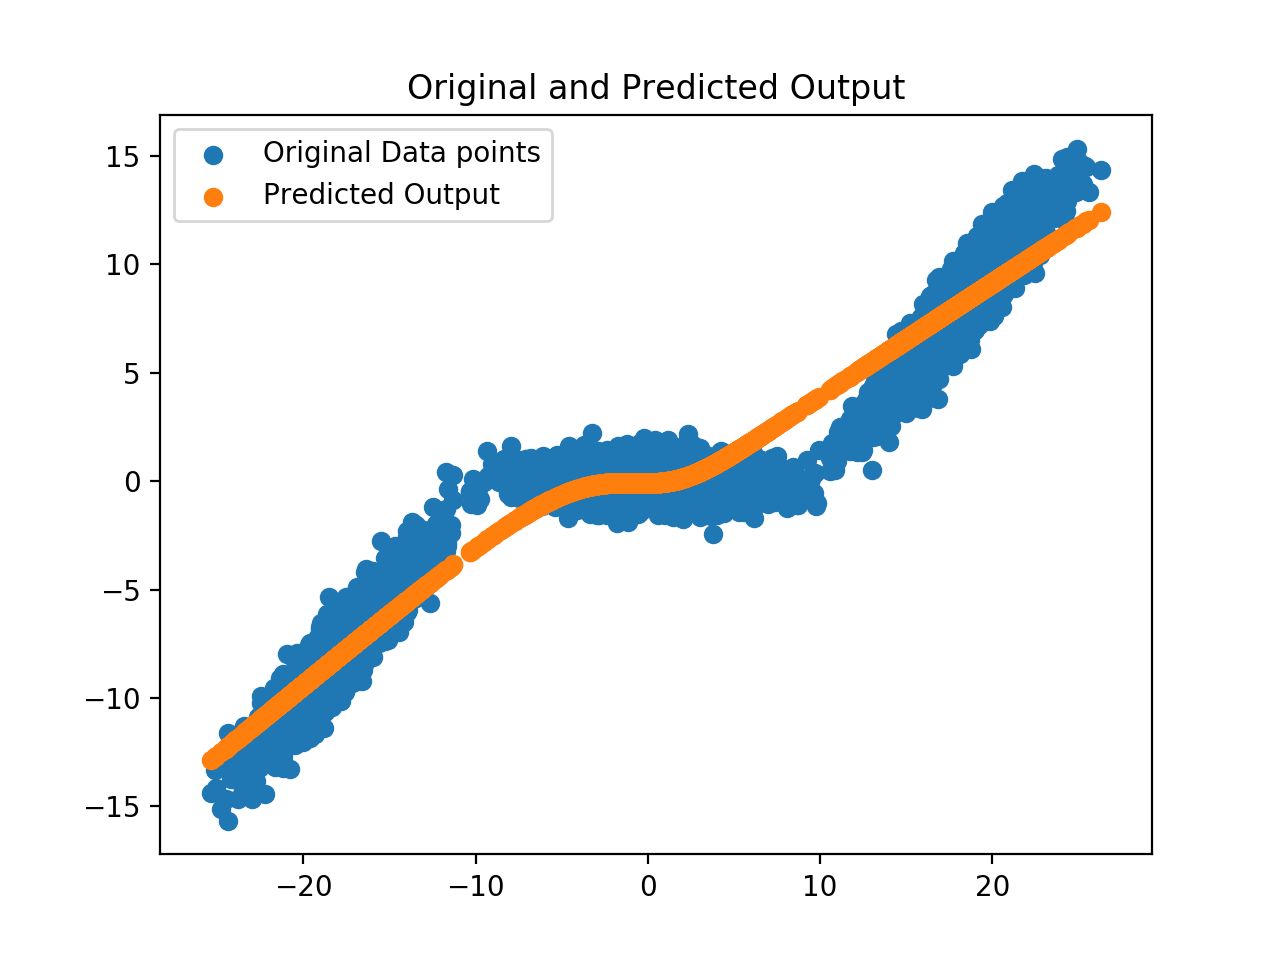

Text(0.5, 1.0, 'Original and Predicted Output')

In [61]:
%matplotlib notebook
plt.scatter(test_dataset[:, 0], test_dataset[:, 1], label = 'Original Data points')
plt.scatter(test_dataset[:, 0], test_pred, label = 'Predicted Output')
plt.legend()
plt.title('Original and Predicted Output')